## Importing the relevant libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, gc, joblib, re
warnings.filterwarnings('ignore')
# from sklearnex import patch_sklearn
# patch_sklearn()
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from scipy.stats import probplot
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, DropDuplicateFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, chi2, RFE, SequentialFeatureSelector
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from yellowbrick.classifier import ClassPredictionError

ModuleNotFoundError: No module named 'feature_engine'

## Loading the dataset

In [ ]:
df = pd.read_csv('data.csv')
df.head()

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.457733    
4                                           0.522298    

    Operating Gross Margin   Realized Sales Gross Margin  \
0                 0.601457                      0.601457   
1                 0.610235                      0.610235   
2                 0.601450                      0.601364   
3                 0.583541                      0.583541   
4                 0.598783                      0.598783   

    Operating Profit Rate   Pre-tax net Interest Rate  \
0                0.998969                    0.796887   
1                0.998946                    0.797380   
2                0.998857                    0.796403   
3                0.998700                    0.796967   
4                0.998973                    0.797366   

    After-tax net Interest Rate   Non-industry income and expenditure/revenue  \
0                      0.808809                                      0.302646   
1                      0.809301                                      0.303556   
2                      0.808388                                      0.302035   
3                      0.808966                                      0.303350   
4                      0.809304                                      0.303475   

   ...   Net Income to Total Assets   Total assets to GNP price  \
0  ...                     0.716845                    0.009219   
1  ...                     0.795297                    0.008323   
2  ...                     0.774670                    0.040003   
3  ...                     0.739555                    0.003252   
4  ...                     0.795016                    0.003878   

    No-credit Interval   Gross Profit to Sales  \
0             0.622879                0.601453   
1             0.623652                0.610237   
2             0.623841                0.601449   
3             0.622929                0.583538   
4             0.623521                0.598782   

    Net Income to Stockholder's Equity   Liability to Equity  \
0                             0.827890              0.290202   
1                             0.839969              0.283846   
2                             0.836774              0.290189   
3                             0.834697              0.281721   
4                             0.839973              0.278514   

    Degree of Financial Leverage (DFL)  \
0                             0.026601   
1                             0.264577   
2                             0.026555   
3                             0.026697   
4                             0.024752   

    Interest Coverage Ratio (Interest expense to EBIT)   Net Income Flag  \
0                                           0.564050                   1   
1                                           0.570175                   1   
2                                           0.563706                   1   
3                                           0.564663                   1   
4                        

## Data Exploration

In [ ]:
df.shape

(6819, 96)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [ ]:
df.describe()

Bankrupt?   ROA(C) before interest and depreciation before interest  \
count  6819.000000                                        6819.000000          
mean      0.032263                                           0.505180          
std       0.176710                                           0.060686          
min       0.000000                                           0.000000          
25%       0.000000                                           0.476527          
50%       0.000000                                           0.502706          
75%       0.000000                                           0.535563          
max       1.000000                                           1.000000          

        ROA(A) before interest and % after tax  \
count                              6819.000000   
mean                                  0.558625   
std                                   0.065620   
min                                   0.000000   
25%                                   0.535543   
50%                                   0.559802   
75%                                   0.589157   
max                                   1.000000   

        ROA(B) before interest and depreciation after tax  \
count                                        6819.000000    
mean                                            0.553589    
std                                             0.061595    
min                                             0.000000    
25%                                             0.527277    
50%                                             0.552278    
75%                                             0.584105    
max                                             1.000000    

        Operating Gross Margin   Realized Sales Gross Margin  \
count              6819.000000                   6819.000000   
mean                  0.607948                      0.607929   
std                   0.016934                      0.016916   
min                   0.000000                      0.000000   
25%                   0.600445                      0.600434   
50%                   0.605997                      0.605976   
75%                   0.613914                      0.613842   
max                   1.000000                      1.000000   

        Operating Profit Rate   Pre-tax net Interest Rate  \
count             6819.000000                 6819.000000   
mean                 0.998755                    0.797190   
std                  0.013010                    0.012869   
min                  0.000000                    0.000000   
25%                  0.998969                    0.797386   
50%                  0.999022                    0.797464   
75%                  0.999095                    0.797579   
max                  1.000000                    1.000000   

        After-tax net Interest Rate  \
count                   6819.000000   
mean                       0.809084   
std                        0.013601   
min                        0.000000   
25%                        0.809312   
50%                        0.809375   
75%                        0.809469   
max                        1.000000   

        Non-industry income and expenditure/revenue  ...  \
count                                   6819.000000  ...   
mean                                       0.303623  ...   
std                                        0.011163  ...   
min                                        0.000000  ...   
25%                                        0.303466  ...   
50%                                        0.303525  ...   
75%                                        0.303585  ...   
max                                        1.000000  ...   

        Net Income to Total Assets   Total assets to GNP price  \
count                  6819.000000                6.819000e+03   
mean                      0.807760                1.862942e+07   
std                       0.040332                3.764501e+08   
min

In [ ]:
df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [ ]:
df.duplicated().sum()

0

In [ ]:
# Removing the columns with zero variance
df.drop(df.columns[df.nunique() == 1][0],axis=1,inplace=True)

In [ ]:
df.columns = df.columns.str.replace(' ','')

In [ ]:
df.rename({'Liability-AssetsFlag': 'LiabilityAssetsFlag'},axis=1,inplace=True)

In [ ]:
df.describe()

Bankrupt?  ROA(C)beforeinterestanddepreciationbeforeinterest  \
count  6819.000000                                        6819.000000   
mean      0.032263                                           0.505180   
std       0.176710                                           0.060686   
min       0.000000                                           0.000000   
25%       0.000000                                           0.476527   
50%       0.000000                                           0.502706   
75%       0.000000                                           0.535563   
max       1.000000                                           1.000000   

       ROA(A)beforeinterestand%aftertax  \
count                       6819.000000   
mean                           0.558625   
std                            0.065620   
min                            0.000000   
25%                            0.535543   
50%                            0.559802   
75%                            0.589157   
max                            1.000000   

       ROA(B)beforeinterestanddepreciationaftertax  OperatingGrossMargin  \
count                                  6819.000000           6819.000000   
mean                                      0.553589              0.607948   
std                                       0.061595              0.016934   
min                                       0.000000              0.000000   
25%                                       0.527277              0.600445   
50%                                       0.552278              0.605997   
75%                                       0.584105              0.613914   
max                                       1.000000              1.000000   

       RealizedSalesGrossMargin  OperatingProfitRate  Pre-taxnetInterestRate  \
count               6819.000000          6819.000000             6819.000000   
mean                   0.607929             0.998755                0.797190   
std                    0.016916             0.013010                0.012869   
min                    0.000000             0.000000                0.000000   
25%                    0.600434             0.998969                0.797386   
50%                    0.605976             0.999022                0.797464   
75%                    0.613842             0.999095                0.797579   
max                    1.000000             1.000000                1.000000   

       After-taxnetInterestRate  Non-industryincomeandexpenditure/revenue  \
count               6819.000000                               6819.000000   
mean                   0.809084                                  0.303623   
std                    0.013601                                  0.011163   
min                    0.000000                                  0.000000   
25%                    0.809312                                  0.303466   
50%                    0.809375                                  0.303525   
75%                    0.809469                                  0.303585   
max                    1.000000                                  1.000000   

       ...  LiabilityAssetsFlag  NetIncometoTotalAssets  \
count  ...          6819.000000             6819.000000   
mean   ...             0.001173                0.807760   
std    ...             0.034234                0.040332   
min    ...             0.000000                0.000000   
25%    ...             0.000000                0.796750   
50%    ...             0.000000                0.810619   
75%    ...             0.000000                0.826455   
max    ...             1.000000                1.000000   

       TotalassetstoGNPprice  No-creditInterval  GrossProfittoSales  \
count           6.819000e+03        6819.000000         6819.000000   
mean            1.862942e+07           0.623915            0.607946   
std             3.764501e+08           0.012290            0.016934   
min             0.000000e+00           0.000000

## Exploratory Data Analysis (EDA)

Skewness of ROA(C)beforeinterestanddepreciationbeforeinterest: -0.3239410032376897
Kurtosis of ROA(C)beforeinterestanddepreciationbeforeinterest: 6.390770201755304


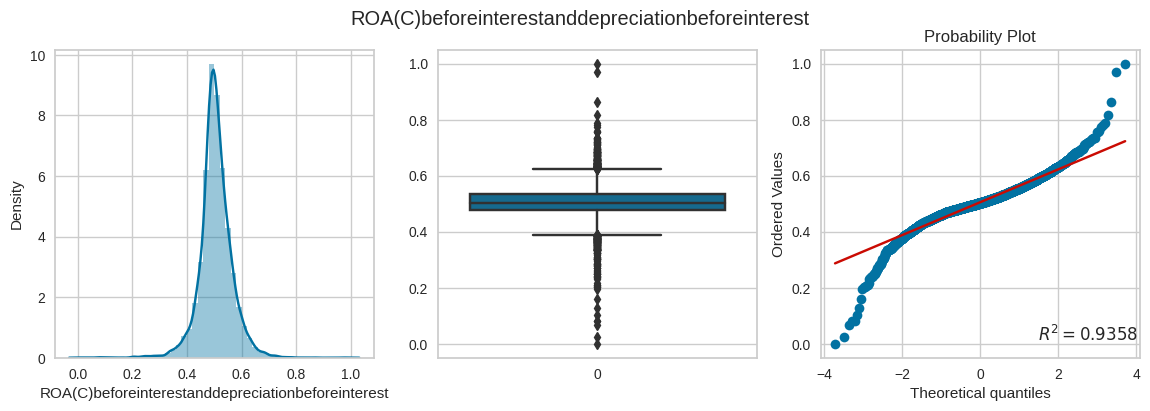

Skewness of ROA(A)beforeinterestand%aftertax: -1.0337268374435982
Kurtosis of ROA(A)beforeinterestand%aftertax: 9.03878483556222


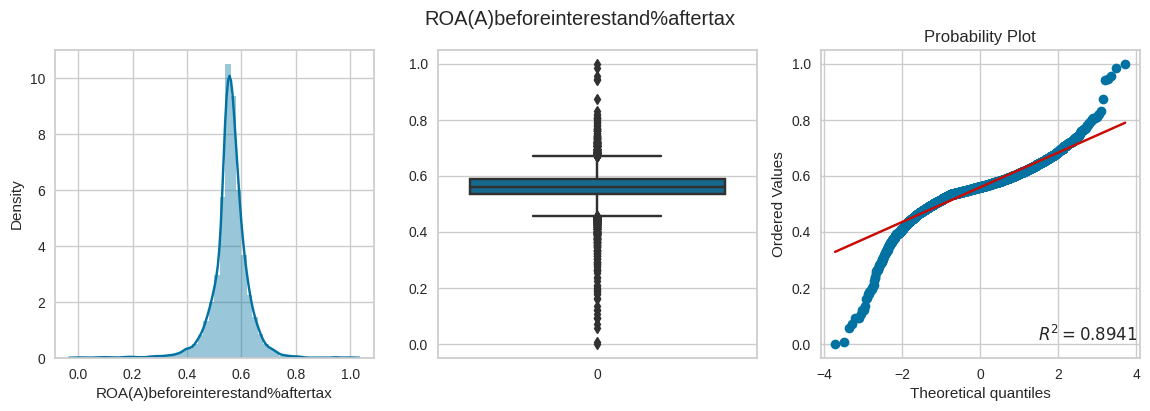

Skewness of ROA(B)beforeinterestanddepreciationaftertax: -0.7635637191791648
Kurtosis of ROA(B)beforeinterestanddepreciationaftertax: 7.929073721709035


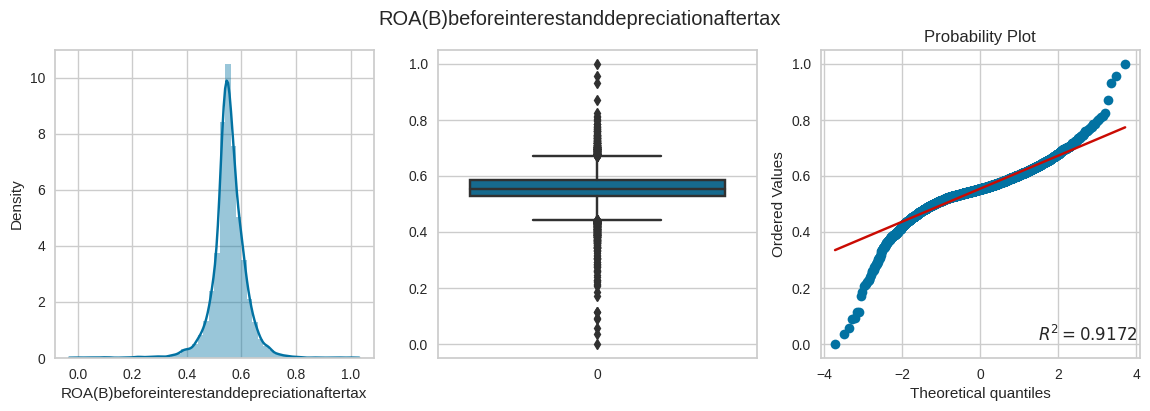

Skewness of OperatingGrossMargin: -8.043367962976834
Kurtosis of OperatingGrossMargin: 365.5406713618406


Skewness of RealizedSalesGrossMargin: -8.066572143637043
Kurtosis of RealizedSalesGrossMargin: 367.0418297144066


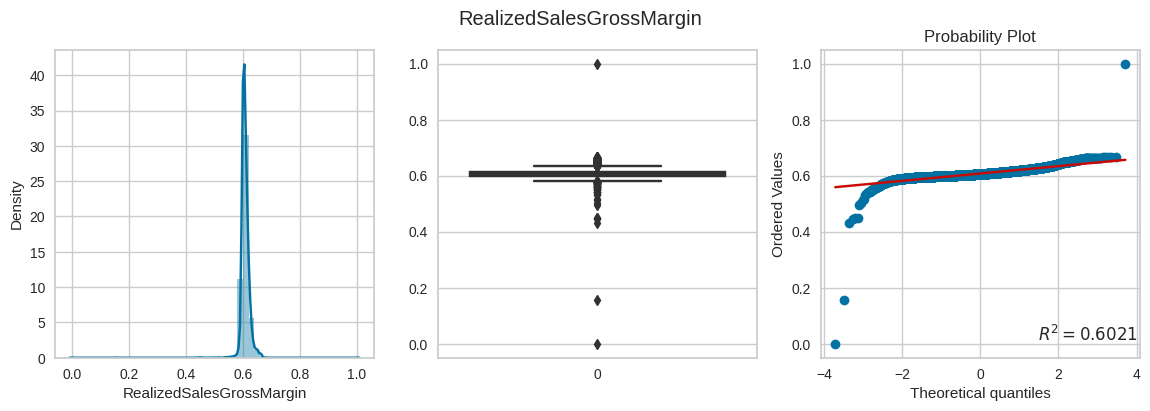

Skewness of OperatingProfitRate: -70.23716436128285
Kurtosis of OperatingProfitRate: 5210.086057434661


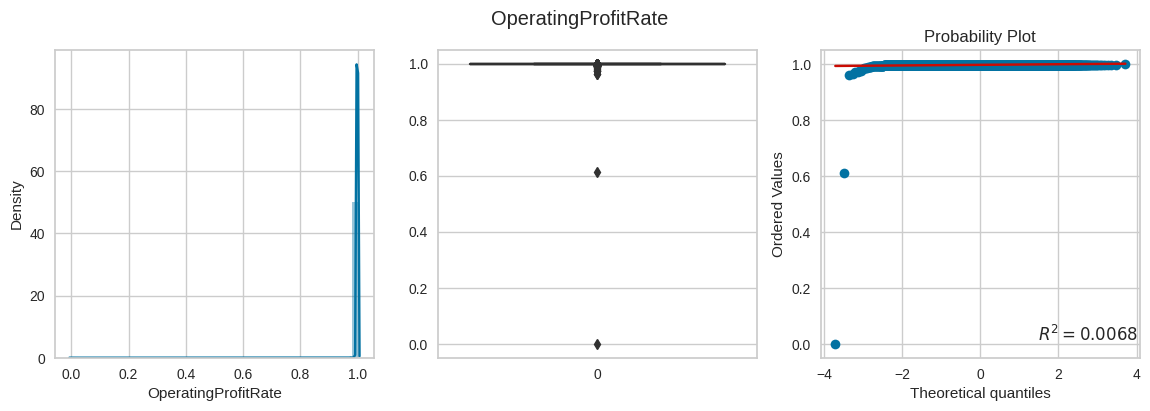

Skewness of Pre-taxnetInterestRate: -52.48286652280293
Kurtosis of Pre-taxnetInterestRate: 3053.033349419831


Skewness of After-taxnetInterestRate: -52.99574381463863
Kurtosis of After-taxnetInterestRate: 3029.1157905263353


Skewness of Non-industryincomeandexpenditure/revenue: 39.64168918755239
Kurtosis of Non-industryincomeandexpenditure/revenue: 2649.428721536451


Skewness of Continuousinterestrate(aftertax): -53.200120791151186
Kurtosis of Continuousinterestrate(aftertax): 3128.7341772015984


Skewness of OperatingExpenseRate: 1.2486733165601693
Kurtosis of OperatingExpenseRate: -0.08151166869999527


Skewness of Researchanddevelopmentexpenserate: 1.2820432317125836
Kurtosis of Researchanddevelopmentexpenserate: 0.5935180951252859


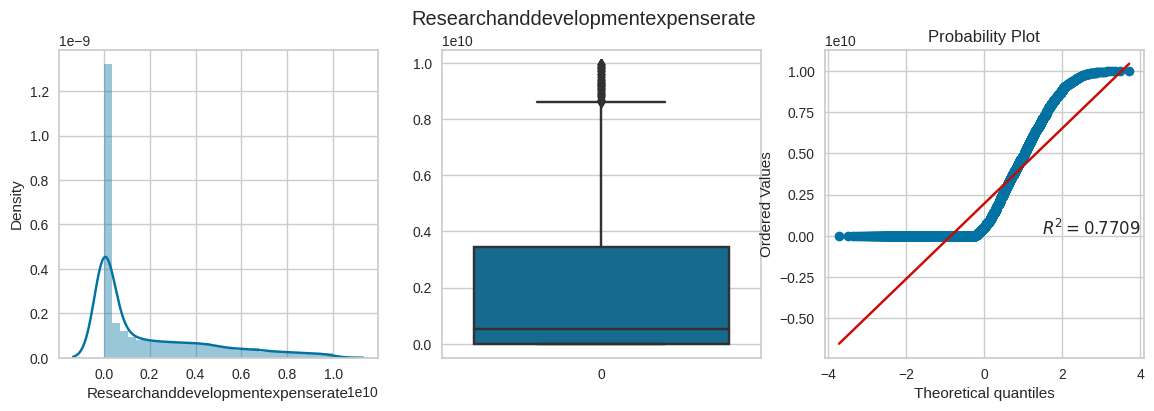

Skewness of Cashflowrate: 3.990585538817217
Kurtosis of Cashflowrate: 257.0127577529456


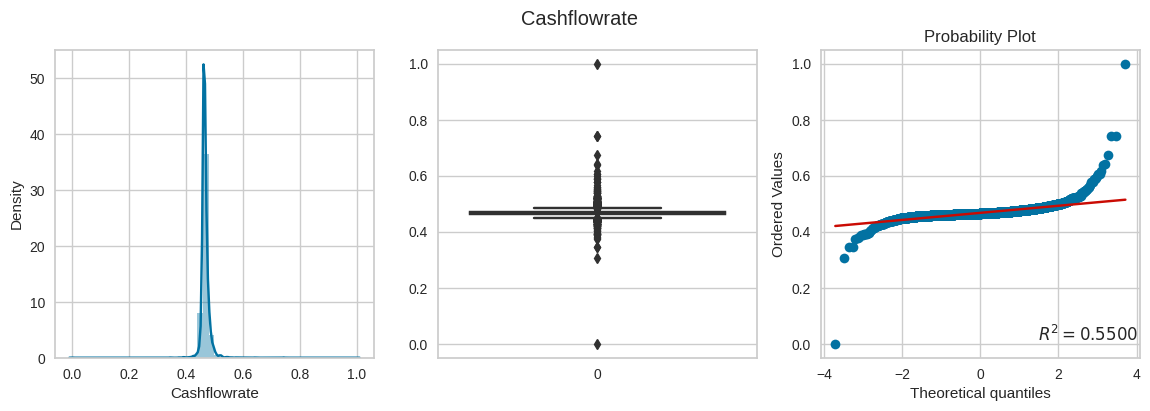

Skewness of Interest-bearingdebtinterestrate: 7.033376780370779
Kurtosis of Interest-bearingdebtinterestrate: 50.04947819968481


Skewness of Taxrate(A): 1.903875252639803
Kurtosis of Taxrate(A): 6.412338808013795


Skewness of NetValuePerShare(B): 4.562322576989663
Kurtosis of NetValuePerShare(B): 64.6769768495687


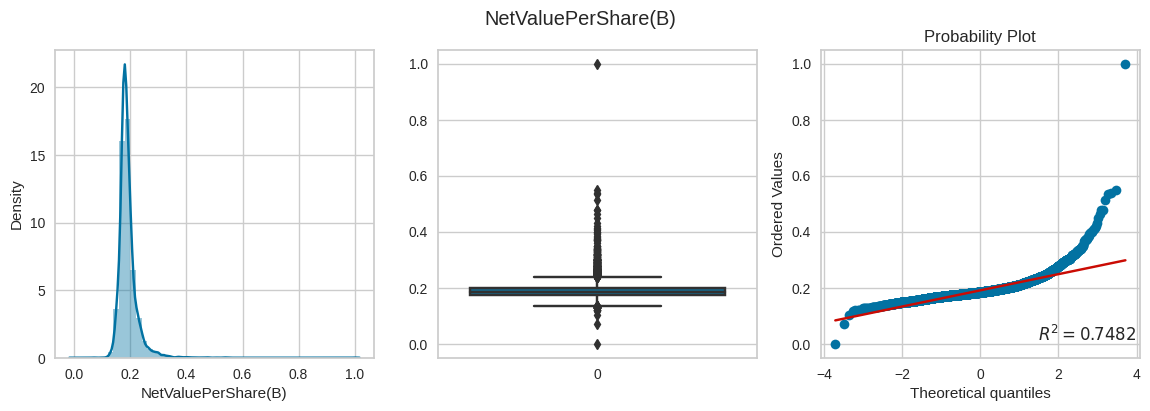

Skewness of NetValuePerShare(A): 4.518132057298601
Kurtosis of NetValuePerShare(A): 64.06107743847966


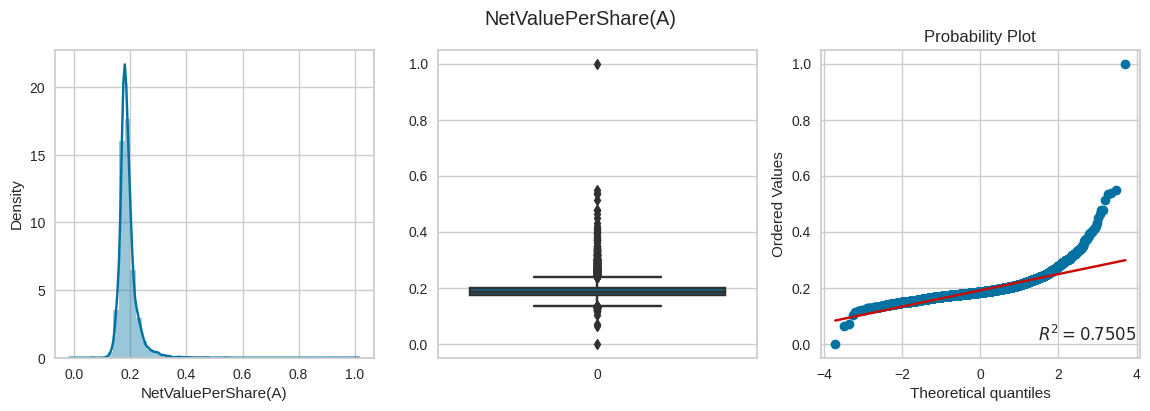

Skewness of NetValuePerShare(C): 4.513740533156161
Kurtosis of NetValuePerShare(C): 63.98976253162403


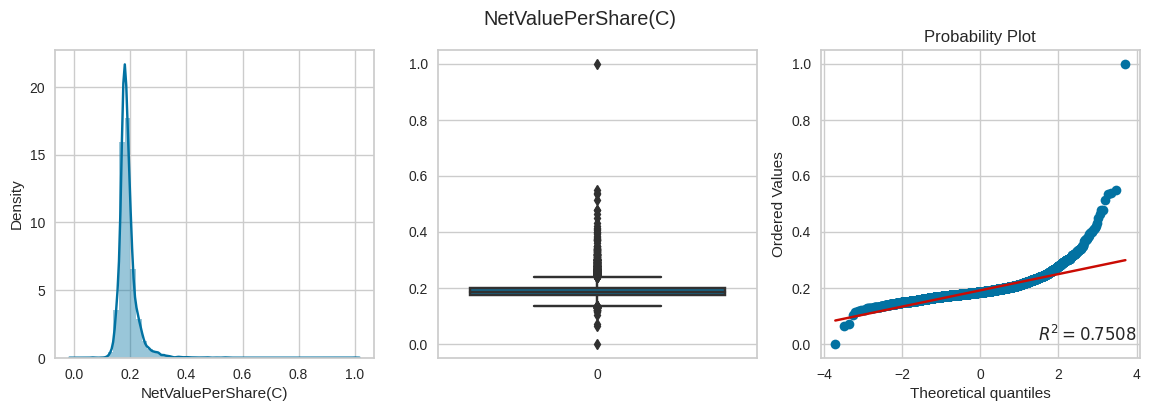

Skewness of PersistentEPSintheLastFourSeasons: 5.13596305293763
Kurtosis of PersistentEPSintheLastFourSeasons: 81.62179021840292


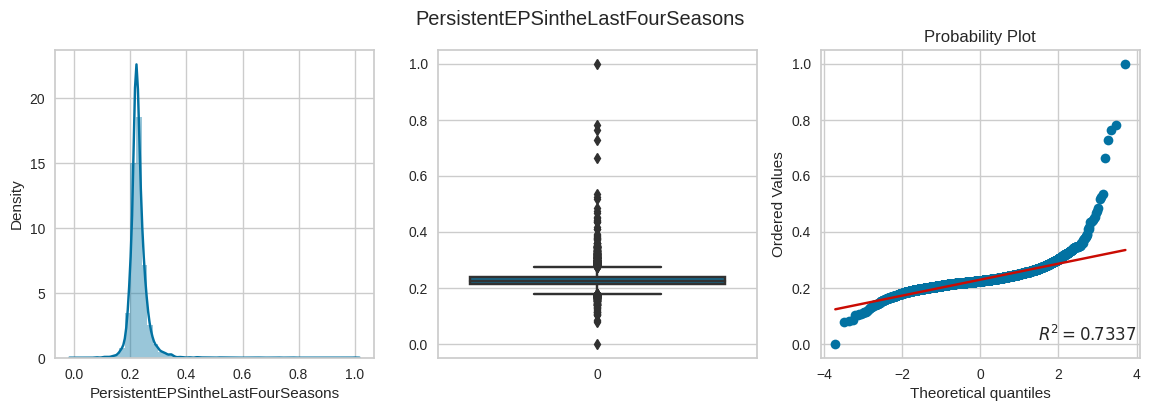

Skewness of CashFlowPerShare: 8.018983552793829
Kurtosis of CashFlowPerShare: 353.0192205514455


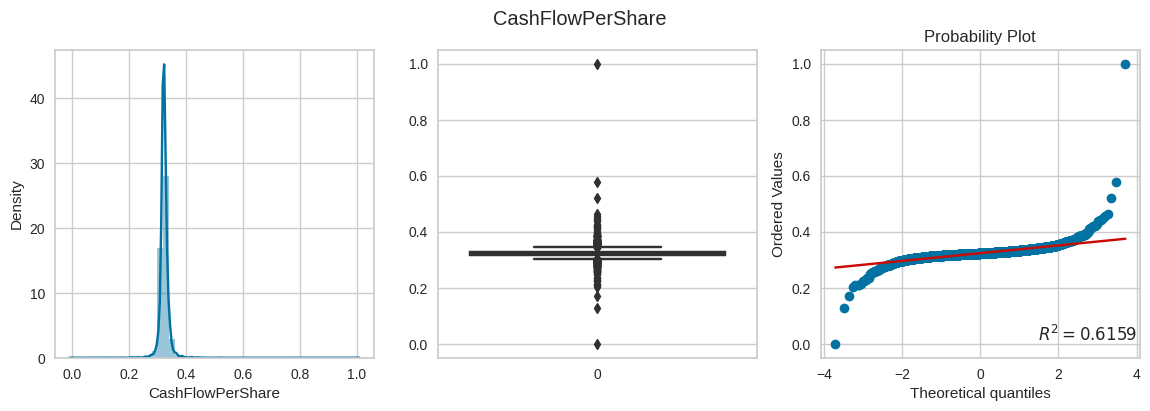

Skewness of RevenuePerShare(Yuan¥): 43.7690982625658
Kurtosis of RevenuePerShare(Yuan¥): 2127.811572204429


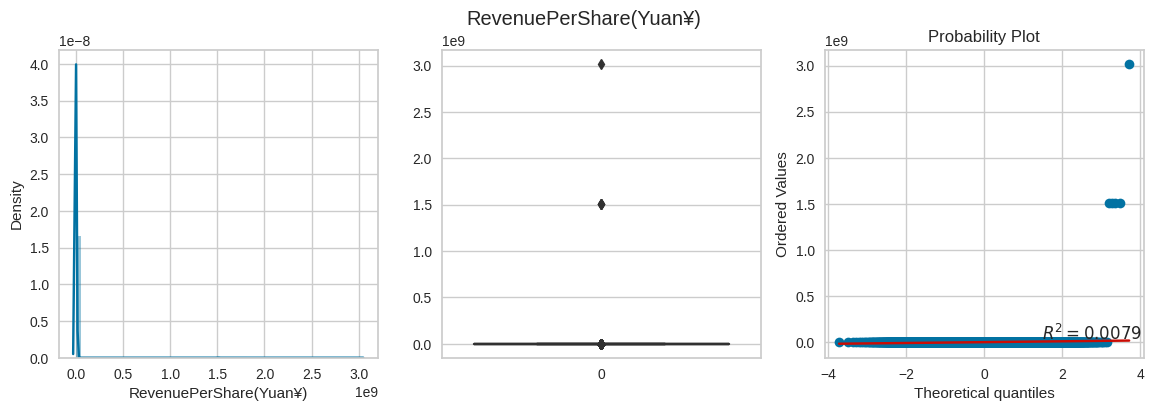

Skewness of OperatingProfitPerShare(Yuan¥): 8.811855619678495
Kurtosis of OperatingProfitPerShare(Yuan¥): 209.3654017963822


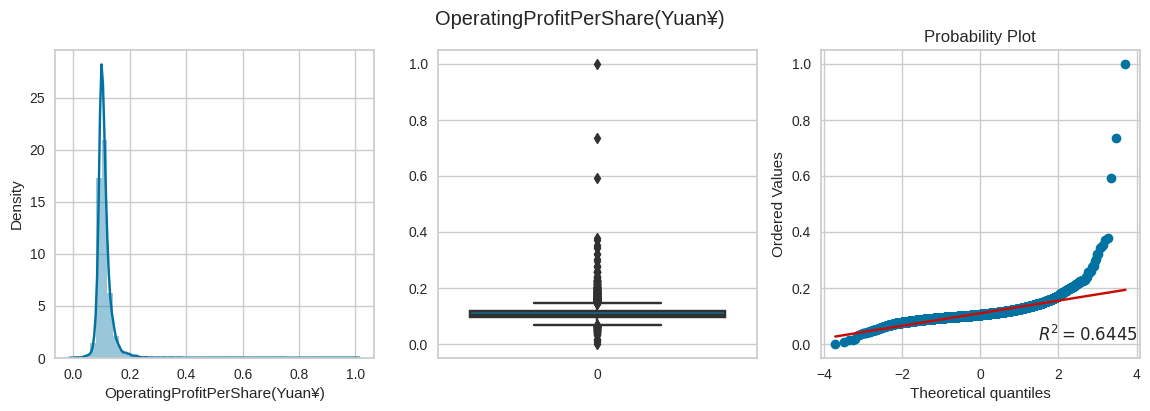

Skewness of PerShareNetprofitbeforetax(Yuan¥): 6.002590150781108
Kurtosis of PerShareNetprofitbeforetax(Yuan¥): 100.65873583703488


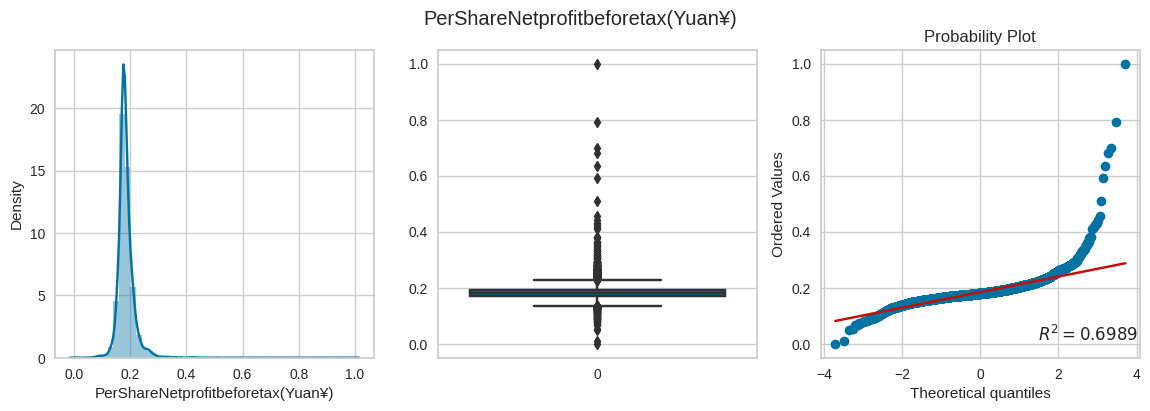

Skewness of RealizedSalesGrossProfitGrowthRate: 77.92510905908482
Kurtosis of RealizedSalesGrossProfitGrowthRate: 6295.616592870354


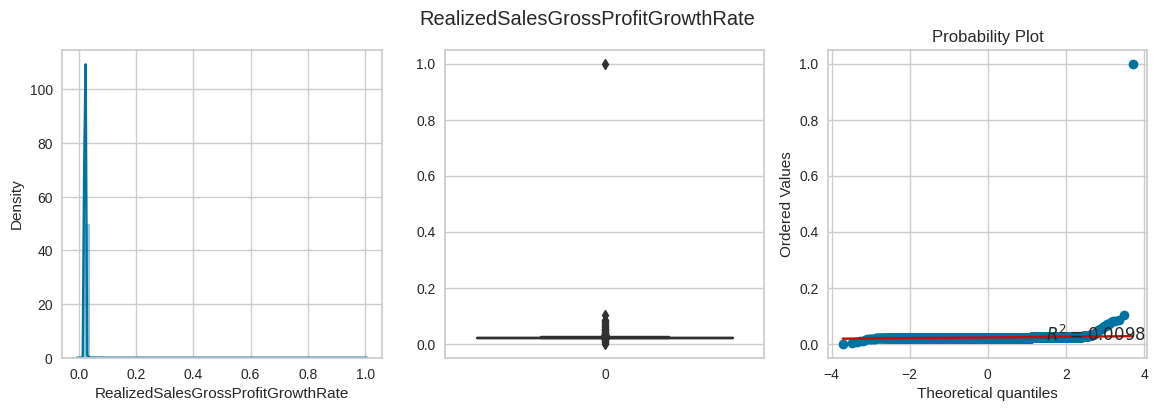

Skewness of OperatingProfitGrowthRate: -71.68895016582744
Kurtosis of OperatingProfitGrowthRate: 5684.153243539675


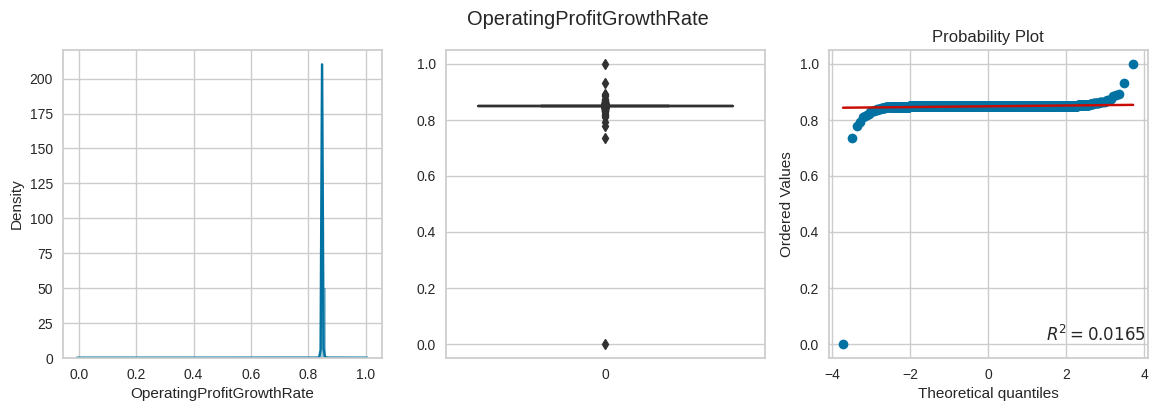

Skewness of After-taxNetProfitGrowthRate: -25.58336694298504
Kurtosis of After-taxNetProfitGrowthRate: 1268.0532691998003


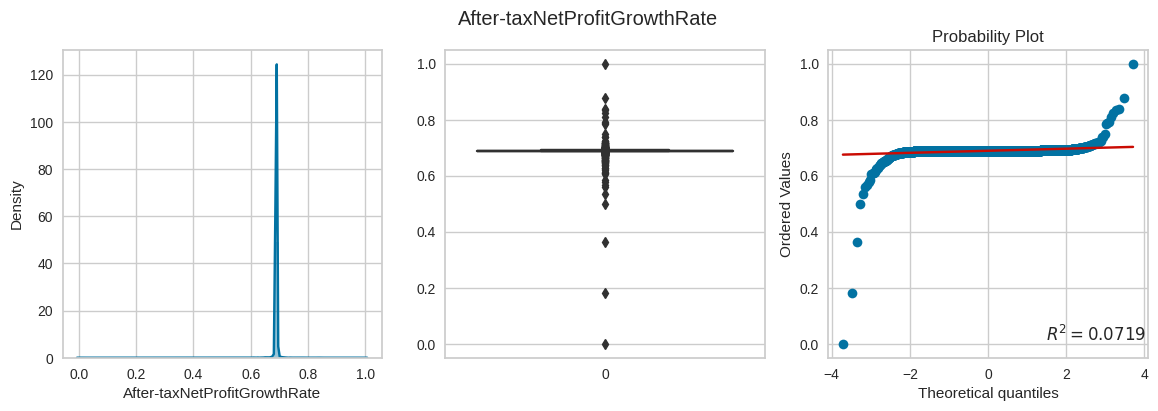

Skewness of RegularNetProfitGrowthRate: -25.262840959449818
Kurtosis of RegularNetProfitGrowthRate: 1247.6219738294922


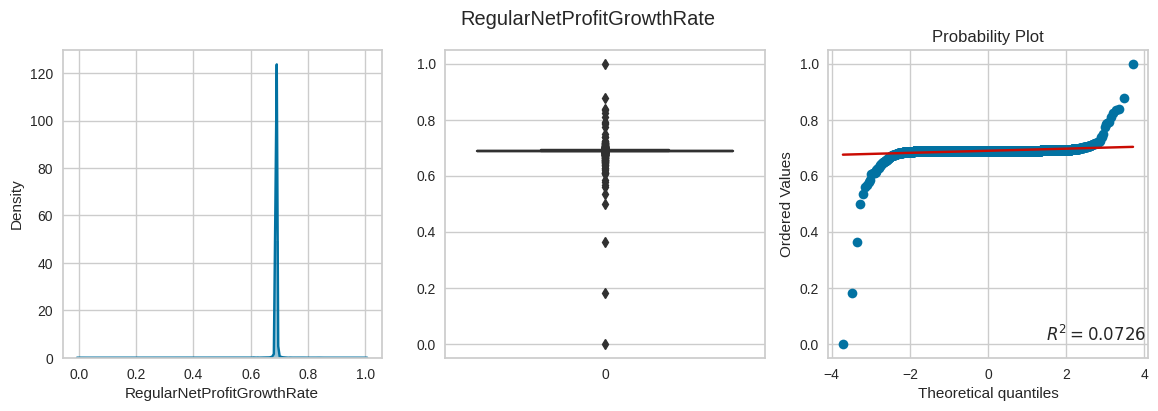

Skewness of ContinuousNetProfitGrowthRate: 67.09753430866733
Kurtosis of ContinuousNetProfitGrowthRate: 5396.572181859231


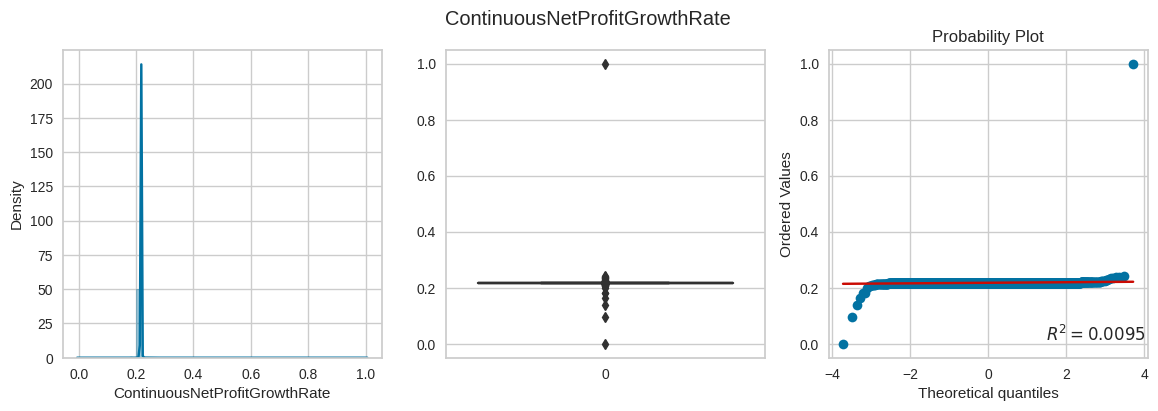

Skewness of TotalAssetGrowthRate: -0.9187910949038905
Kurtosis of TotalAssetGrowthRate: -0.41665952702429543


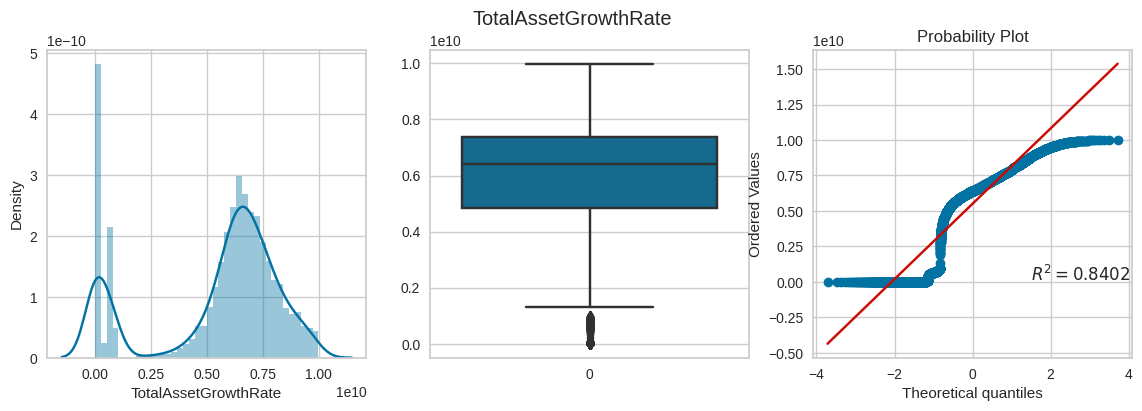

Skewness of NetValueGrowthRate: 80.29184419453097
Kurtosis of NetValueGrowthRate: 6544.9153900061565


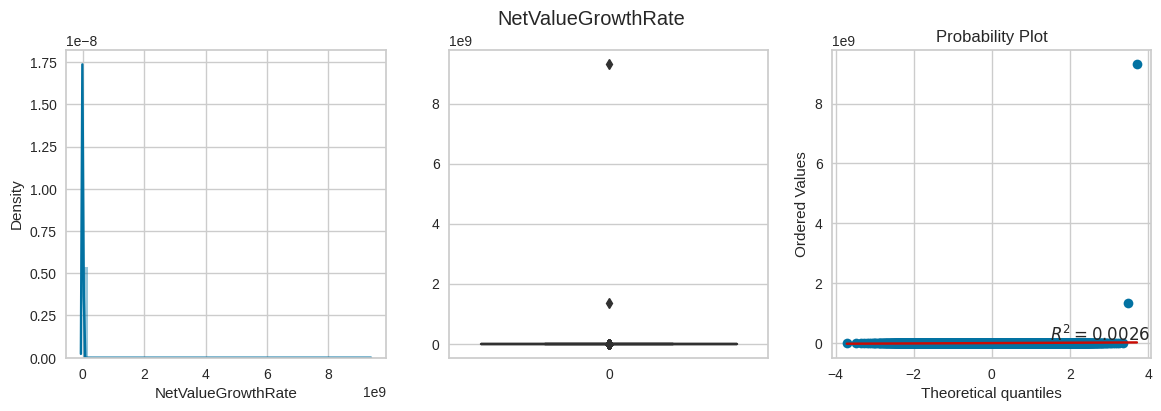

Skewness of TotalAssetReturnGrowthRateRatio: 62.499961053073136
Kurtosis of TotalAssetReturnGrowthRateRatio: 5074.957173470536


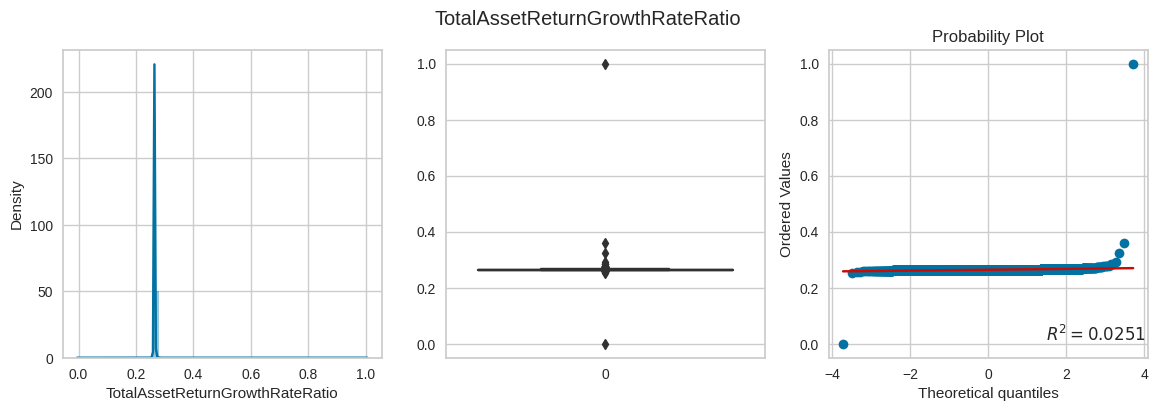

Skewness of CashReinvestment%: 2.318244374516142
Kurtosis of CashReinvestment%: 179.0532158732448


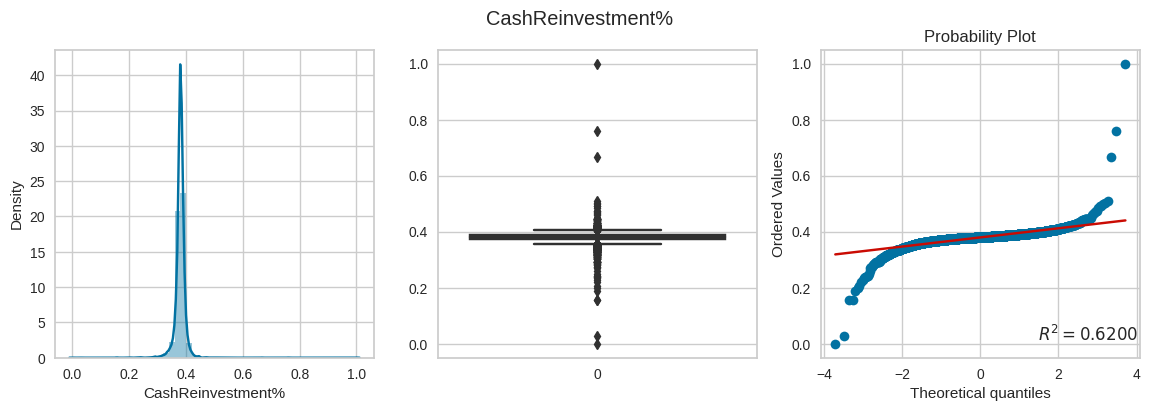

Skewness of CurrentRatio: 82.57723657279894
Kurtosis of CurrentRatio: 6818.999999999998


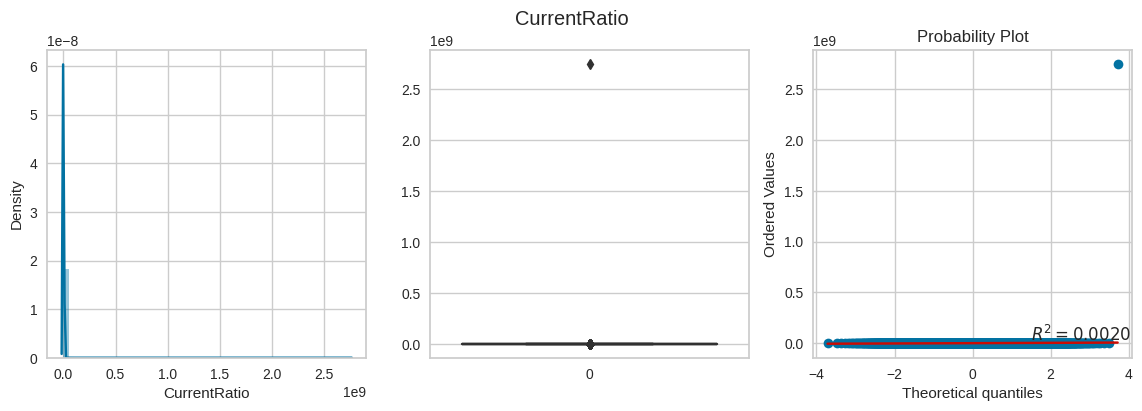

Skewness of QuickRatio: 31.644913015411564
Kurtosis of QuickRatio: 1051.7233183833025


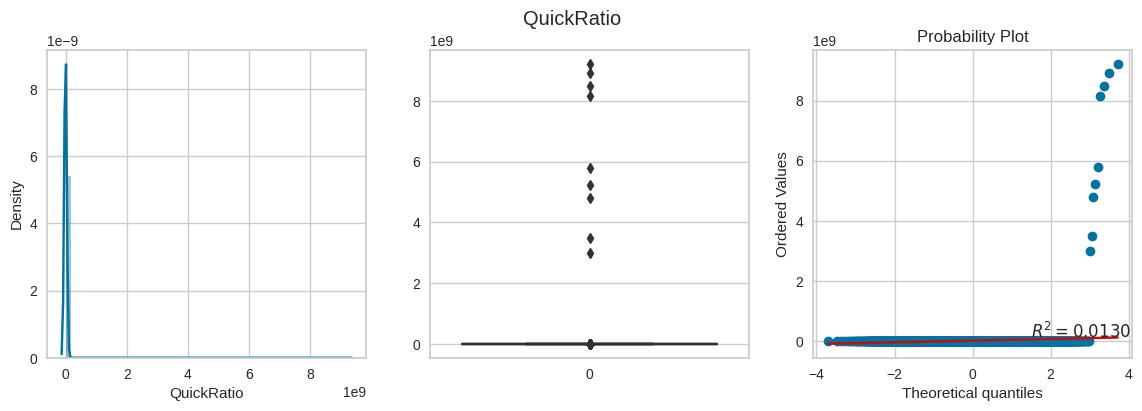

Skewness of InterestExpenseRatio: -16.822554123130764
Kurtosis of InterestExpenseRatio: 1741.3016540350882


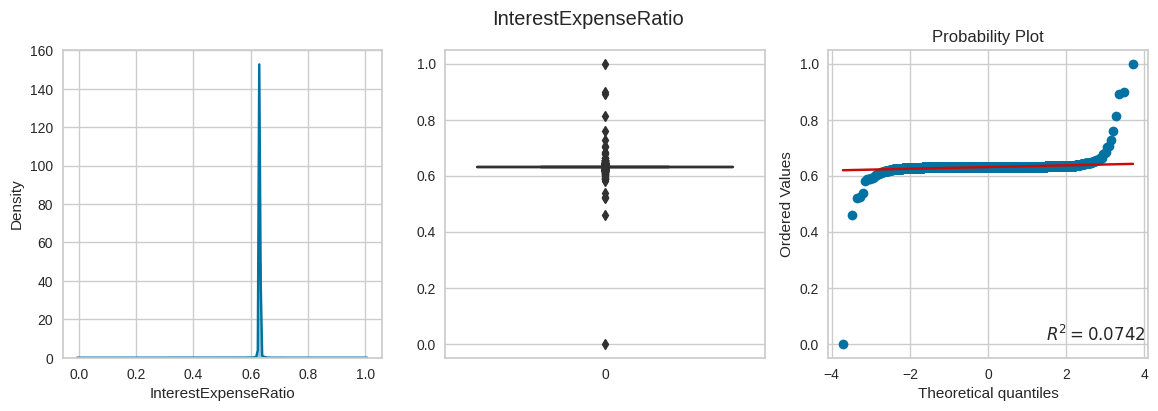

Skewness of Totaldebt/Totalnetworth: 46.355335845692984
Kurtosis of Totaldebt/Totalnetworth: 2348.240302316803


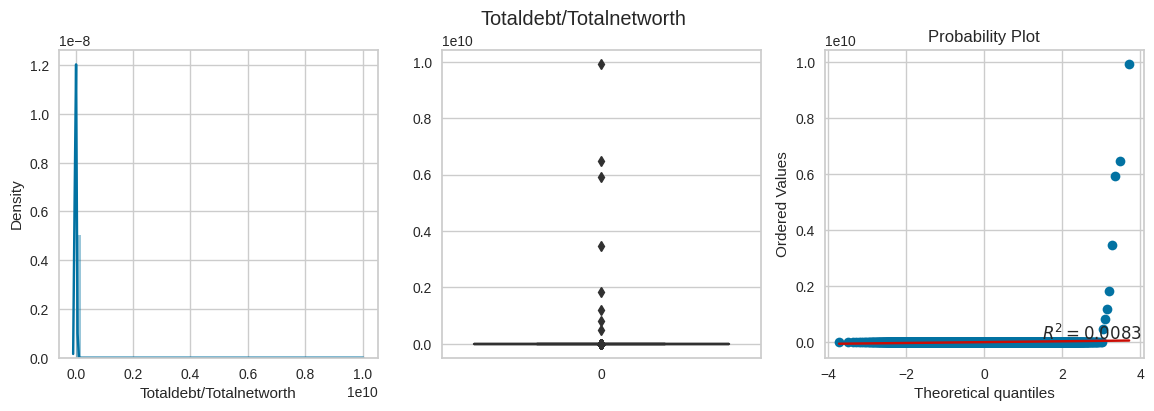

Skewness of Debtratio%: 0.98079611678978
Kurtosis of Debtratio%: 10.729727262534775


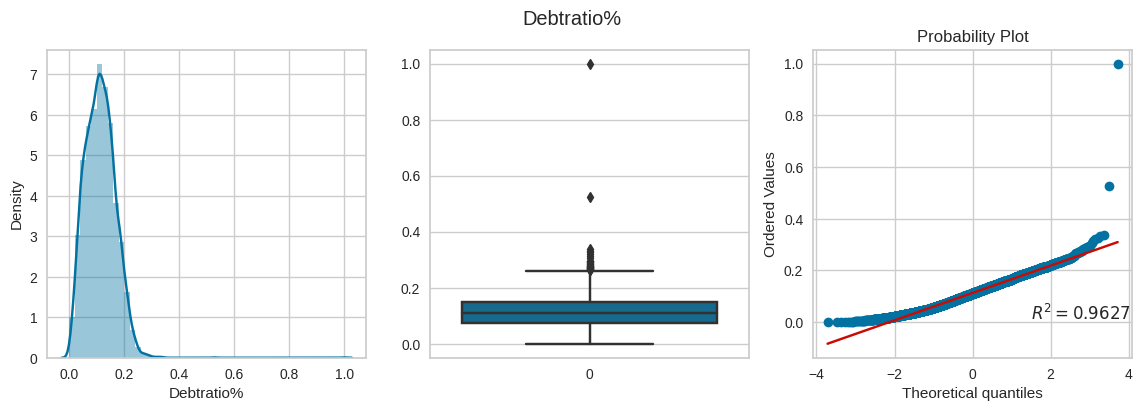

Skewness of Networth/Assets: -0.9807961167897898
Kurtosis of Networth/Assets: 10.729727262534793


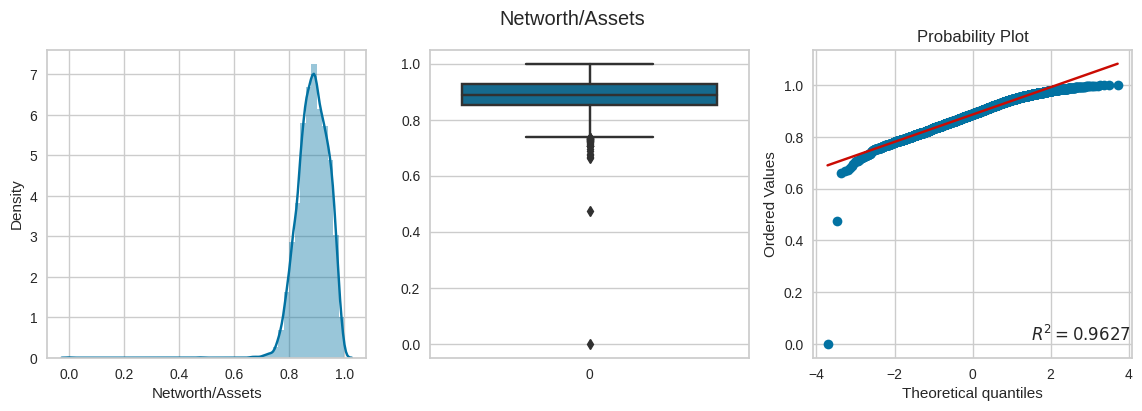

Skewness of Long-termfundsuitabilityratio(A): 24.96787271736492
Kurtosis of Long-termfundsuitabilityratio(A): 741.3864280461478


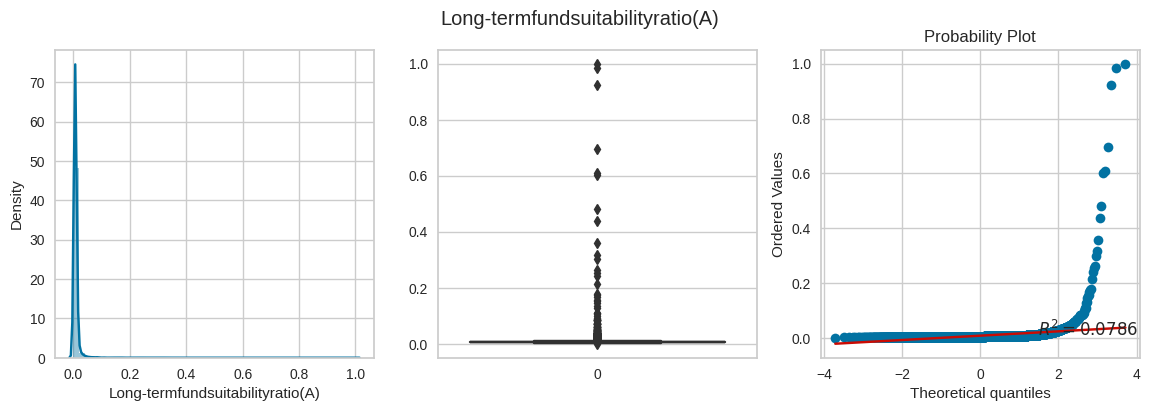

Skewness of Borrowingdependency: 20.838890887338852
Kurtosis of Borrowingdependency: 802.6464926904096


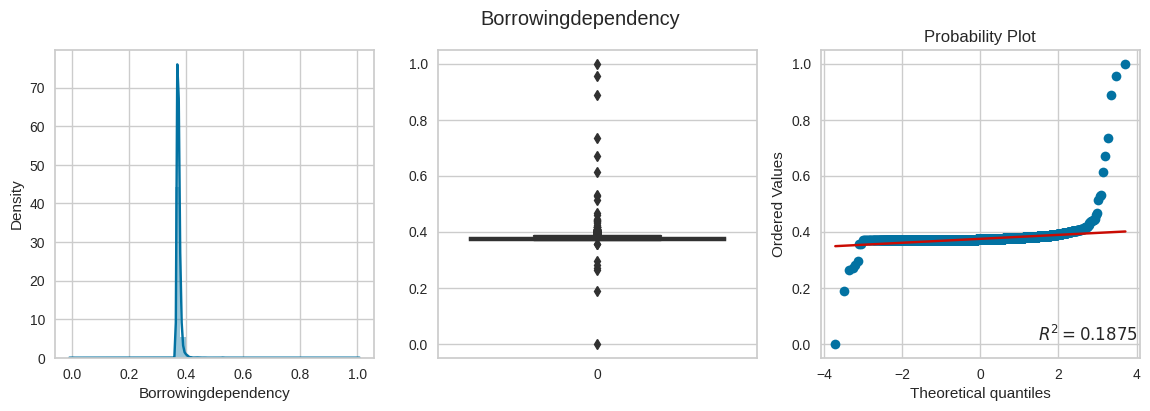

Skewness of Contingentliabilities/Networth: 79.67062005225556
Kurtosis of Contingentliabilities/Networth: 6491.885472505623


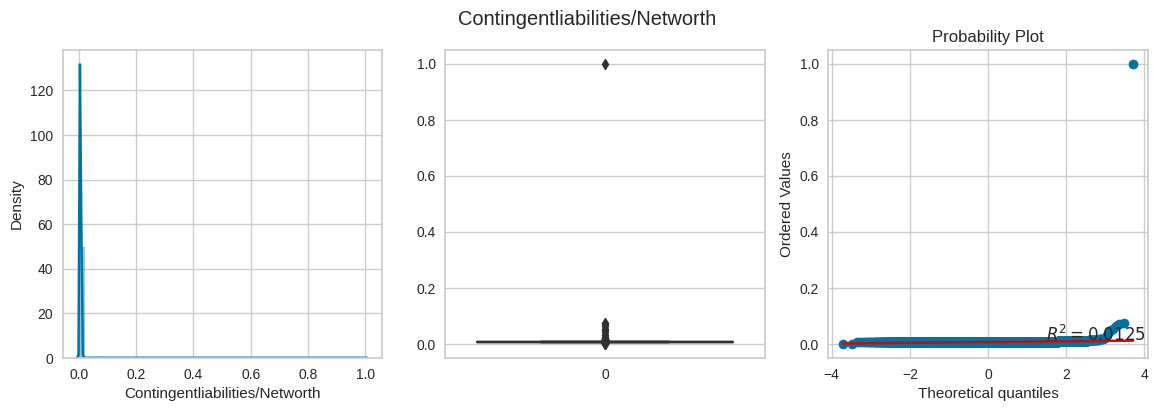

Skewness of Operatingprofit/Paid-incapital: 8.949387100606499
Kurtosis of Operatingprofit/Paid-incapital: 214.23313628156882


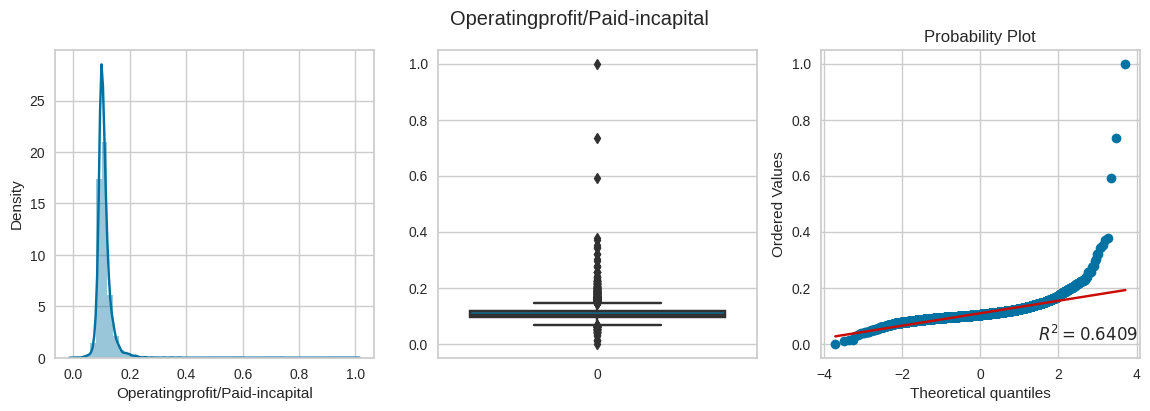

Skewness of Netprofitbeforetax/Paid-incapital: 6.379425570765882
Kurtosis of Netprofitbeforetax/Paid-incapital: 120.99777362028755


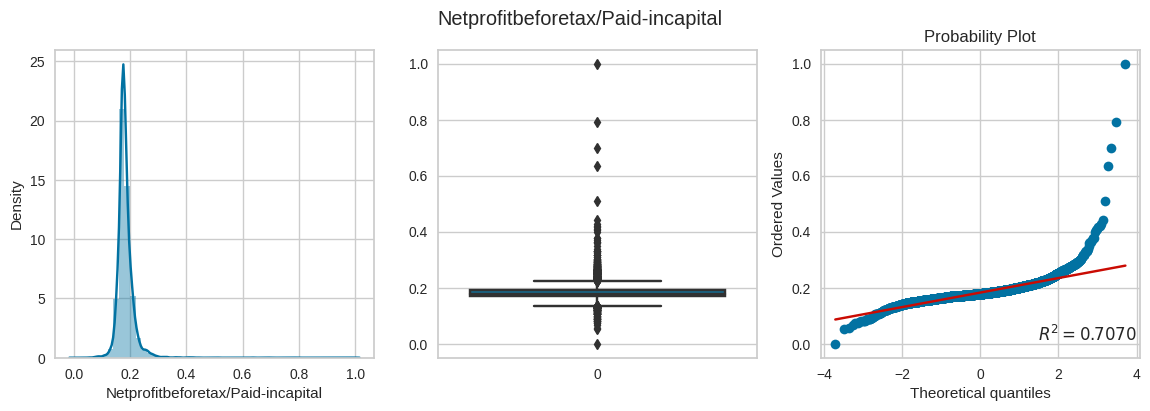

Skewness of Inventoryandaccountsreceivable/Netvalue: 13.112234234219
Kurtosis of Inventoryandaccountsreceivable/Netvalue: 778.9544307990403


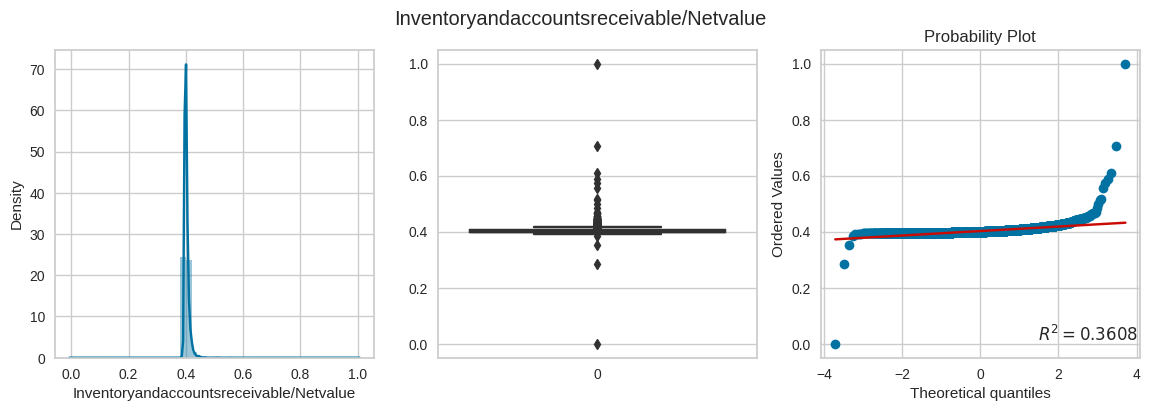

Skewness of TotalAssetTurnover: 2.3409066223409676
Kurtosis of TotalAssetTurnover: 9.506233123702605


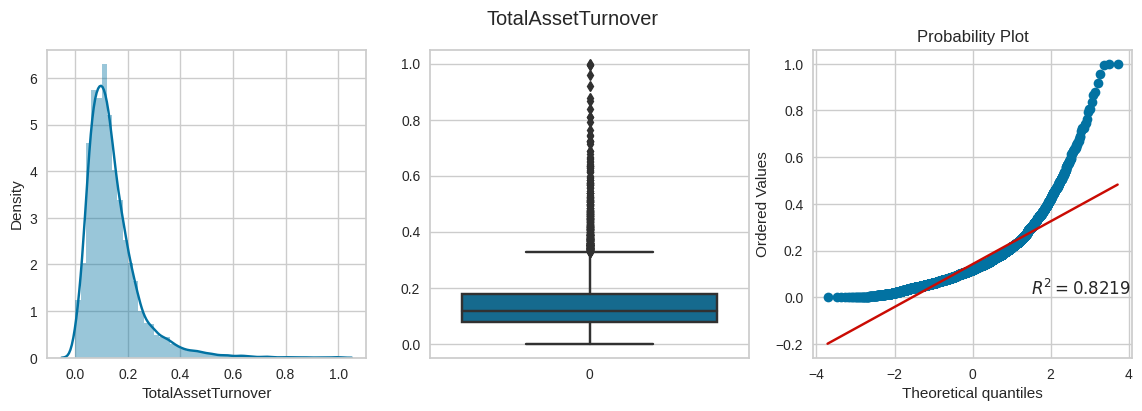

Skewness of AccountsReceivableTurnover: 25.84654655099649
Kurtosis of AccountsReceivableTurnover: 730.8881628306647


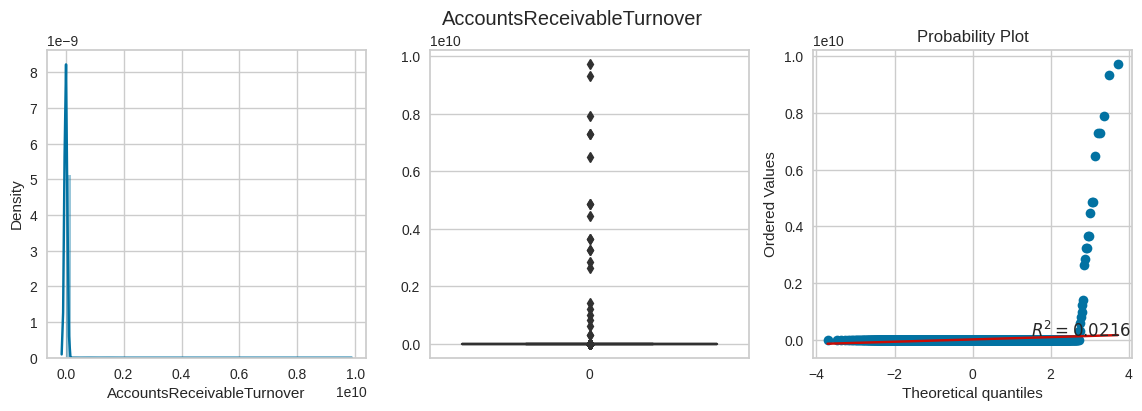

Skewness of AverageCollectionDays: 30.58008623206861
Kurtosis of AverageCollectionDays: 989.7354450426537


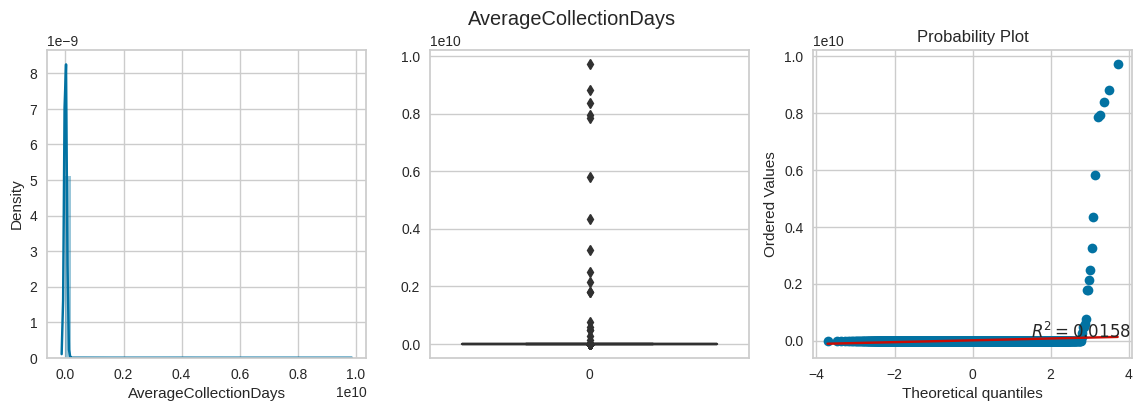

Skewness of InventoryTurnoverRate(times): 1.1372886202283368
Kurtosis of InventoryTurnoverRate(times): -0.3237645030283218


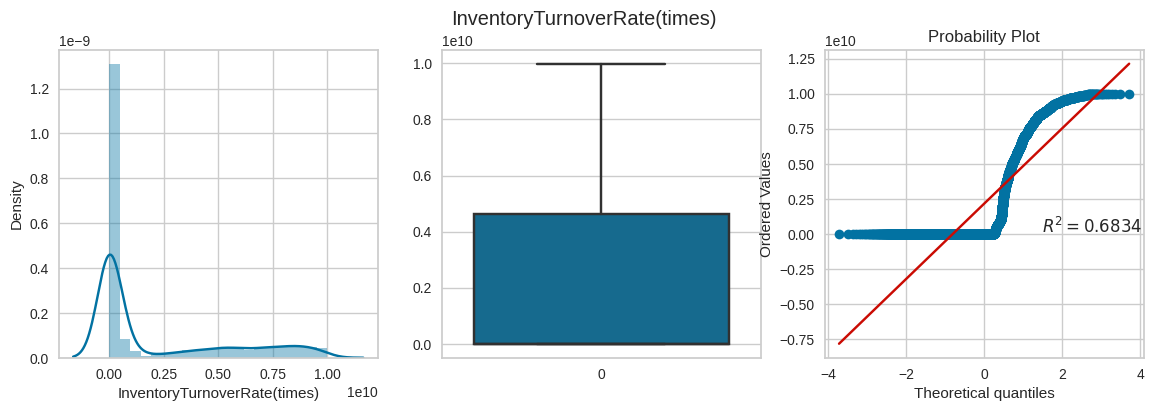

Skewness of FixedAssetsTurnoverFrequency: 2.349802853236018
Kurtosis of FixedAssetsTurnoverFrequency: 4.090862086239142


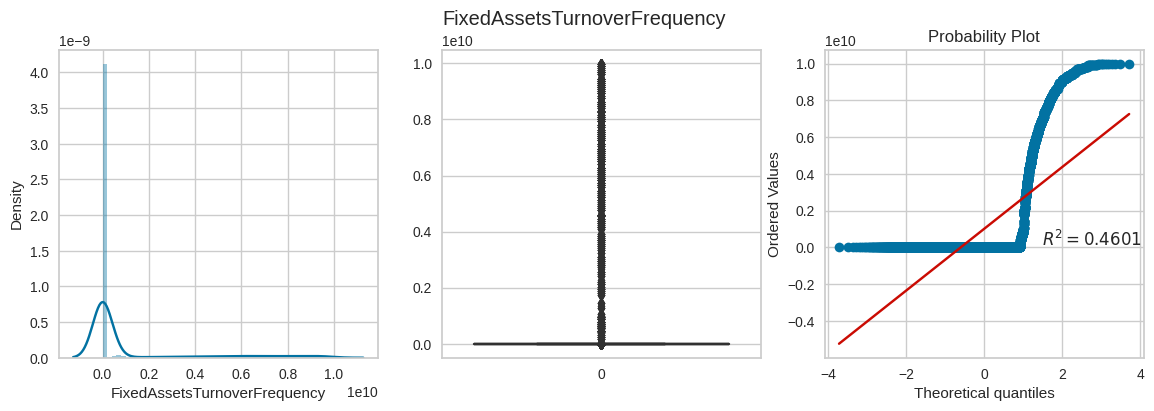

Skewness of NetWorthTurnoverRate(times): 8.9618483104736
Kurtosis of NetWorthTurnoverRate(times): 157.03797372678366


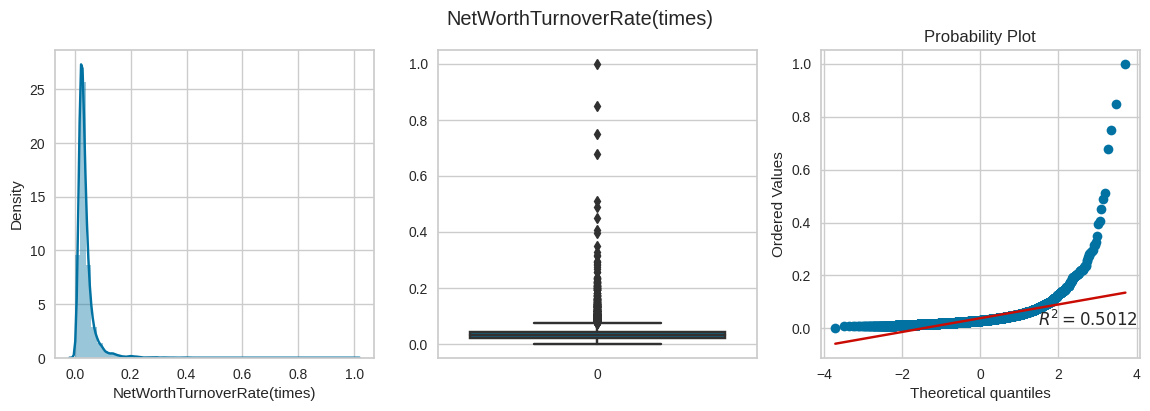

Skewness of Revenueperperson: 59.434479930512104
Kurtosis of Revenueperperson: 3571.0270387802907


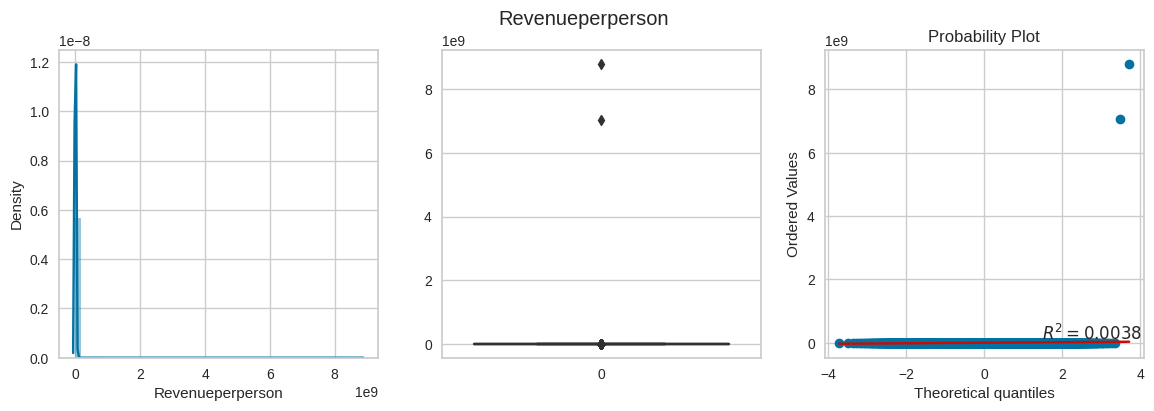

Skewness of Operatingprofitperperson: 7.788299483017489
Kurtosis of Operatingprofitperperson: 114.39423583623136


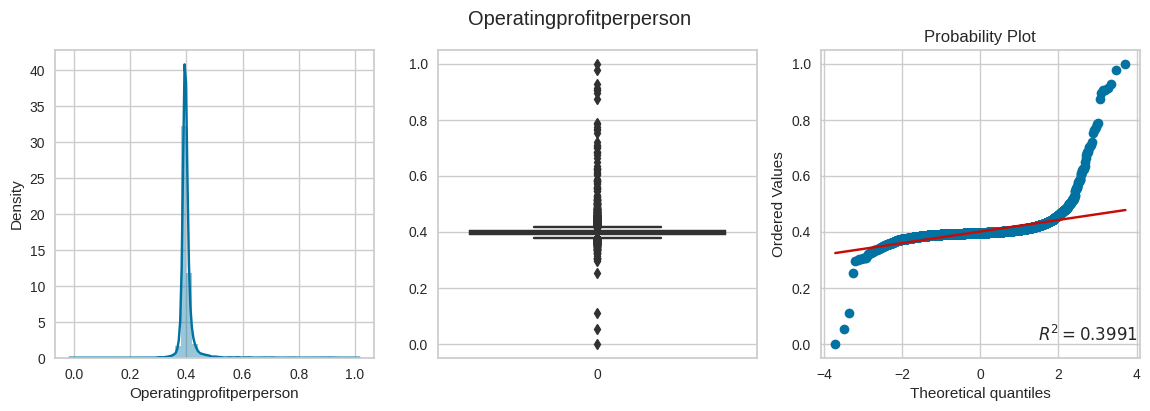

Skewness of Allocationrateperperson: 27.47614476109999
Kurtosis of Allocationrateperperson: 773.8112325412774


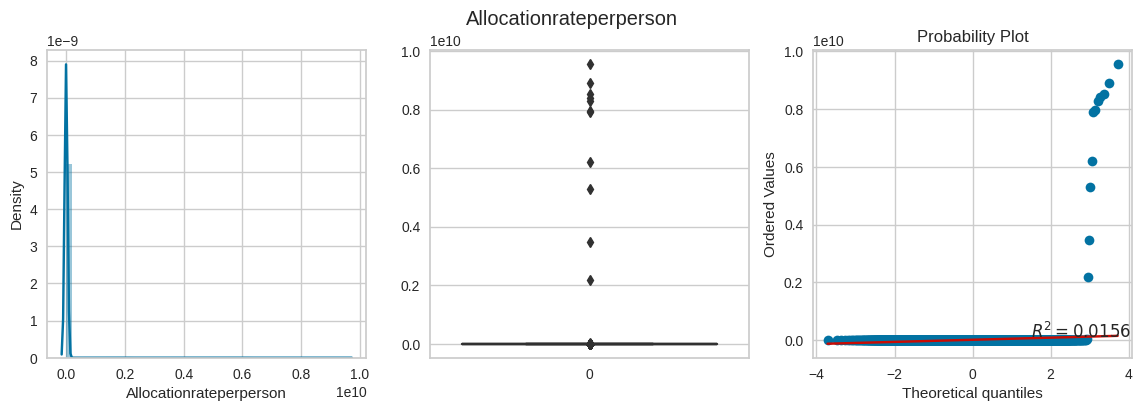

Skewness of WorkingCapitaltoTotalAssets: -0.19231134759016005
Kurtosis of WorkingCapitaltoTotalAssets: 5.5138002148064


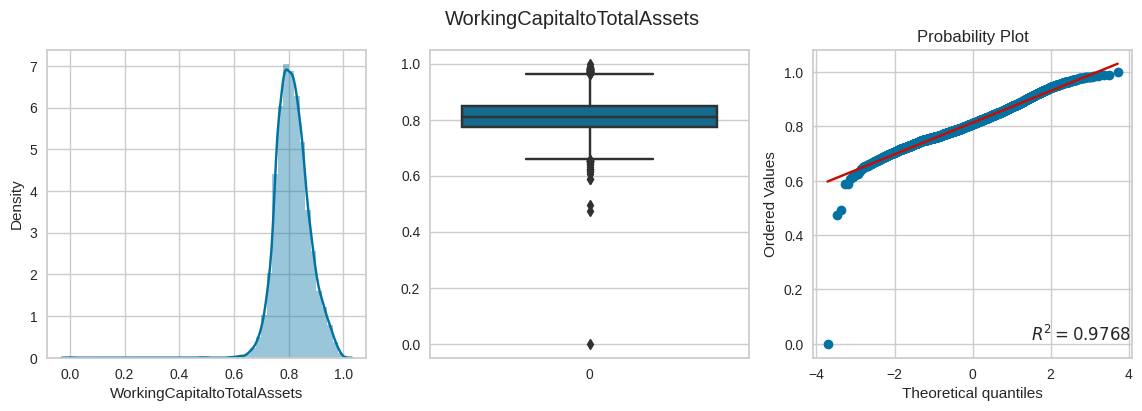

Skewness of QuickAssets/TotalAssets: 0.33731467553390343
Kurtosis of QuickAssets/TotalAssets: -0.5631275506723155


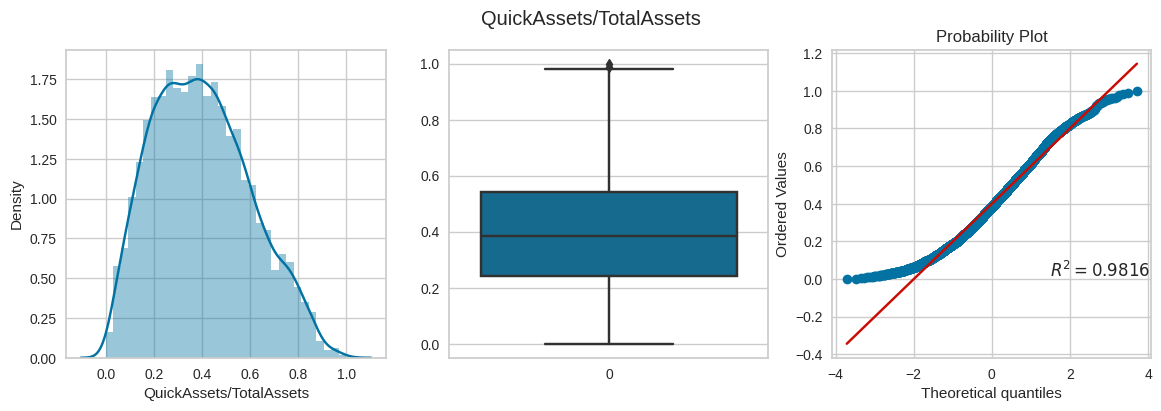

Skewness of CurrentAssets/TotalAssets: 0.07589030532976256
Kurtosis of CurrentAssets/TotalAssets: -0.8030559626739624


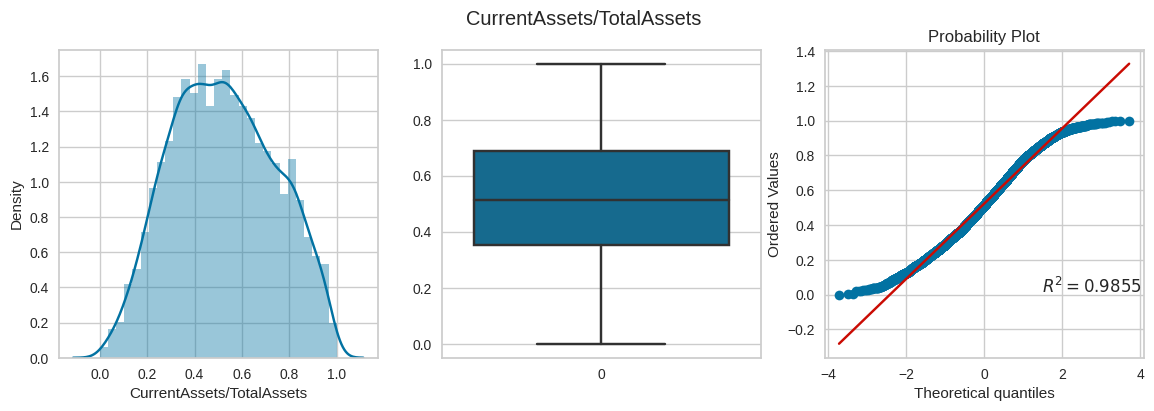

Skewness of Cash/TotalAssets: 2.2303602460630274
Kurtosis of Cash/TotalAssets: 5.90986640621092


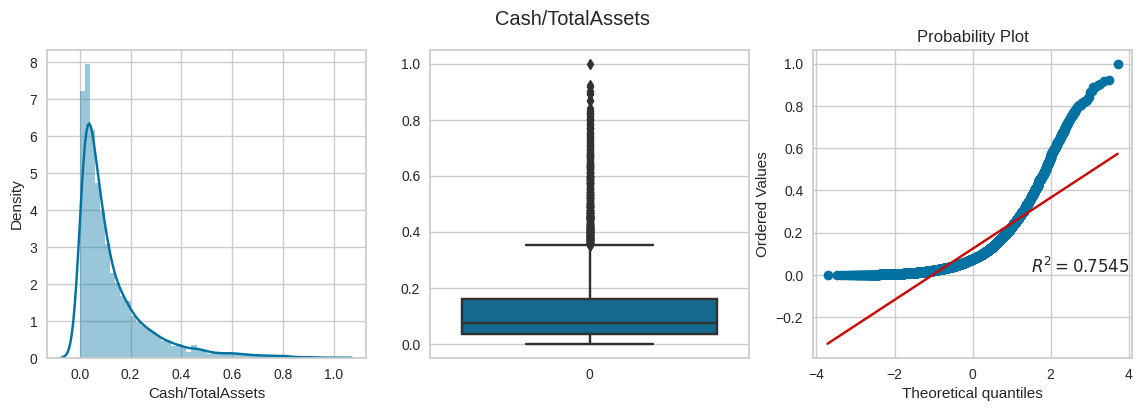

Skewness of QuickAssets/CurrentLiability: 47.94729978116933
Kurtosis of QuickAssets/CurrentLiability: 2306.8703561682737


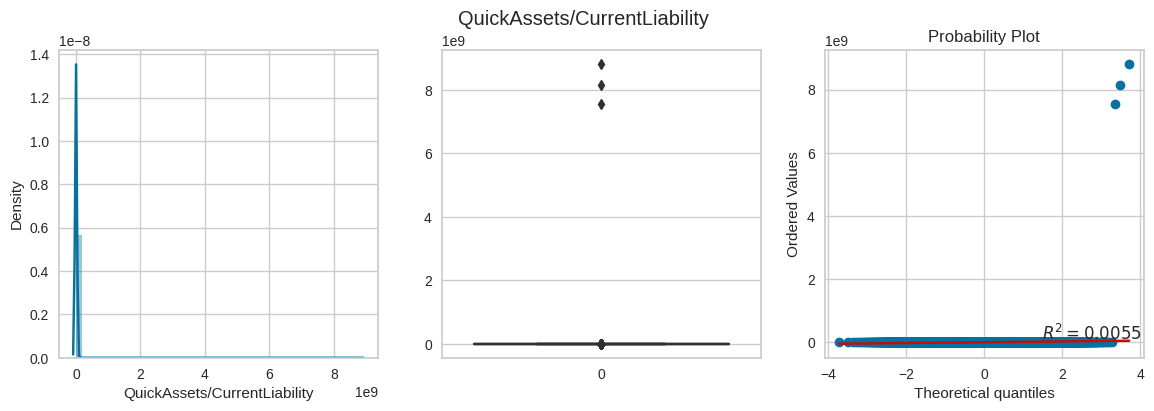

Skewness of Cash/CurrentLiability: 14.863767667730757
Kurtosis of Cash/CurrentLiability: 229.39695207189294


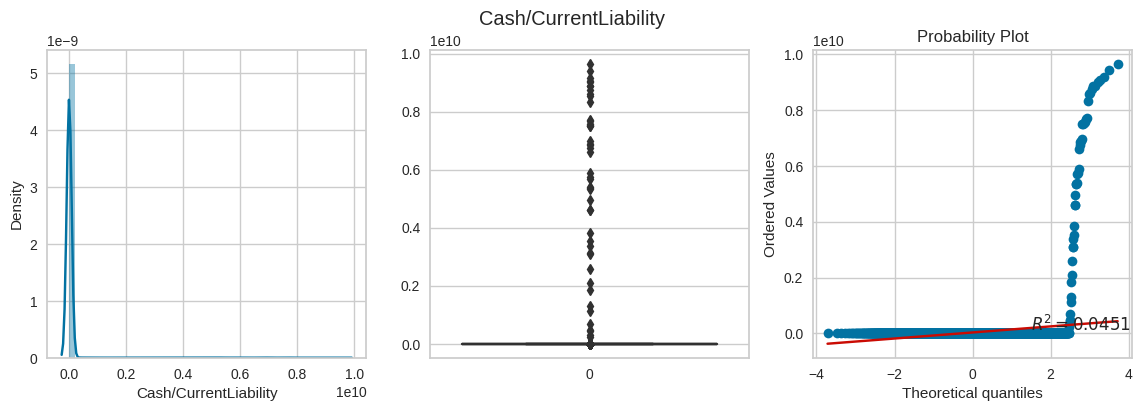

Skewness of CurrentLiabilitytoAssets: 1.6082034066471063
Kurtosis of CurrentLiabilitytoAssets: 15.870087623439169


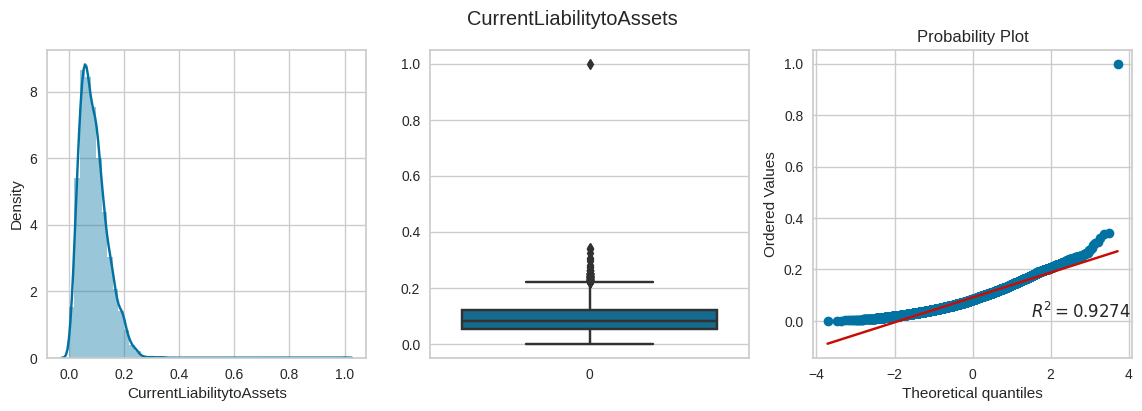

Skewness of OperatingFundstoLiability: 3.777297287701786
Kurtosis of OperatingFundstoLiability: 60.98173219547968


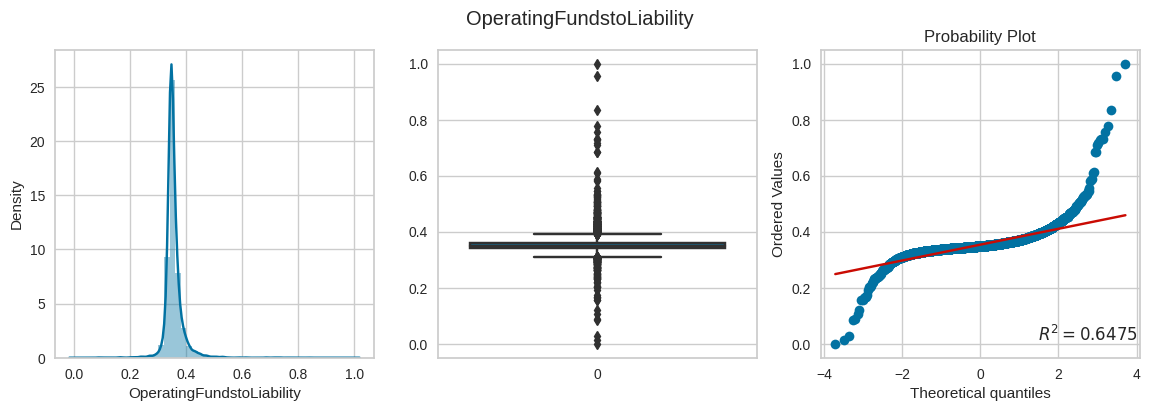

Skewness of Inventory/WorkingCapital: 45.33224964551143
Kurtosis of Inventory/WorkingCapital: 3441.470032229755


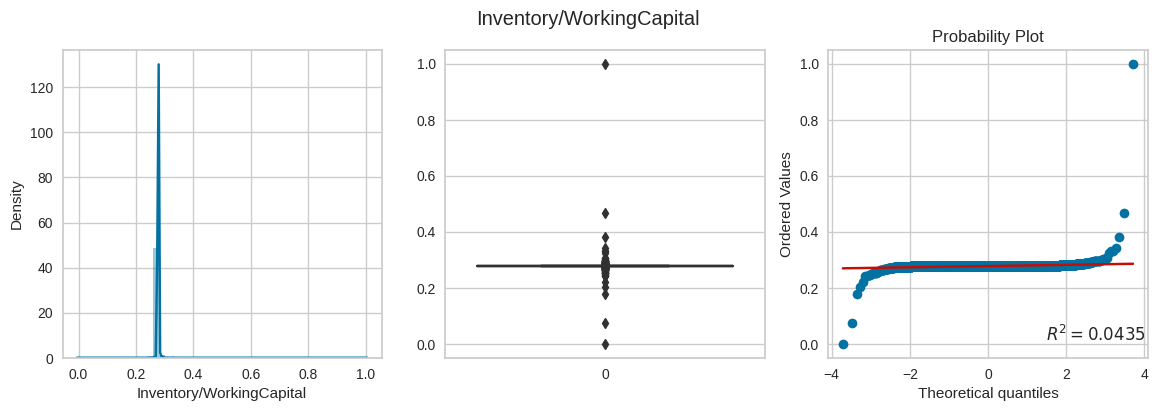

Skewness of Inventory/CurrentLiability: 11.965588148251964
Kurtosis of Inventory/CurrentLiability: 153.4177212306721


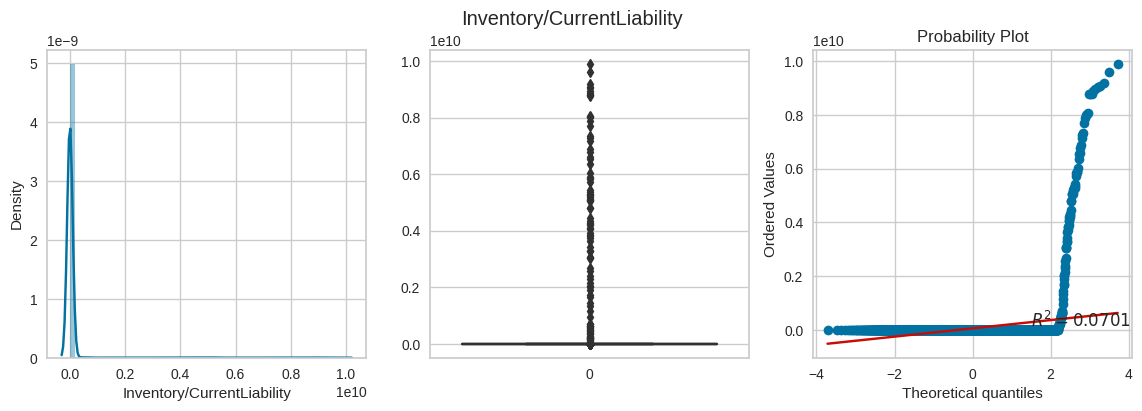

Skewness of CurrentLiabilities/Liability: -0.8350469004780781
Kurtosis of CurrentLiabilities/Liability: -0.0016292559796537986


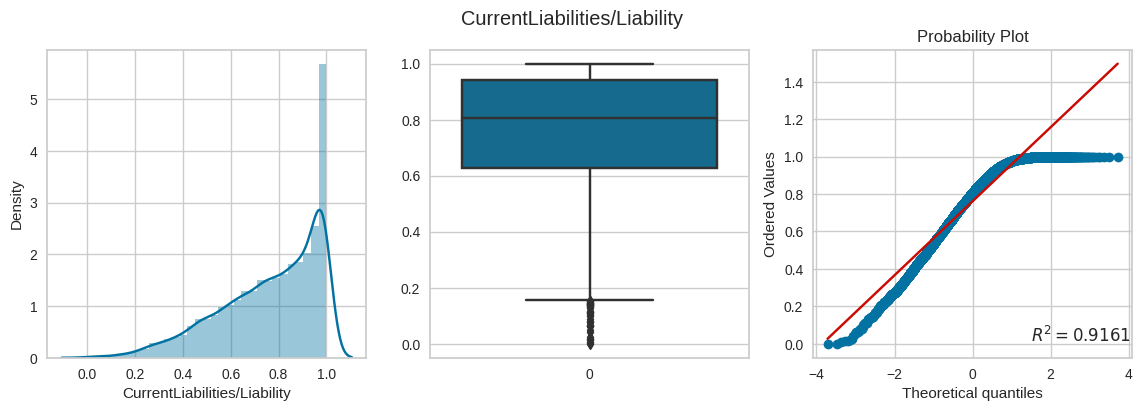

Skewness of WorkingCapital/Equity: -36.20365404366997
Kurtosis of WorkingCapital/Equity: 2412.933187437684


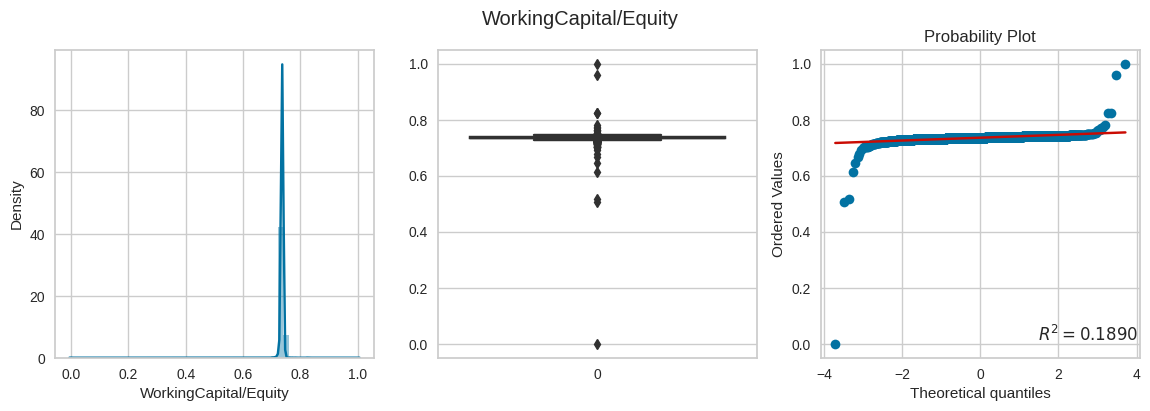

Skewness of CurrentLiabilities/Equity: 23.799164734548174
Kurtosis of CurrentLiabilities/Equity: 1171.460092252544


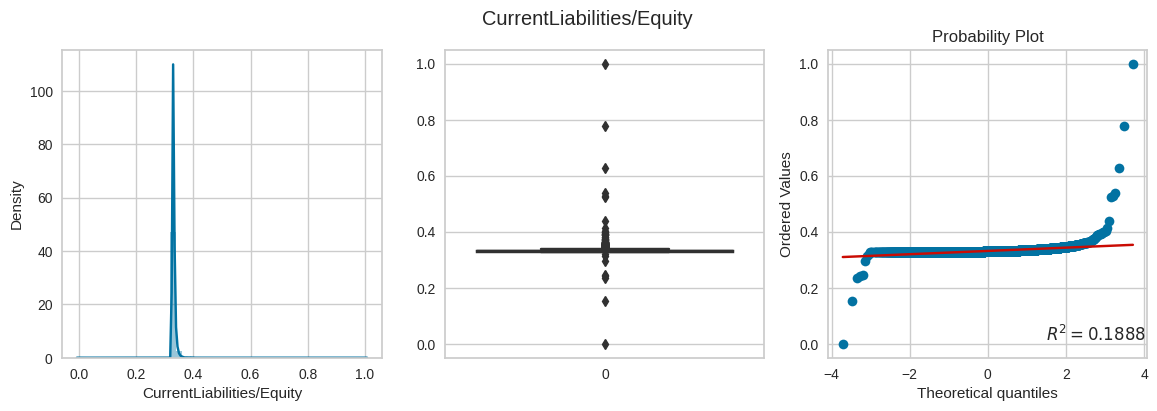

Skewness of Long-termLiabilitytoCurrentAssets: 12.401607114804376
Kurtosis of Long-termLiabilitytoCurrentAssets: 164.8900136718652


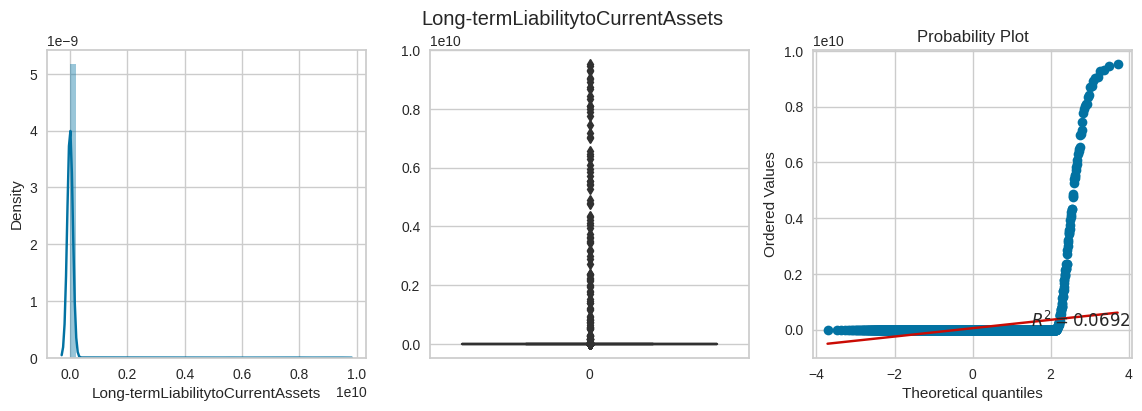

Skewness of RetainedEarningstoTotalAssets: -11.139573972107833
Kurtosis of RetainedEarningstoTotalAssets: 303.6265730895294


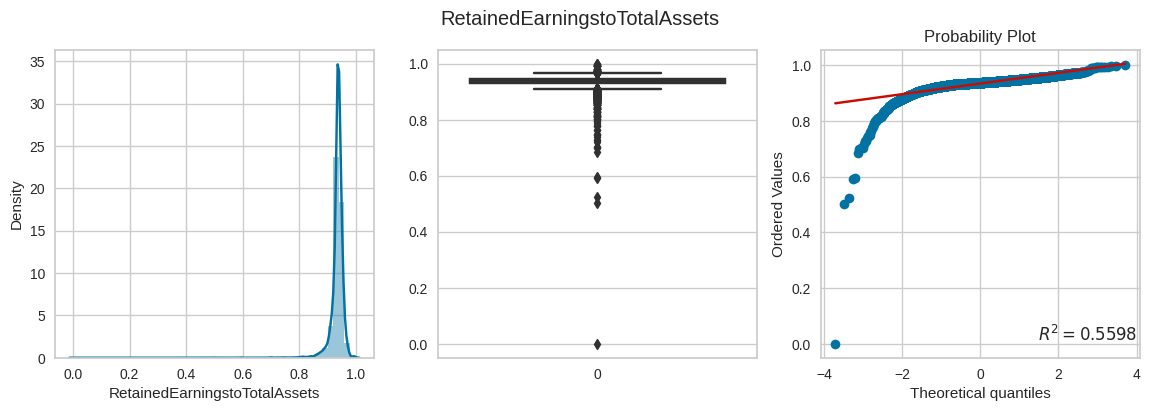

Skewness of Totalincome/Totalexpense: 82.33242377959915
Kurtosis of Totalincome/Totalexpense: 6791.883496927187


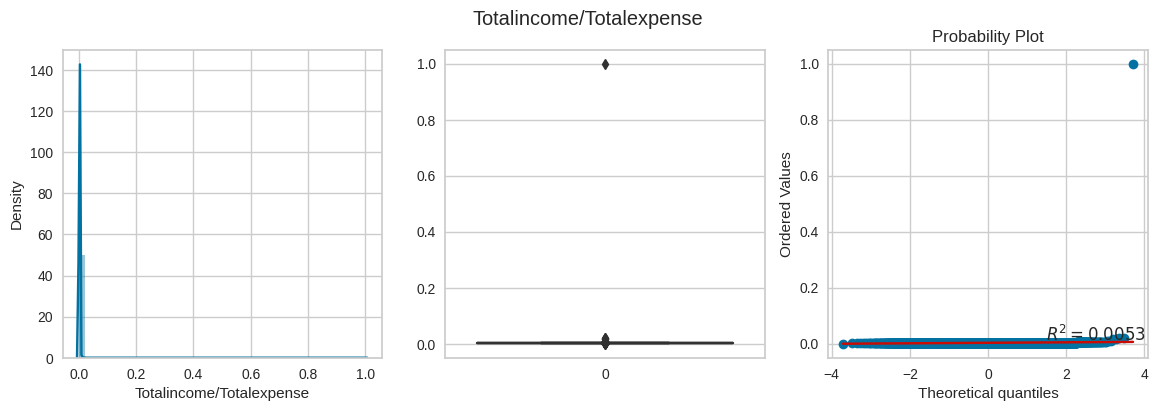

Skewness of Totalexpense/Assets: 9.481727551323877
Kurtosis of Totalexpense/Assets: 259.6642157737628


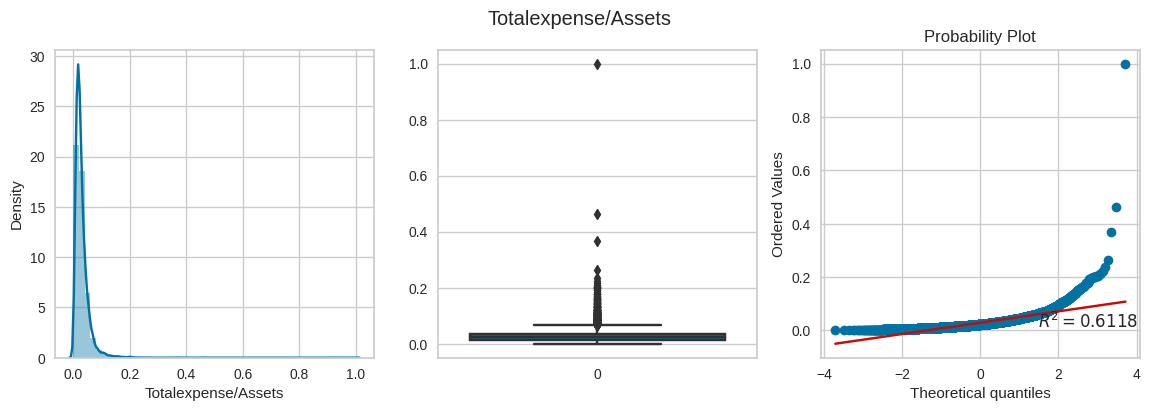

Skewness of CurrentAssetTurnoverRate: 2.1159556384021165
Kurtosis of CurrentAssetTurnoverRate: 2.793509248587132


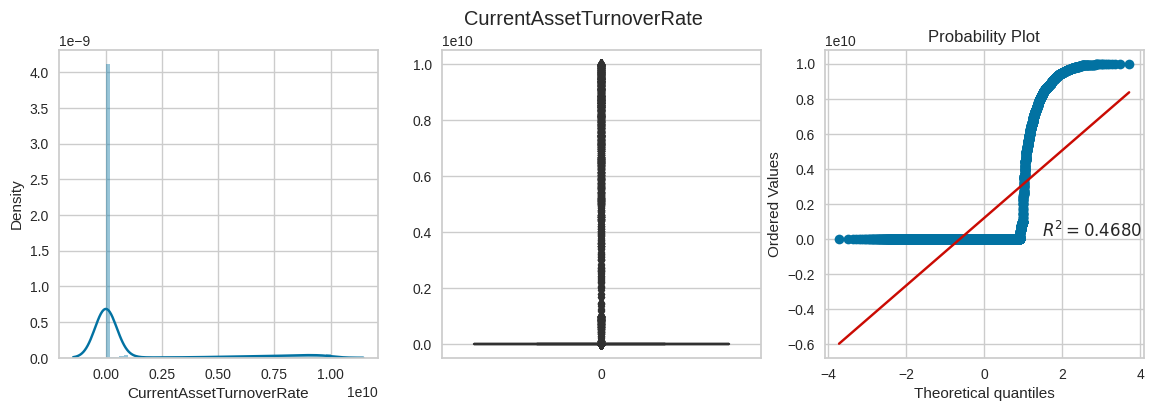

Skewness of QuickAssetTurnoverRate: 1.1373534593747237
Kurtosis of QuickAssetTurnoverRate: -0.3938953699684804


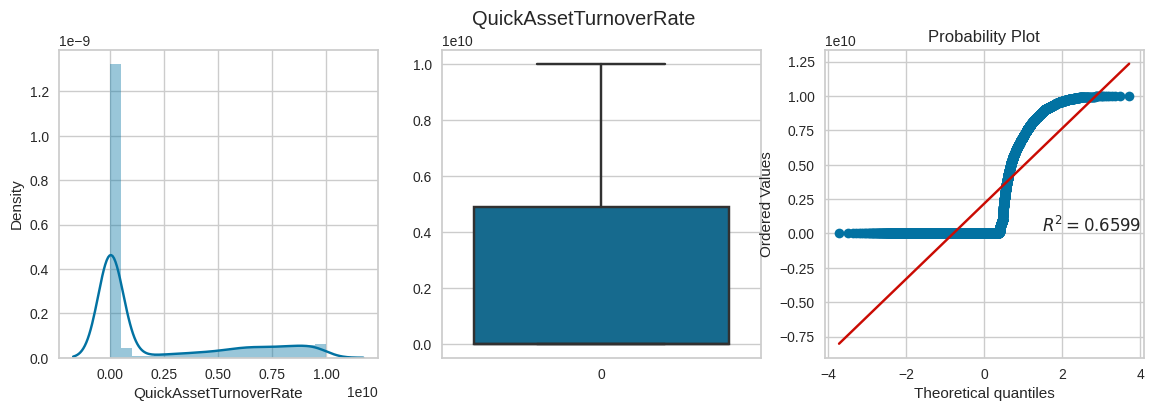

Skewness of WorkingcapitcalTurnoverRate: -28.584610631201404
Kurtosis of WorkingcapitcalTurnoverRate: 3458.06471106498


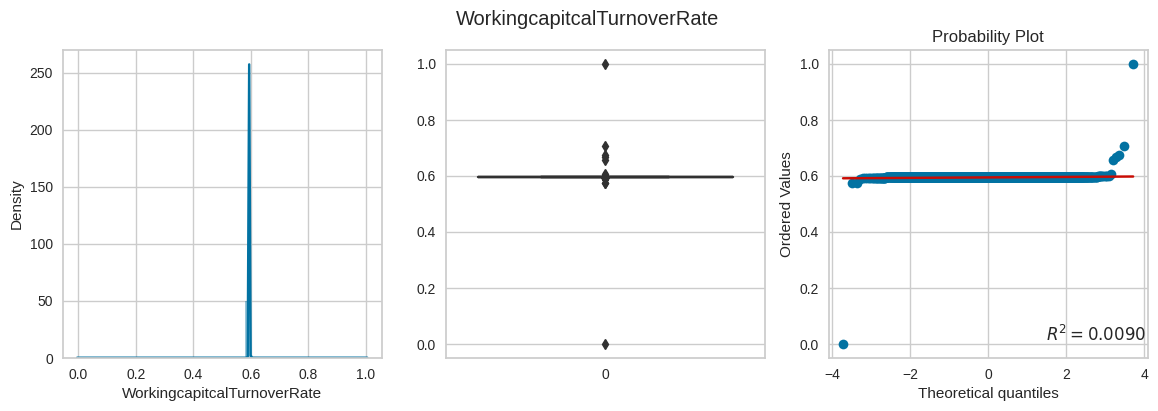

Skewness of CashTurnoverRate: 0.9541170558810121
Kurtosis of CashTurnoverRate: -0.3690317366310434


Skewness of CashFlowtoSales: -47.86911211654488
Kurtosis of CashFlowtoSales: 4153.563290206698


Skewness of FixedAssetstoAssets: 82.57723657279898
Kurtosis of FixedAssetstoAssets: 6819.000000000002


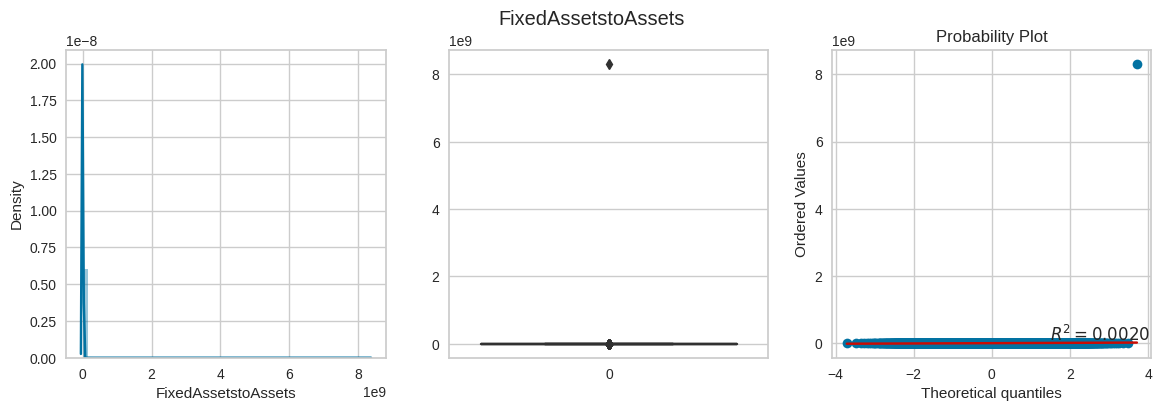

Skewness of CurrentLiabilitytoLiability: -0.8350469004780781
Kurtosis of CurrentLiabilitytoLiability: -0.0016292559796537986


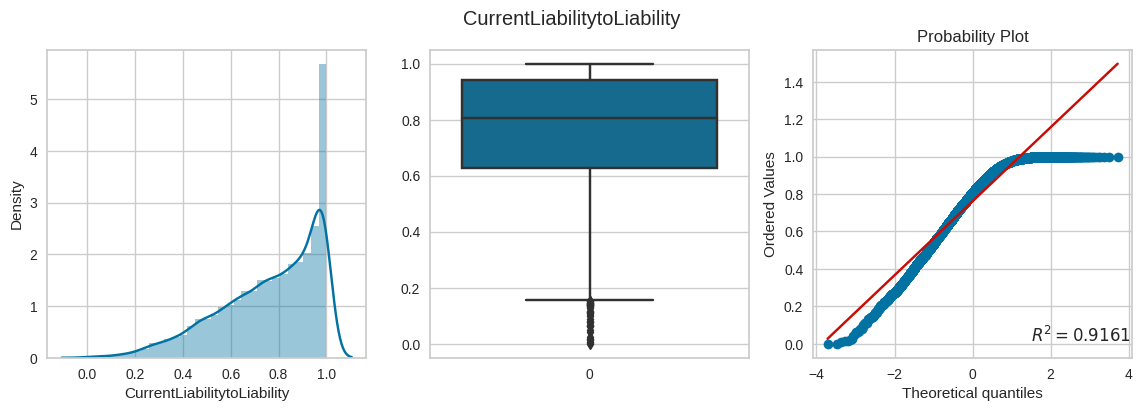

Skewness of CurrentLiabilitytoEquity: 23.799164734548174
Kurtosis of CurrentLiabilitytoEquity: 1171.460092252544


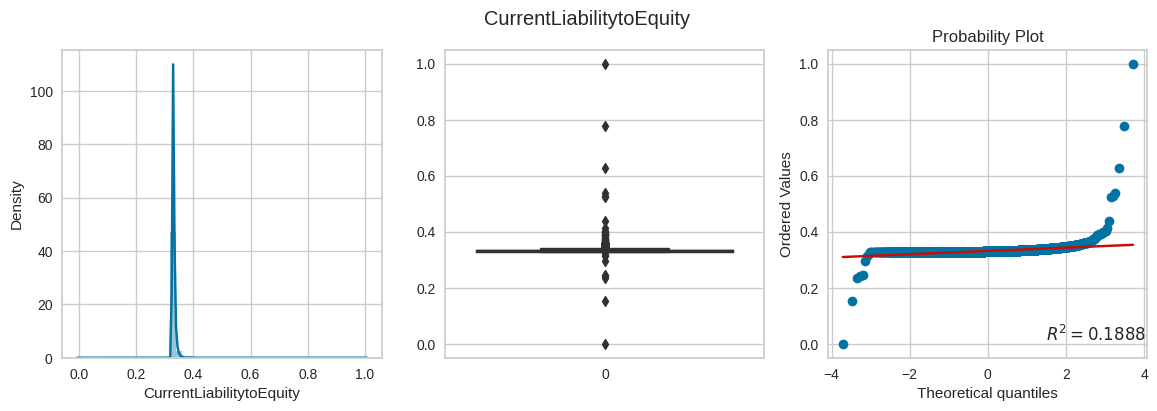

Skewness of EquitytoLong-termLiability: 33.78993963057107
Kurtosis of EquitytoLong-termLiability: 1381.155518332476


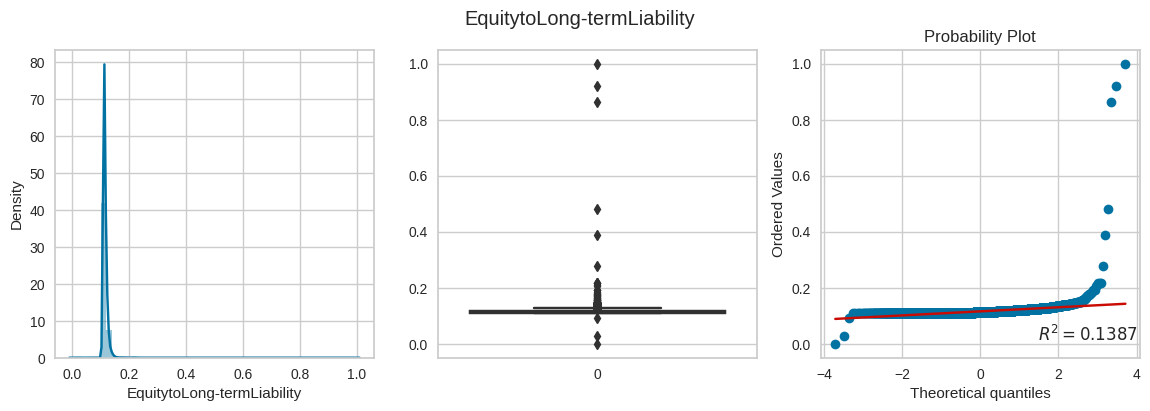

Skewness of CashFlowtoTotalAssets: -0.22815767309072998
Kurtosis of CashFlowtoTotalAssets: 16.56110253835962


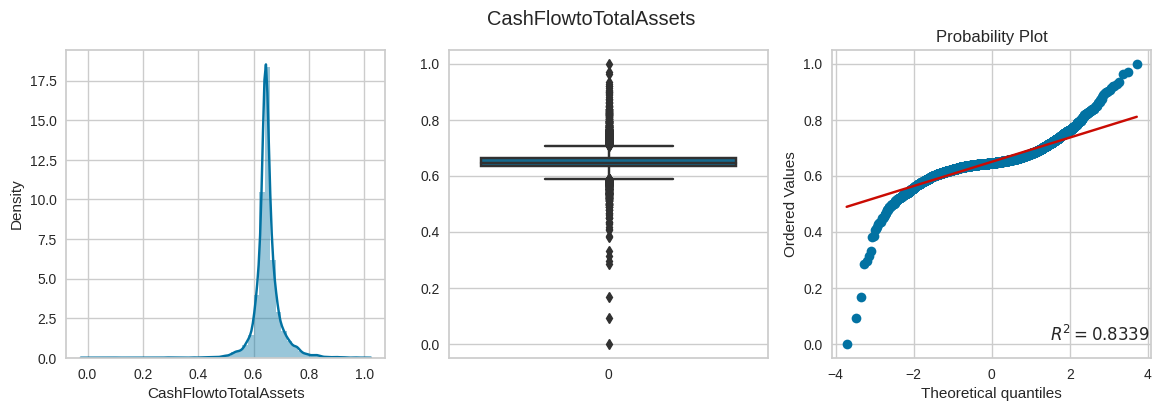

Skewness of CashFlowtoLiability: 1.0079627367748654
Kurtosis of CashFlowtoLiability: 84.85388453759073


Skewness of CFOtoAssets: -0.4437624611401986
Kurtosis of CFOtoAssets: 7.047984672693275


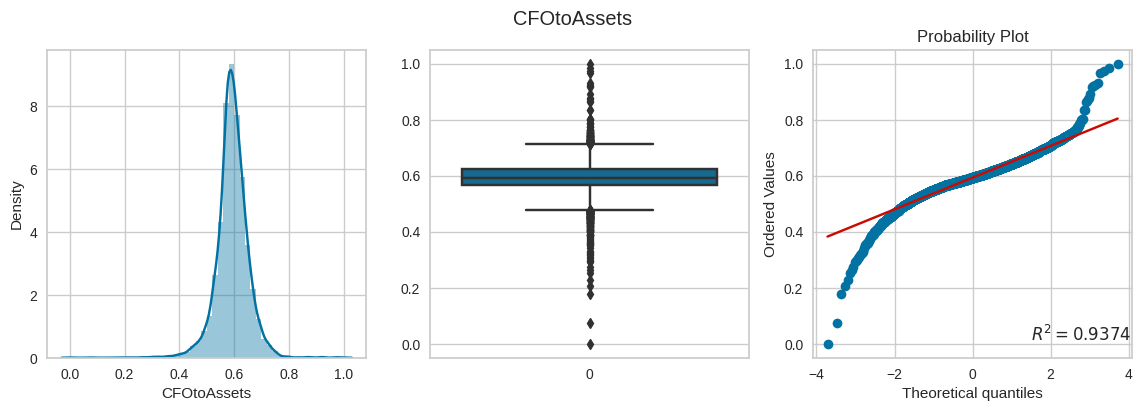

Skewness of CashFlowtoEquity: 19.943488151697377
Kurtosis of CashFlowtoEquity: 1249.738761923984


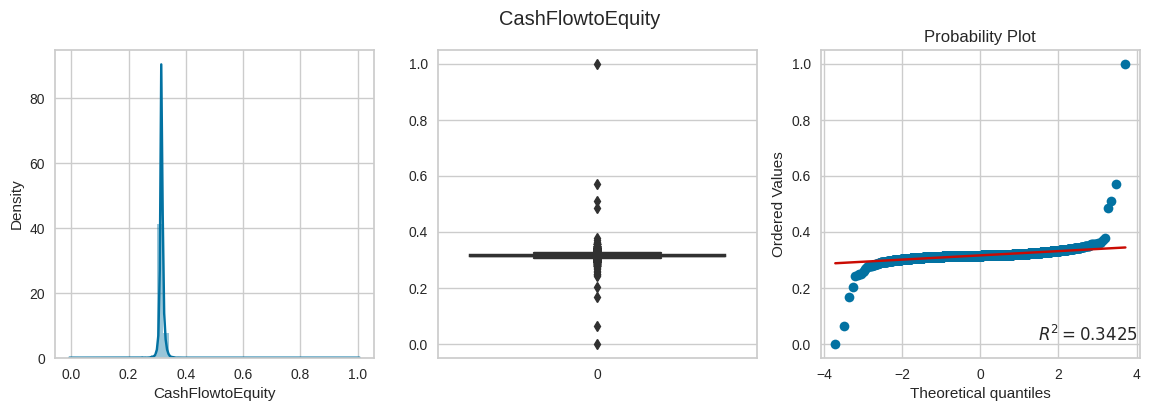

Skewness of CurrentLiabilitytoCurrentAssets: 13.188660546091514
Kurtosis of CurrentLiabilitytoCurrentAssets: 310.9992345859699


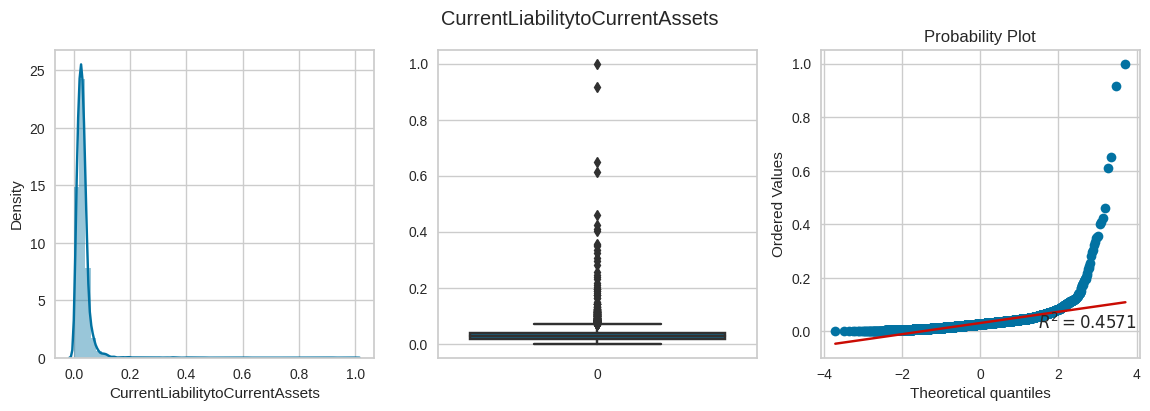

Skewness of LiabilityAssetsFlag: 29.15047171886589
Kurtosis of LiabilityAssetsFlag: 847.9987178016446


Skewness of NetIncometoTotalAssets: -3.6840967759613386
Kurtosis of NetIncometoTotalAssets: 43.73442461558547


Skewness of TotalassetstoGNPprice: 21.75898297422601
Kurtosis of TotalassetstoGNPprice: 491.14324462558903


Skewness of No-creditInterval: -11.585565139631989
Kurtosis of No-creditInterval: 1240.5333884003533


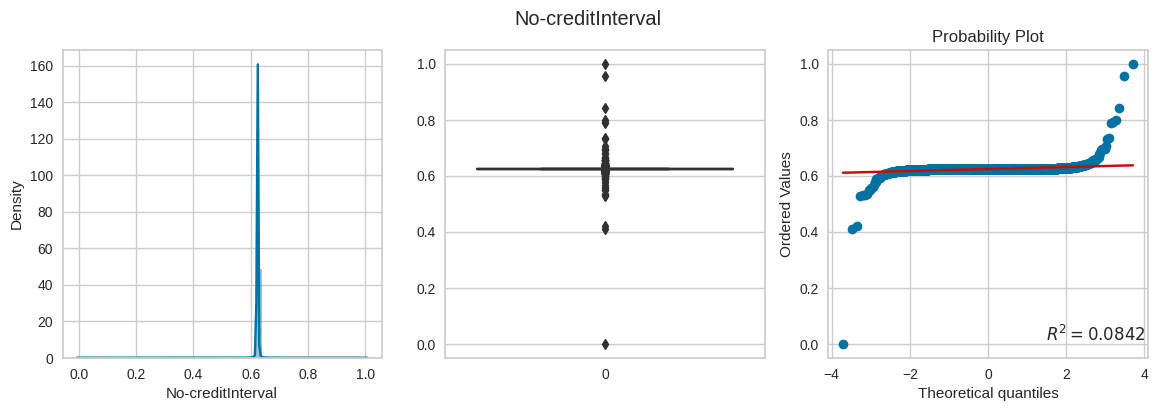

Skewness of GrossProfittoSales: -8.043224607444369
Kurtosis of GrossProfittoSales: 365.53710487381466


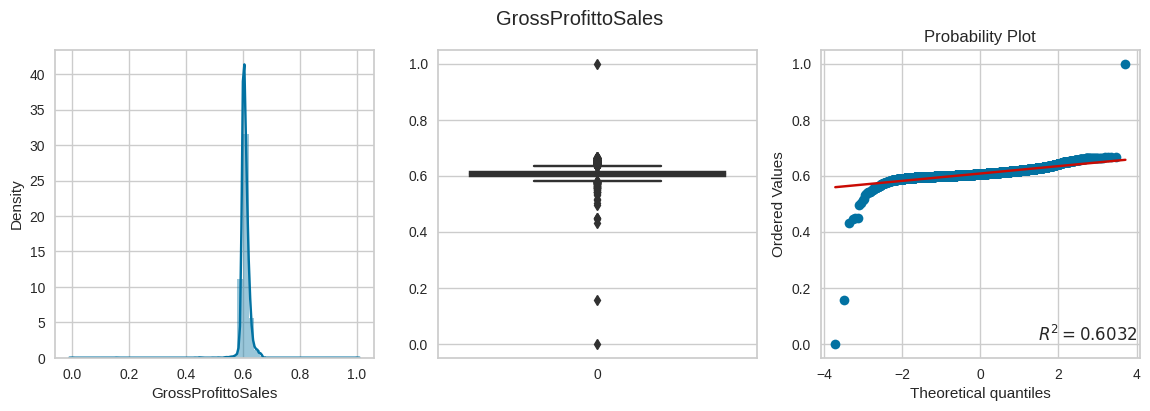

Skewness of NetIncometoStockholder'sEquity: -37.96470114027043
Kurtosis of NetIncometoStockholder'sEquity: 1944.7091685726564


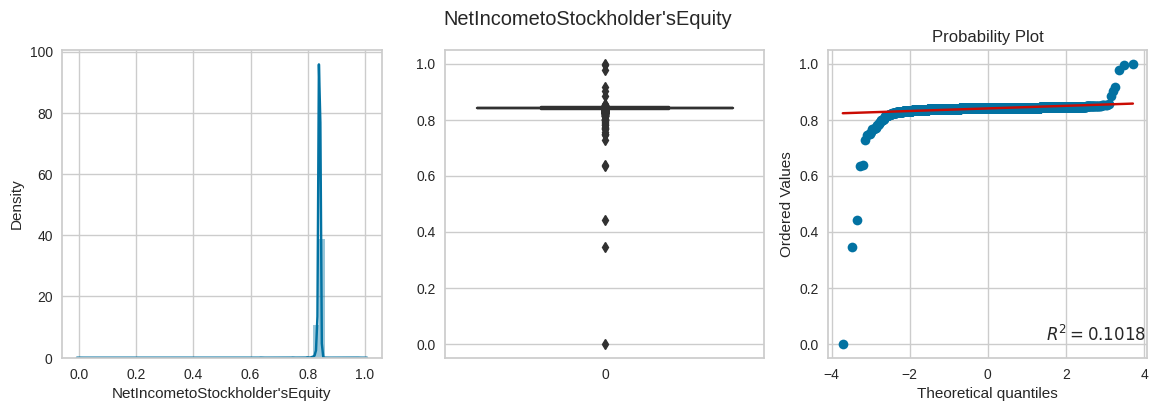

Skewness of LiabilitytoEquity: 27.4594671425143
Kurtosis of LiabilitytoEquity: 1209.2034913763239


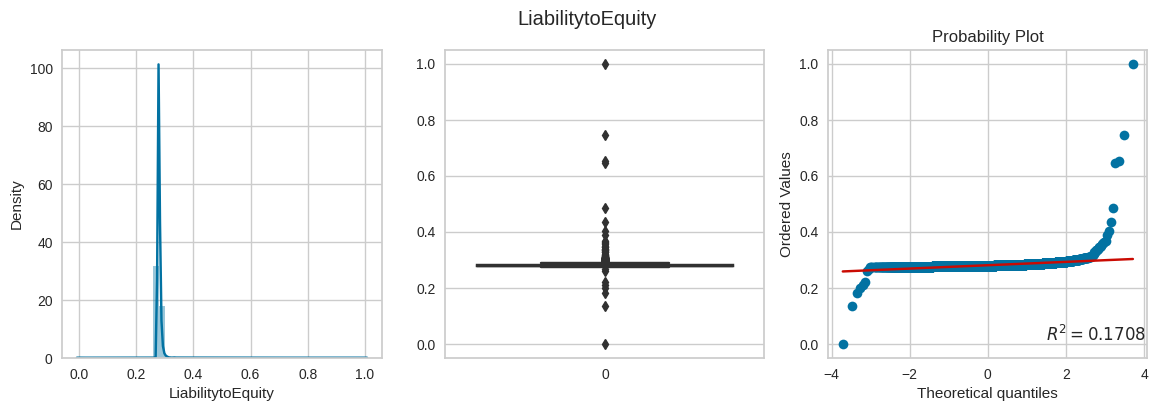

Skewness of DegreeofFinancialLeverage(DFL): 45.724197115582406
Kurtosis of DegreeofFinancialLeverage(DFL): 2475.43340394474


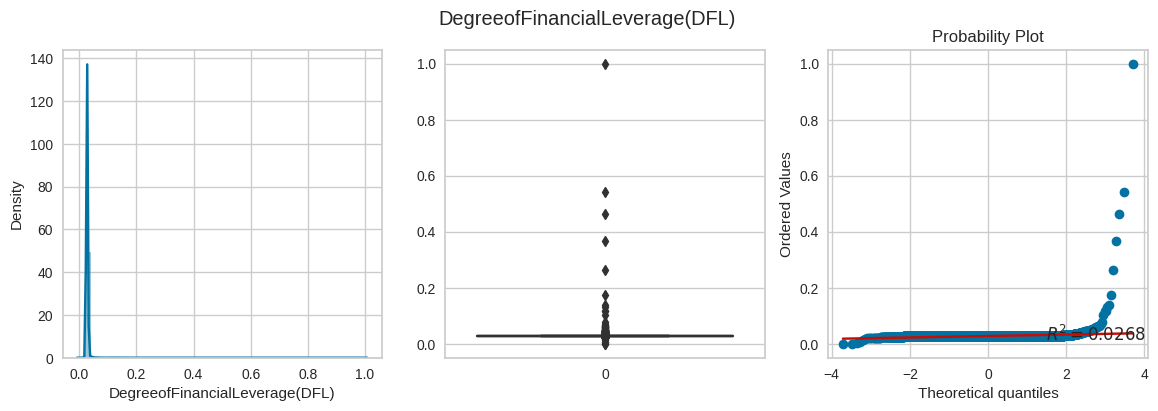

Skewness of InterestCoverageRatio(InterestexpensetoEBIT): -13.939527900794817
Kurtosis of InterestCoverageRatio(InterestexpensetoEBIT): 911.80090462008


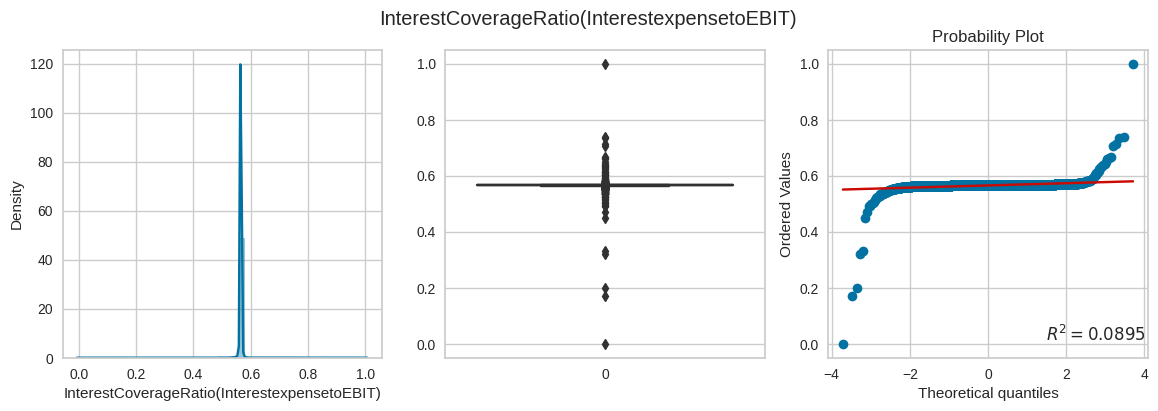

Skewness of EquitytoLiability: 7.401100836024543
Kurtosis of EquitytoLiability: 94.0661701812127


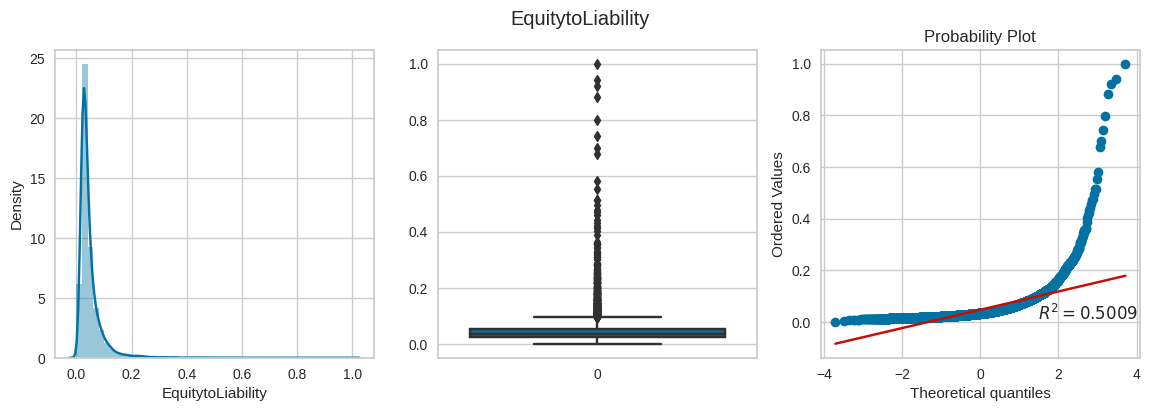

In [ ]:
for col in df.drop('Bankrupt?',axis=1).columns:
    print(f"Skewness of {col}:",df[col].skew())
    print(f"Kurtosis of {col}:",df[col].kurtosis())
    plt.figure(figsize=(14,4))
    plt.subplot(131)
    sns.distplot(df[col])
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.subplot(133)
    probplot(df[col],rvalue=True,plot=plt,dist='norm')
    plt.suptitle(col)
    plt.show()
    gc.collect()

In [ ]:
bankrupt_count = df['Bankrupt?'].value_counts()
bankrupt_count

0    6599
1     220
Name: Bankrupt?, dtype: int64

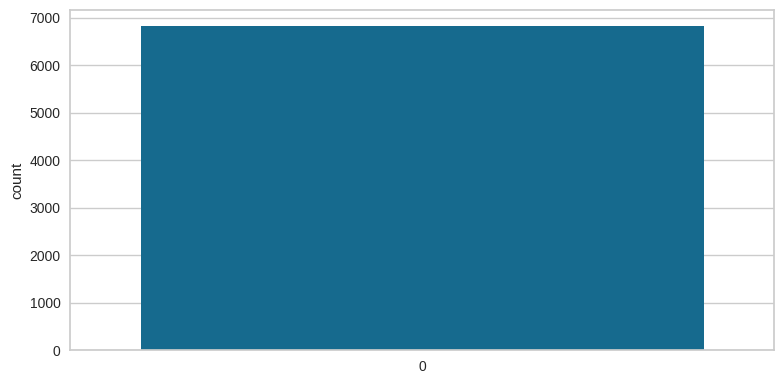

In [ ]:
plt.figure(figsize=(8,4))
fig = sns.countplot(df['Bankrupt?'])
# plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout()
plt.show(fig)
plt.close('all')
del fig
gc.collect();




The target class "Bankrupt?" is highly imbalanced with only a marginal number of companies getting bankrupted. The imbalanced classes need to be balanced out later as they may affect the performance of machine learning algorithms.

## Feature Engineering

### Feature Splitting

In [ ]:
X = df.drop('Bankrupt?',axis=1)
y = df['Bankrupt?']

### Data Preprocessing

In [ ]:
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

X = pipeline.fit_transform(X)
X.shape

(6819, 69)

### Outlier Removal

In [ ]:
def remove_outliers(data,col):
    winsorizer = Winsorizer(capping_method='iqr',tail='both',fold=1.5)
    data[col] = winsorizer.fit_transform(data[[col]])
    return data[col]

In [ ]:
for col in X.drop('LiabilityAssetsFlag',axis=1).columns:
    X[col] = remove_outliers(X,col)

In [ ]:
X.shape

(6819, 69)

NO outliers observed here

### Balancing out imbalanced target labels

In [ ]:
smote = BorderlineSMOTE()
X, y = smote.fit_resample(X, y)

In [ ]:
print("Final dimensions of target label classes:", Counter(y))

Final dimensions of target label classes: Counter({1: 6599, 0: 6599})


In [ ]:
X.shape

(13198, 69)

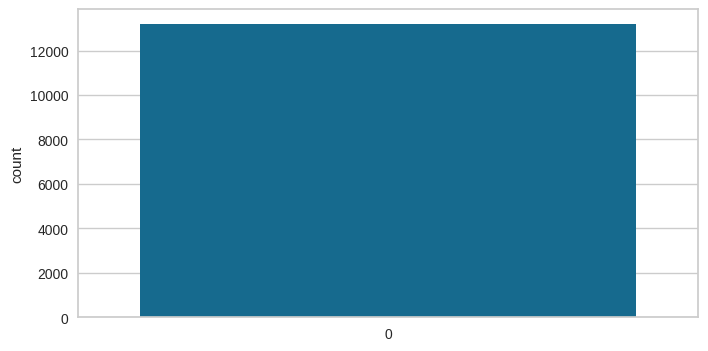

In [ ]:
plt.figure(figsize=(8,4))
fig = sns.countplot(y)
# plt.tight_layout()
plt.show(fig)
# plt.close('all')
del fig
# gc.collect();

Now, the target classes are perfectly balanced.

### Performing train-test-split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,shuffle=True,random_state=58)

### Feature Selection

In [ ]:
kbest = SelectKBest(k=10,score_func=chi2)
kbest.fit(X_train,y_train)

SelectKBest(score_func=<function chi2 at 0x7e8cb2ad1870>)

In [ ]:
selected_features = kbest.get_feature_names_out()
selected_features

array(['OperatingExpenseRate', 'Researchanddevelopmentexpenserate',
       'Taxrate(A)', 'TotalAssetGrowthRate', 'Debtratio%',
       'InventoryTurnoverRate(times)', 'QuickAssets/TotalAssets',
       'Cash/TotalAssets', 'QuickAssetTurnoverRate', 'CashTurnoverRate'],
      dtype=object)

In [ ]:
perc = SelectPercentile(percentile=25,score_func=chi2)
perc.fit(X_train,y_train)

SelectPercentile(percentile=25, score_func=<function chi2 at 0x7e8cb2ad1870>)

In [ ]:
selected_features = perc.get_feature_names_out()
selected_features

array(['ROA(C)beforeinterestanddepreciationbeforeinterest',
       'OperatingExpenseRate', 'Researchanddevelopmentexpenserate',
       'Taxrate(A)', 'TotalAssetGrowthRate', 'QuickRatio',
       'Totaldebt/Totalnetworth', 'Debtratio%', 'TotalAssetTurnover',
       'InventoryTurnoverRate(times)', 'QuickAssets/TotalAssets',
       'Cash/TotalAssets', 'QuickAssetTurnoverRate', 'CashTurnoverRate',
       'FixedAssetstoAssets', 'CurrentLiabilitytoCurrentAssets',
       'EquitytoLiability'], dtype=object)

In [ ]:
rf = SelectFromModel(estimator=RandomForestClassifier(),max_features=10)
rf.fit(X_train,y_train)

SelectFromModel(estimator=RandomForestClassifier(), max_features=10)

In [ ]:
selected_features = rf.get_feature_names_out()
selected_features

array(['ROA(C)beforeinterestanddepreciationbeforeinterest',
       'PersistentEPSintheLastFourSeasons', 'NetValueGrowthRate',
       'QuickRatio', 'Totaldebt/Totalnetworth', 'Debtratio%',
       'Borrowingdependency', 'RetainedEarningstoTotalAssets',
       'Totalincome/Totalexpense', 'EquitytoLiability'], dtype=object)

In [ ]:
rfe = RFE(estimator=RandomForestClassifier(),n_features_to_select=10,step=4,verbose=2)
rfe.fit(X_train,y_train)

Fitting estimator with 69 features.
Fitting estimator with 65 features.
Fitting estimator with 61 features.
Fitting estimator with 57 features.
Fitting estimator with 53 features.
Fitting estimator with 49 features.
Fitting estimator with 45 features.
Fitting estimator with 41 features.
Fitting estimator with 37 features.
Fitting estimator with 33 features.
Fitting estimator with 29 features.
Fitting estimator with 25 features.
Fitting estimator with 21 features.
Fitting estimator with 17 features.
Fitting estimator with 13 features.


RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=4,
    verbose=2)

In [ ]:
selected_features = rfe.get_feature_names_out()
selected_features

array(['ROA(C)beforeinterestanddepreciationbeforeinterest',
       'PersistentEPSintheLastFourSeasons', 'NetValueGrowthRate',
       'Totaldebt/Totalnetworth', 'Debtratio%', 'Borrowingdependency',
       'RetainedEarningstoTotalAssets', 'Totalincome/Totalexpense',
       'CashTurnoverRate', 'EquitytoLiability'], dtype=object)

In [ ]:
sfs = SequentialFeatureSelector(estimator=RandomForestClassifier(),n_features_to_select=10,direction='forward')
sfs.fit(X_train,y_train)

KeyboardInterrupt: ignored

In [ ]:
selected_features = sfs.get_feature_names_out()
selected_features

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

In [ ]:
def plot_feature_importances(feat_imp_type):
    feat_imps = xgb.get_booster().get_score(importance_type=feat_imp_type)
    keys = list(feat_imps.keys())
    values = list(feat_imps.values())
    feat_imps_df = pd.DataFrame(data=values, index=keys, columns=["Importance"]).sort_values(by="Importance", ascending=False).reset_index()
    feat_imps_df.rename({'index': 'Feature'},axis=1,inplace=True)
    plt.figure(figsize=(12,8))
    fig = sns.barplot(x='Importance',y='Feature',data=feat_imps_df[:10],orient='horizontal',palette='viridis')
    plt.title(f"{feat_imp_type.title()} Feature Importance")
    plt.show(fig)
    plt.close('all')
    del fig
    gc.collect();

In [ ]:
final_selected_features = ['WorkingCapital/Equity',
                           'PersistentEPSintheLastFourSeasons',
                           'Borrowingdependency',
                           'NetValueGrowthRate',
                           'Interest-bearingdebtinterestrate',
                           'ROA(C)beforeinterestanddepreciationbeforeinterest',
                           'Cash/TotalAssets',
                           'Non-industryincomeandexpenditure/revenue',
                           'NetValuePerShare(B)',
                           'Totaldebt/Totalnetworth']

final_X_train = X_train[final_selected_features]
final_X_test = X_test[final_selected_features]

In [ ]:
renamed_cols = {'Borrowingdependency': 'BorrowingDependency',
                'Interest-bearingdebtinterestrate': 'InterestBearingDebtInterestRate',
                'ROA(C)beforeinterestanddepreciationbeforeinterest': 'ROA(C)BeforeInterestAndDepreciationBeforeInterest',
                'Non-industryincomeandexpenditure/revenue': 'NonIndustryIncomeAndExpenditure/Revenue',
                'Totaldebt/Totalnetworth': 'TotalDebt/TotalNetWorth'}

final_X_train.rename(renamed_cols,axis=1,inplace=True)
final_X_test.rename(renamed_cols,axis=1,inplace=True)

In [ ]:
gc.collect()

447

### Feature Scaling

In [ ]:
features

Index(['WorkingCapital/Equity', 'PersistentEPSintheLastFourSeasons',
       'BorrowingDependency', 'NetValueGrowthRate',
       'InterestBearingDebtInterestRate',
       'ROA(C)BeforeInterestAndDepreciationBeforeInterest', 'Cash/TotalAssets',
       'NonIndustryIncomeAndExpenditure/Revenue', 'NetValuePerShare(B)',
       'TotalDebt/TotalNetWorth'],
      dtype='object')

In [ ]:
scaler = StandardScaler()
features = final_X_train.columns
final_X_train = scaler.fit_transform(final_X_train)
final_X_train = pd.DataFrame(final_X_train,columns=features)
final_X_test = scaler.transform(final_X_test)
final_X_test = pd.DataFrame(final_X_test,columns=features)
final_X_train.head()

WorkingCapital/Equity  PersistentEPSintheLastFourSeasons  \
0              -0.549655                           0.309706   
1               0.966343                           0.025700   
2               1.104171                           0.576253   
3              -0.310392                           0.211711   
4               0.297798                          -0.407620   

   BorrowingDependency  NetValueGrowthRate  InterestBearingDebtInterestRate  \
0            -0.562655            0.168286                         0.340899   
1             0.952227            0.446648                         1.335162   
2            -0.222984           -0.153288                        -0.292772   
3            -0.844870            0.140619                        -0.040106   
4            -1.353792           -0.510949                        -0.368973   

   ROA(C)BeforeInterestAndDepreciationBeforeInterest  Cash/TotalAssets  \
0                                           0.199172         -0.840211   
1                                          -0.182783         -0.793252   
2                                           0.452613         -0.289727   
3                                           0.055584          0.435122   
4                                          -1.100902          0.291874   

   NonIndustryIncomeAndExpenditure/Revenue  NetValuePerShare(B)  \
0                                 2.295091             0.353386   
1                                 2.051305             1.038567   
2                                 0.462786             0.313017   
3                                 0.677282             1.431071   
4                                 0.922680            -0.520697   

   TotalDebt/TotalNetWorth  
0                -0.952567  
1                 0.227137  
2                -0.662494  
3                -1.242176  
4                -1.743141

In [ ]:
final_X_train.shape

(9238, 10)

In [ ]:
final_X_test.head()

WorkingCapital/Equity  PersistentEPSintheLastFourSeasons  \
0               0.692806                           1.489570   
1              -1.073344                          -1.041965   
2               0.745447                           0.305786   
3              -1.349247                          -1.327750   
4              -0.468502                          -1.278503   

   BorrowingDependency  NetValueGrowthRate  InterestBearingDebtInterestRate  \
0            -1.244918            0.495473                        -0.982591   
1            -0.350134           -1.136483                         1.336126   
2            -0.509289            0.216402                         0.417100   
3             1.251381           -1.232646                        -0.517396   
4             1.395712           -1.230143                        -0.734177   

   ROA(C)BeforeInterestAndDepreciationBeforeInterest  Cash/TotalAssets  \
0                                           1.394583          0.551562   
1                                          -0.815203          0.982805   
2                                           0.527867         -0.095017   
3                                          -1.470496          0.374189   
4                                          -1.286797         -0.533892   

   NonIndustryIncomeAndExpenditure/Revenue  NetValuePerShare(B)  \
0                                 0.226477             1.425805   
1                                -0.611446            -0.863938   
2                                 0.499141             0.530660   
3                                -1.247729            -1.515290   
4                                -0.356996            -1.182269   

   TotalDebt/TotalNetWorth  
0                -1.413090  
1                -0.529716  
2                -0.921267  
3                 1.172779  
4                 1.382157

## Model Training & Evaluation

In [ ]:
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

In [ ]:
def train_and_evaluate_model(model):
    model.fit(final_X_train,y_train)
    y_pred = model.predict(final_X_test)
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print('-'*50)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    PrecisionRecallDisplay.from_predictions(y_test,y_pred)
    RocCurveDisplay.from_predictions(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')
    roc_auc = roc_auc_score(y_test,y_pred,average='macro')

    if re.search('catboost',str(model)) == None:
        visualizer = ClassPredictionError(model)
        visualizer.score(final_X_test,y_test)
        visualizer.show()
        del visualizer

    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    models.append(model)
    del acc, precision, recall, f1, roc_auc
    gc.collect()

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1999
           1       0.90      0.92      0.91      1961

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

--------------------------------------------------


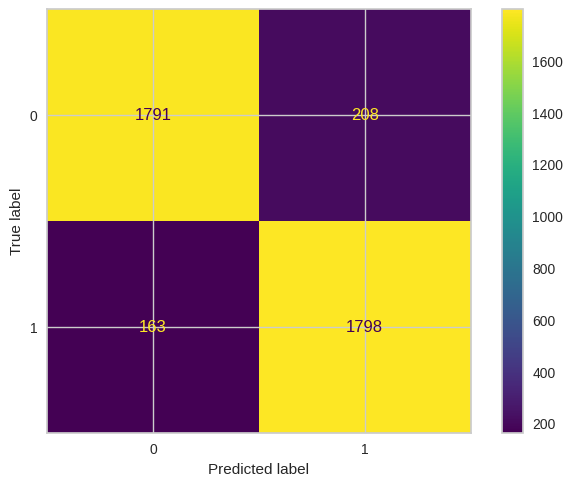

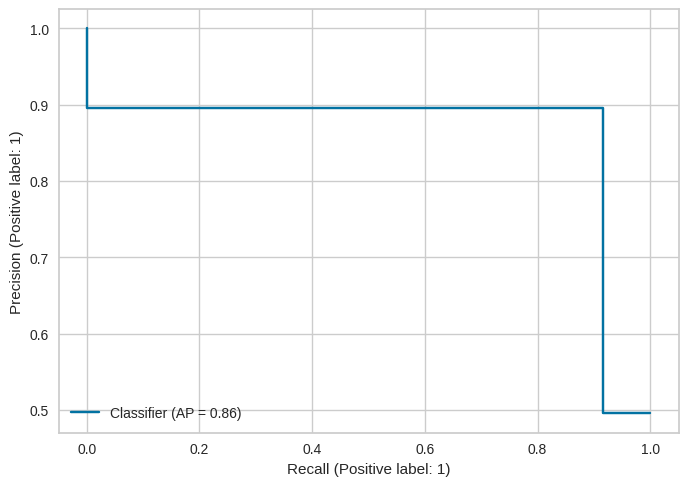

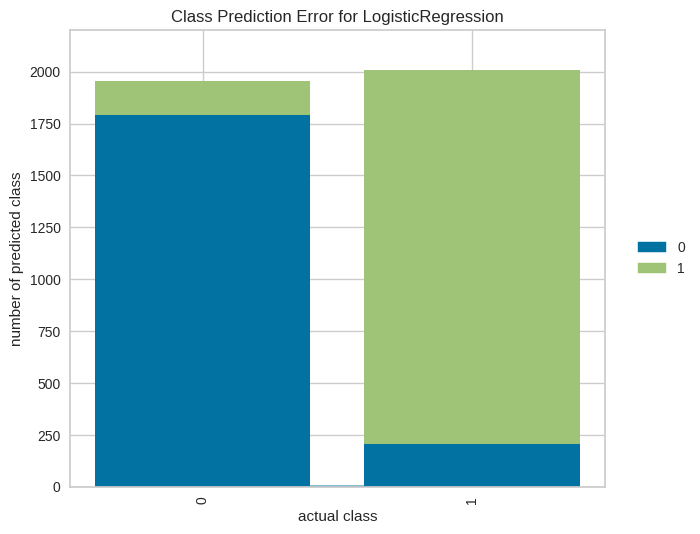

In [ ]:
train_and_evaluate_model(LogisticRegression())

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1999
           1       0.83      0.94      0.88      1961

    accuracy                           0.88      3960
   macro avg       0.88      0.88      0.88      3960
weighted avg       0.88      0.88      0.88      3960

--------------------------------------------------


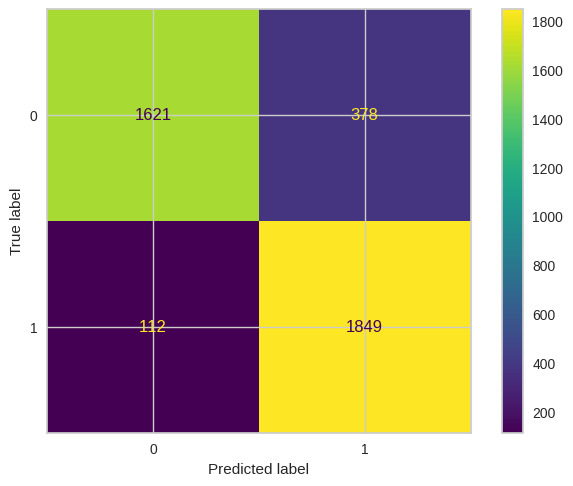

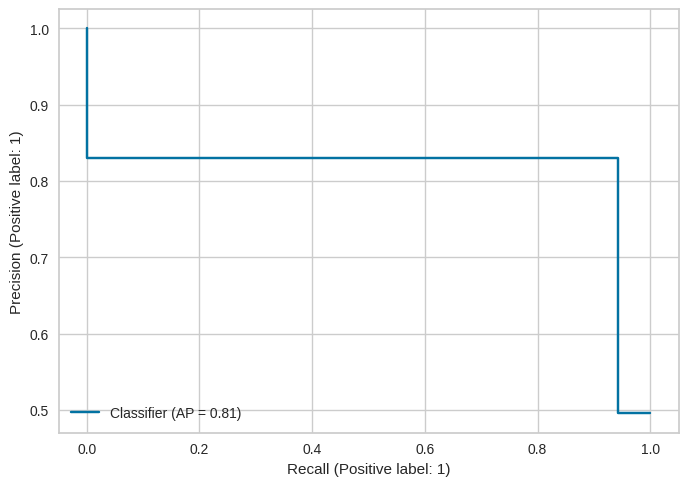

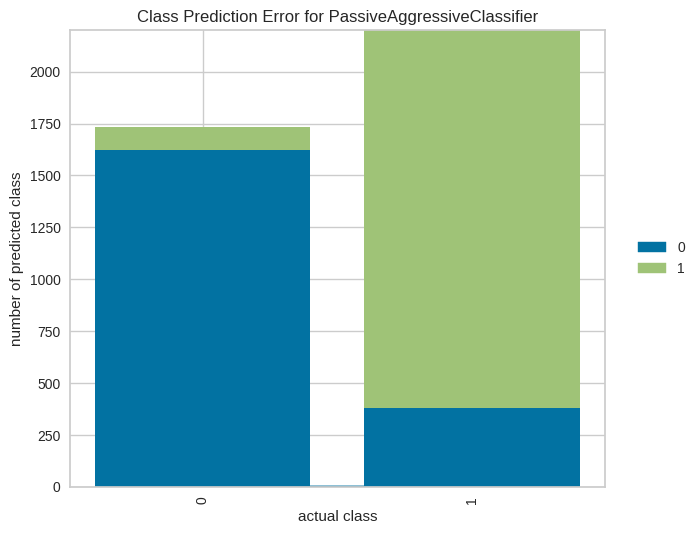

In [ ]:
train_and_evaluate_model(PassiveAggressiveClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1999
           1       0.89      0.90      0.90      1961

    accuracy                           0.90      3960
   macro avg       0.90      0.90      0.90      3960
weighted avg       0.90      0.90      0.90      3960

--------------------------------------------------


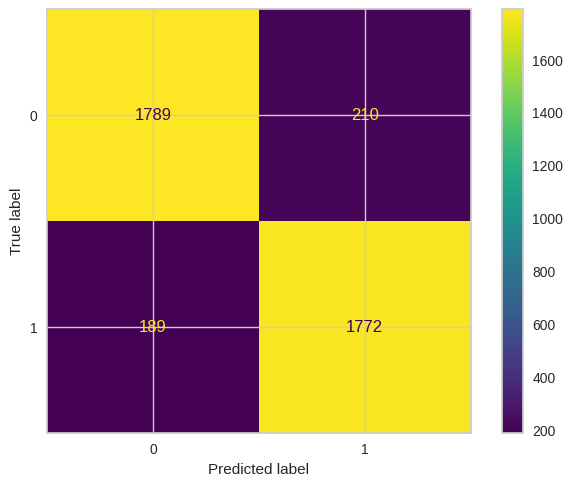

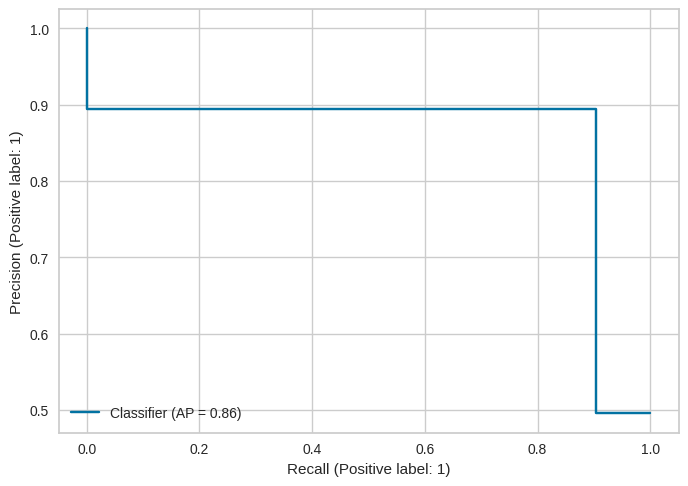

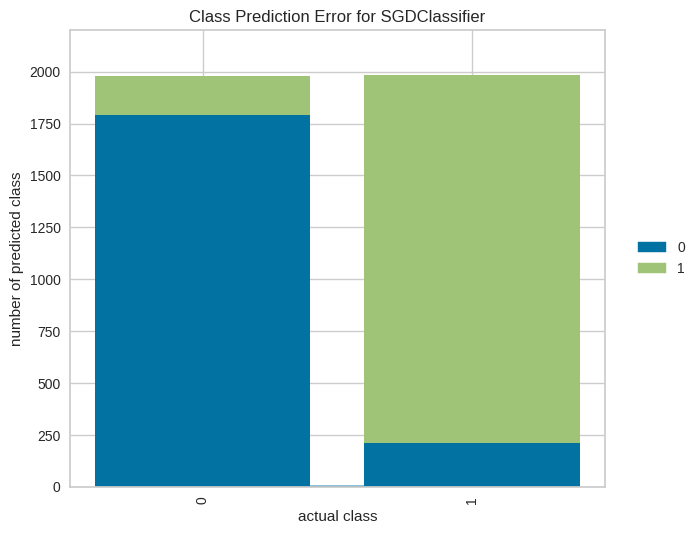

In [ ]:
train_and_evaluate_model(SGDClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      1999
           1       0.88      0.93      0.90      1961

    accuracy                           0.90      3960
   macro avg       0.90      0.90      0.90      3960
weighted avg       0.90      0.90      0.90      3960

--------------------------------------------------


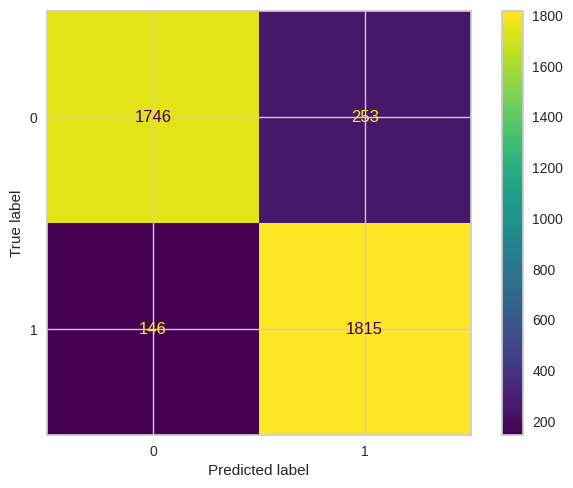

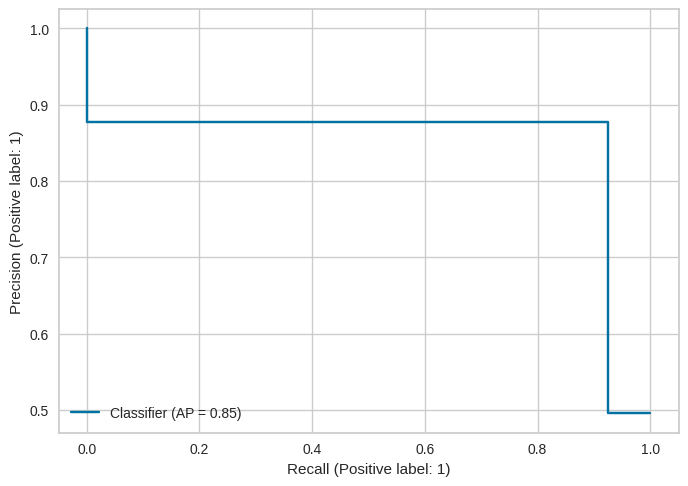

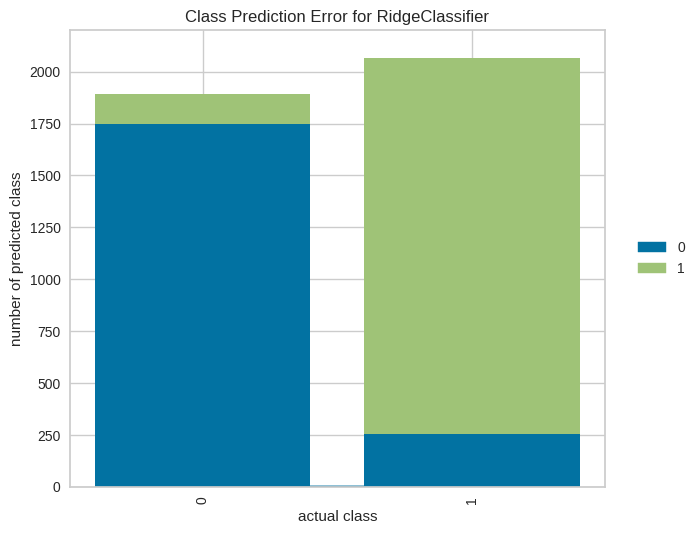

In [ ]:
train_and_evaluate_model(RidgeClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      1999
           1       0.93      0.99      0.96      1961

    accuracy                           0.96      3960
   macro avg       0.96      0.96      0.96      3960
weighted avg       0.96      0.96      0.96      3960

--------------------------------------------------


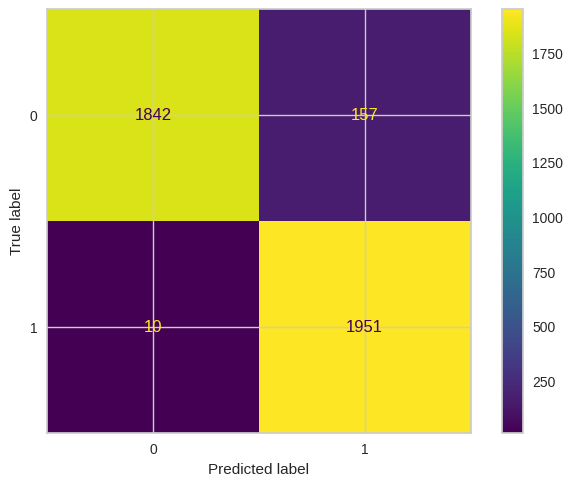

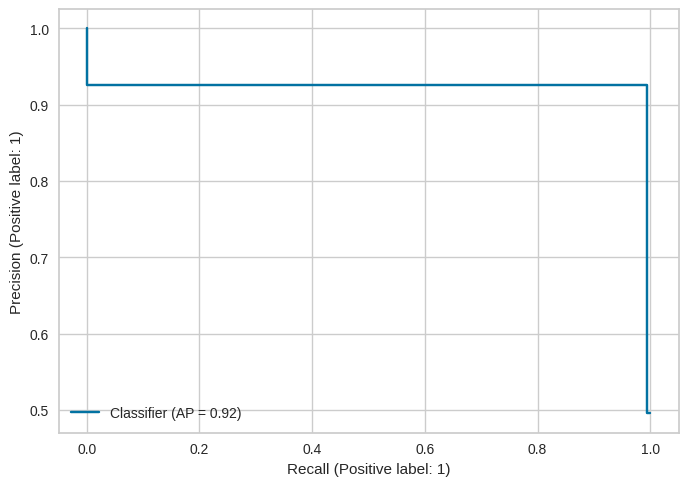

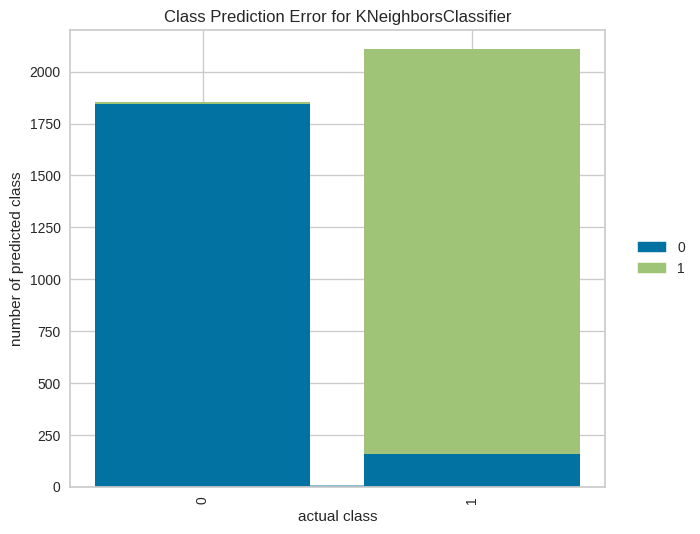

In [ ]:
train_and_evaluate_model(KNeighborsClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1999
           1       0.88      0.90      0.89      1961

    accuracy                           0.89      3960
   macro avg       0.89      0.89      0.89      3960
weighted avg       0.89      0.89      0.89      3960

--------------------------------------------------


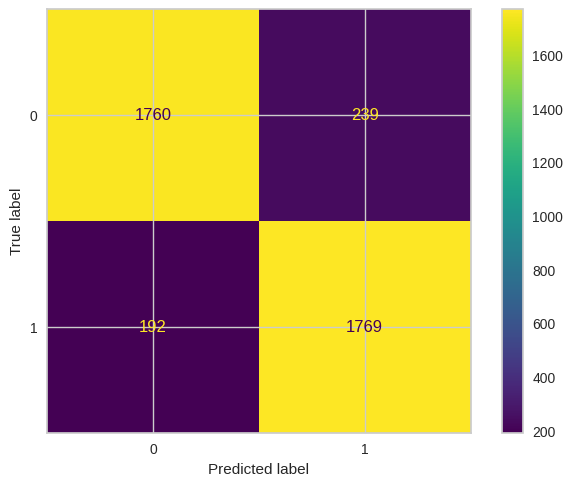

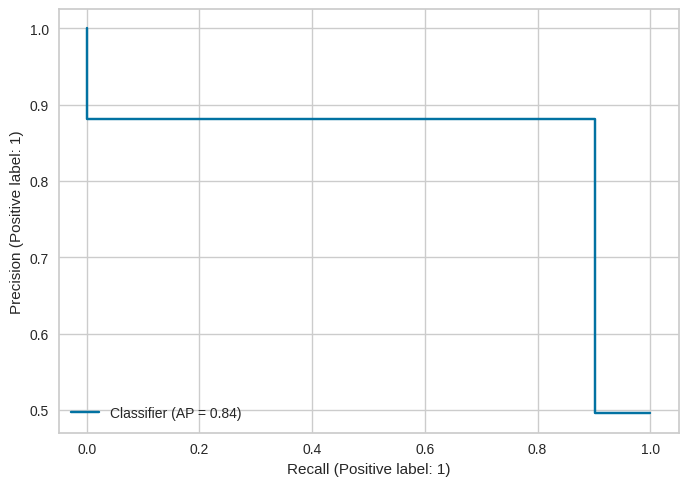

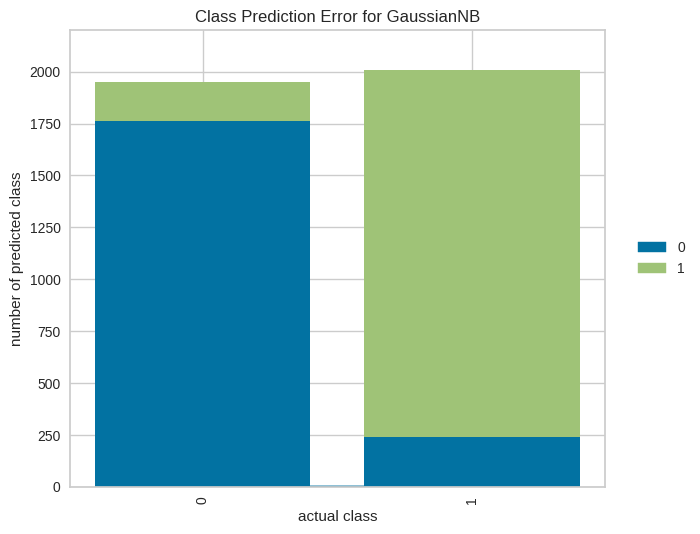

In [ ]:
train_and_evaluate_model(GaussianNB())

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1999
           1       0.87      0.90      0.89      1961

    accuracy                           0.89      3960
   macro avg       0.89      0.89      0.89      3960
weighted avg       0.89      0.89      0.89      3960

--------------------------------------------------


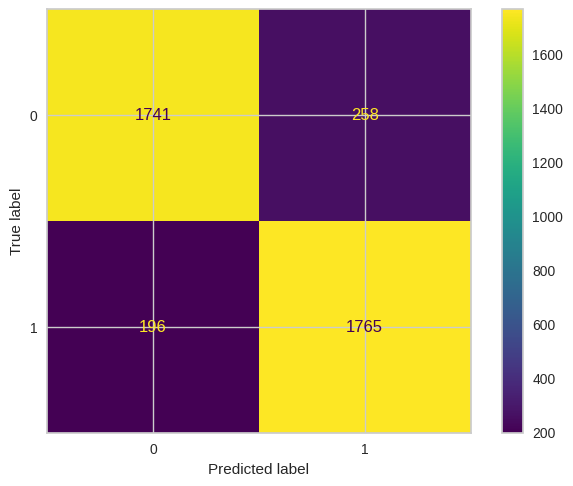

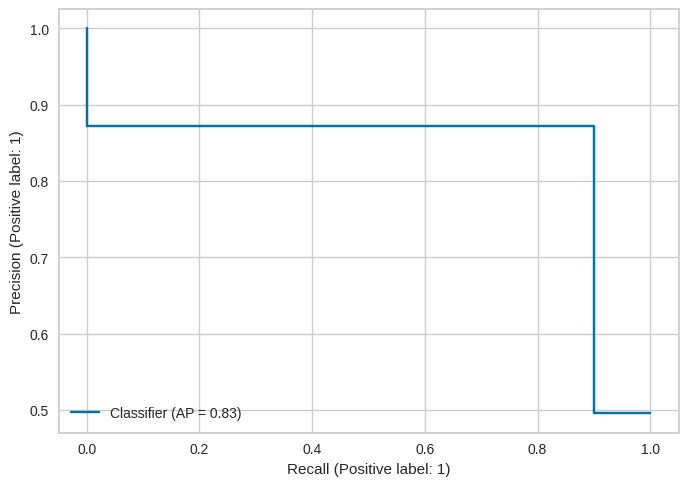

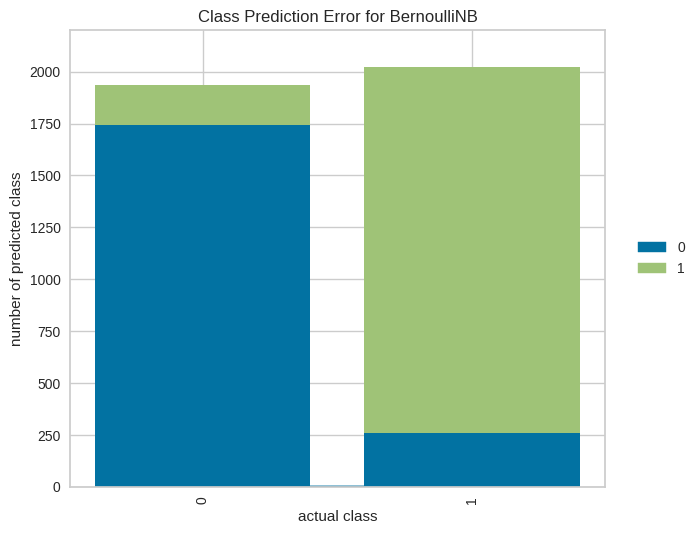

In [ ]:
train_and_evaluate_model(BernoulliNB())

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1999
           1       0.92      0.96      0.94      1961

    accuracy                           0.94      3960
   macro avg       0.94      0.94      0.94      3960
weighted avg       0.94      0.94      0.94      3960

--------------------------------------------------


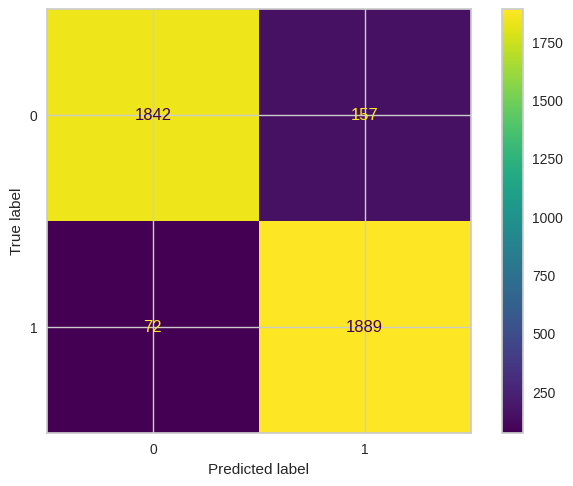

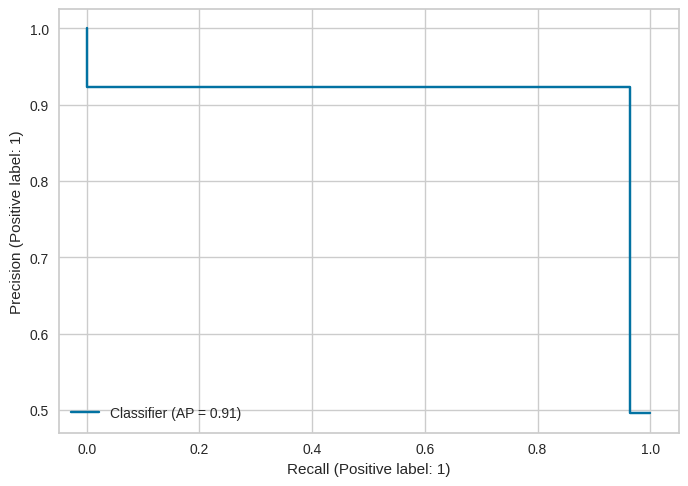

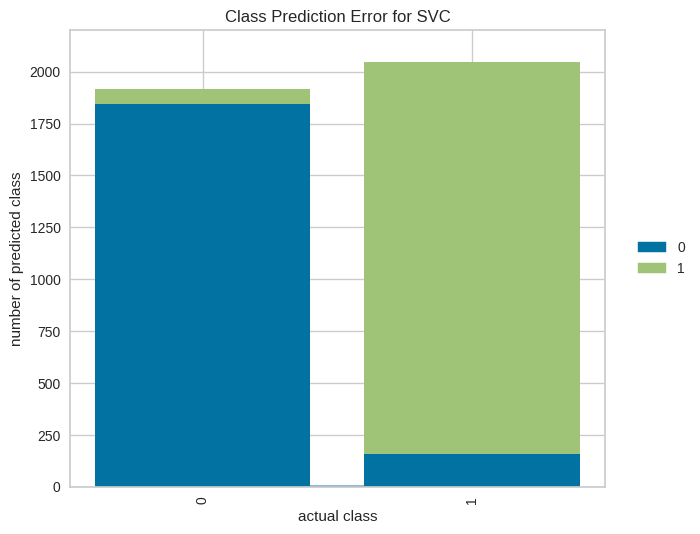

In [ ]:
train_and_evaluate_model(SVC())

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1999
           1       0.89      0.90      0.89      1961

    accuracy                           0.90      3960
   macro avg       0.90      0.90      0.90      3960
weighted avg       0.90      0.90      0.90      3960

--------------------------------------------------


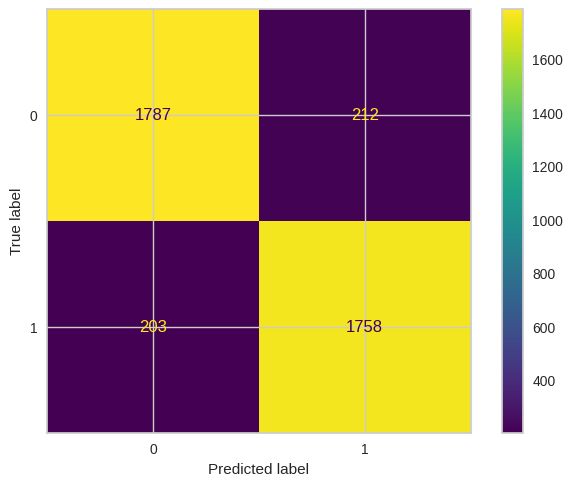

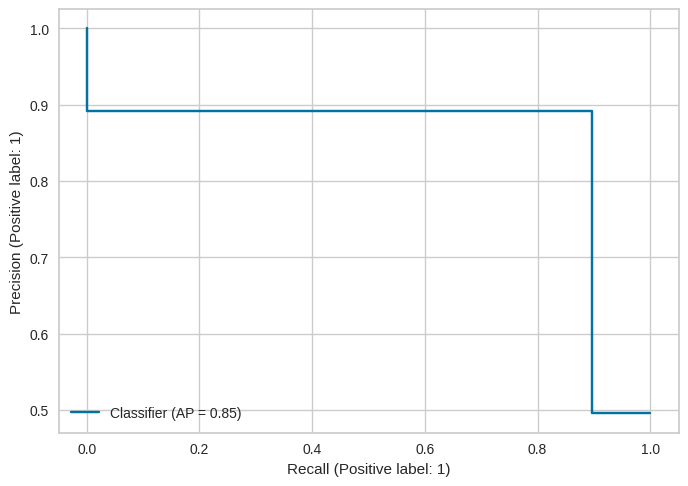

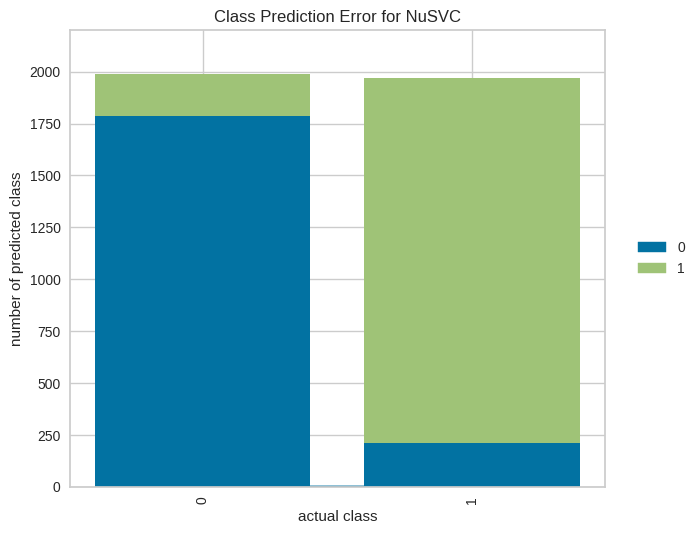

In [ ]:
train_and_evaluate_model(NuSVC())

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      1999
           1       0.89      0.92      0.91      1961

    accuracy                           0.91      3960
   macro avg       0.91      0.91      0.91      3960
weighted avg       0.91      0.91      0.91      3960

--------------------------------------------------


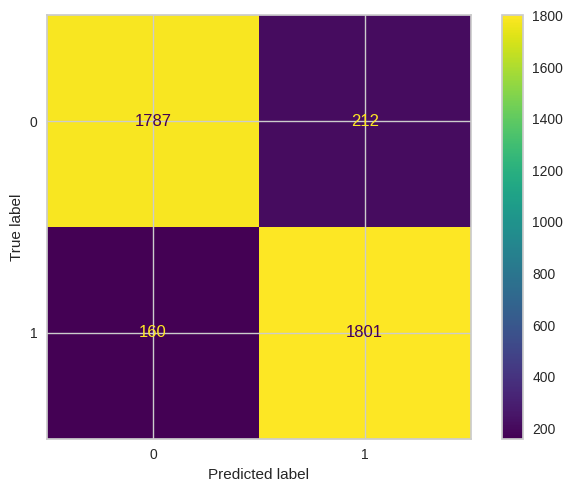

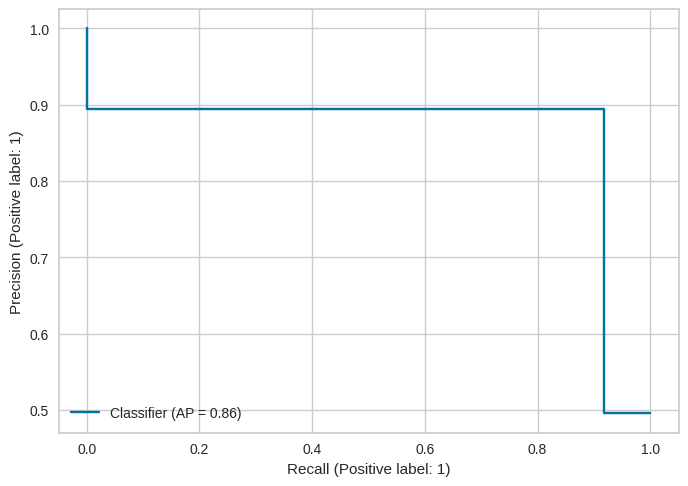

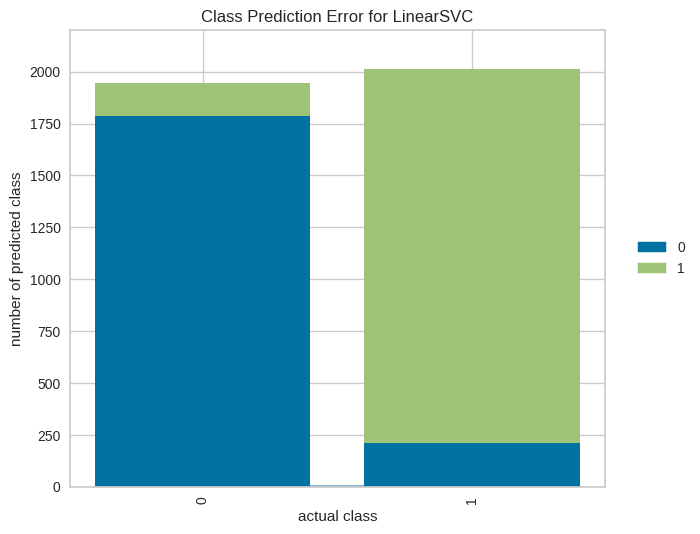

In [ ]:
train_and_evaluate_model(LinearSVC())

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1999
           1       0.94      0.96      0.95      1961

    accuracy                           0.95      3960
   macro avg       0.95      0.95      0.95      3960
weighted avg       0.95      0.95      0.95      3960

--------------------------------------------------


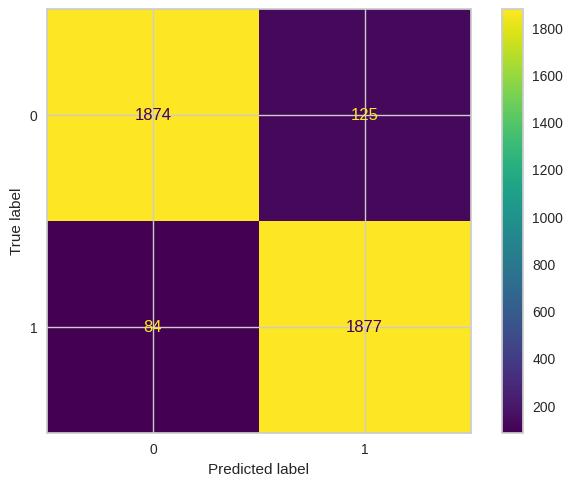

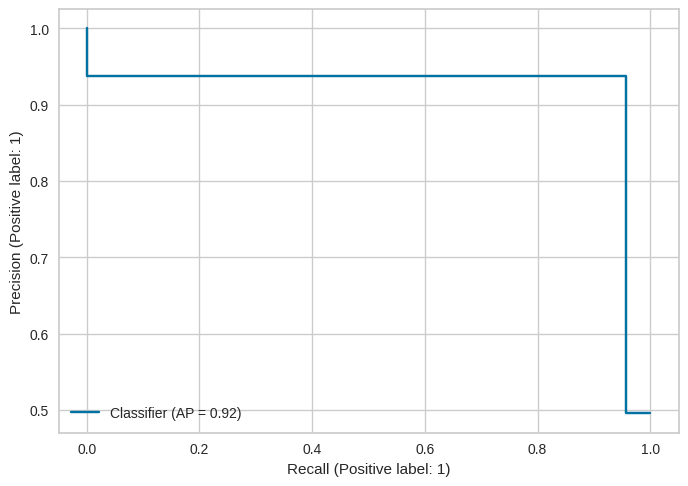

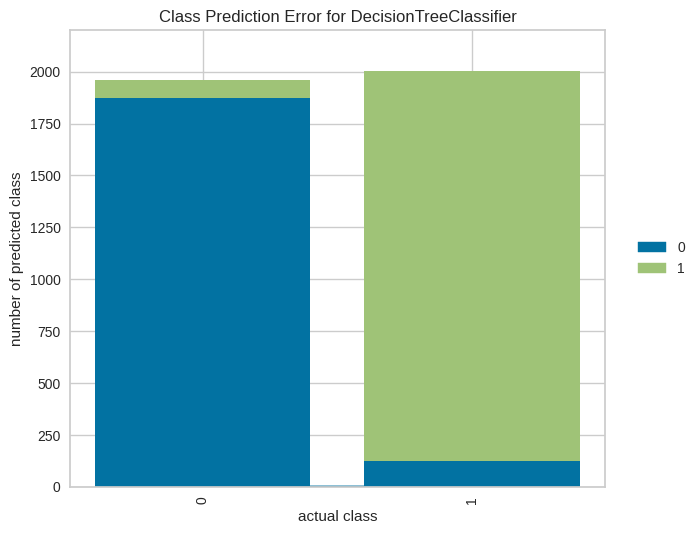

In [ ]:
train_and_evaluate_model(DecisionTreeClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1999
           1       0.96      0.98      0.97      1961

    accuracy                           0.97      3960
   macro avg       0.97      0.97      0.97      3960
weighted avg       0.97      0.97      0.97      3960

--------------------------------------------------


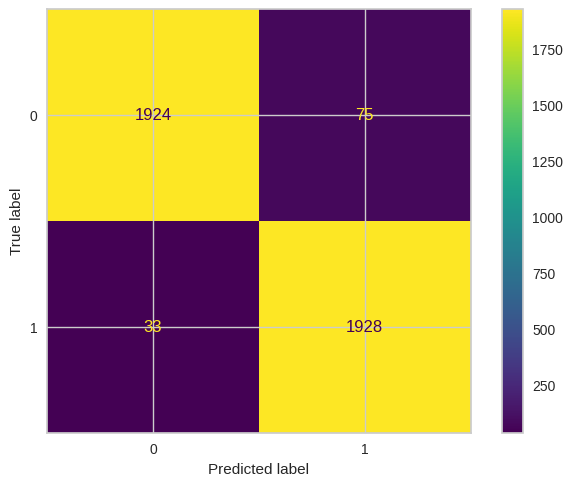

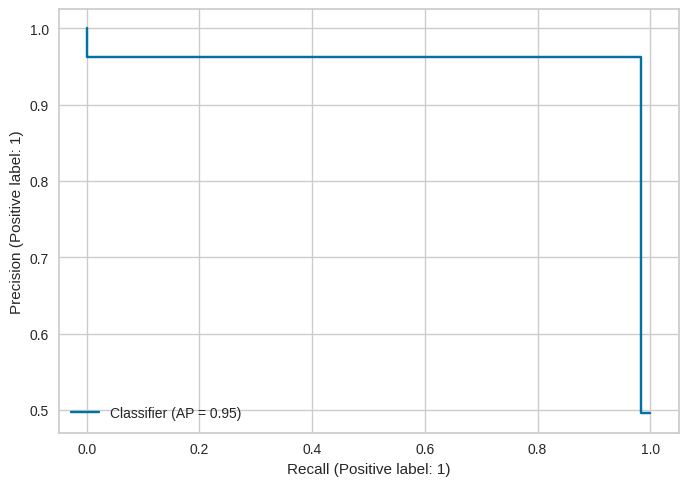

In [ ]:
train_and_evaluate_model(RandomForestClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1999
           1       0.95      0.98      0.97      1961

    accuracy                           0.96      3960
   macro avg       0.97      0.97      0.96      3960
weighted avg       0.97      0.96      0.96      3960

--------------------------------------------------


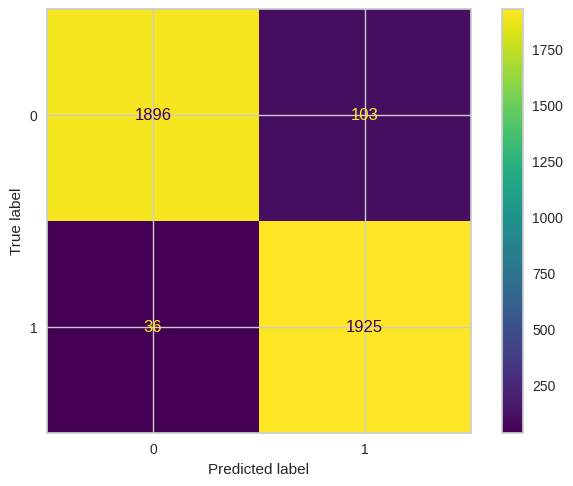

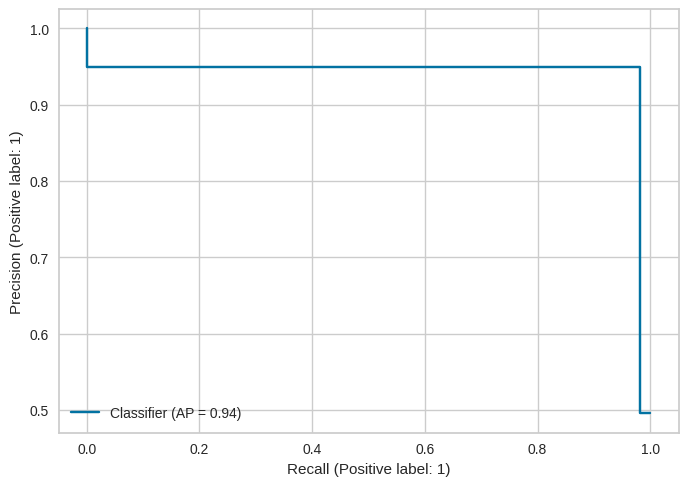

In [ ]:
train_and_evaluate_model(MLPClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1999
           1       0.97      0.99      0.98      1961

    accuracy                           0.98      3960
   macro avg       0.98      0.98      0.98      3960
weighted avg       0.98      0.98      0.98      3960

--------------------------------------------------


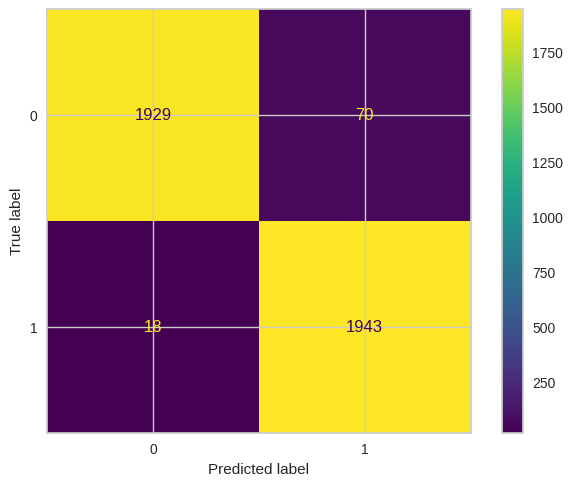

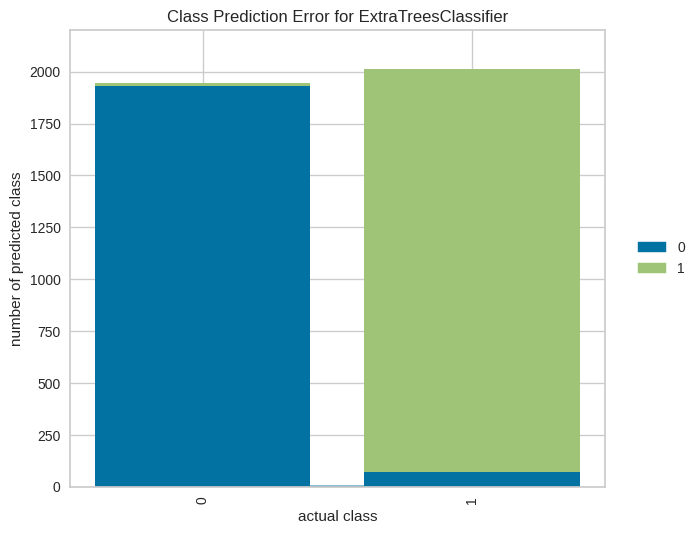

In [ ]:
train_and_evaluate_model(ExtraTreesClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1999
           1       0.92      0.93      0.93      1961

    accuracy                           0.93      3960
   macro avg       0.93      0.93      0.93      3960
weighted avg       0.93      0.93      0.93      3960

--------------------------------------------------


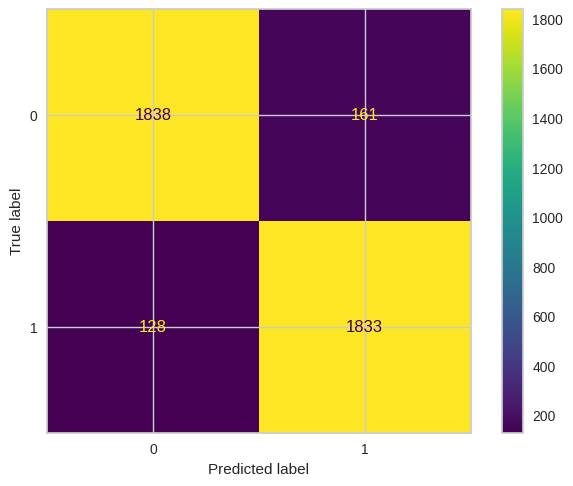

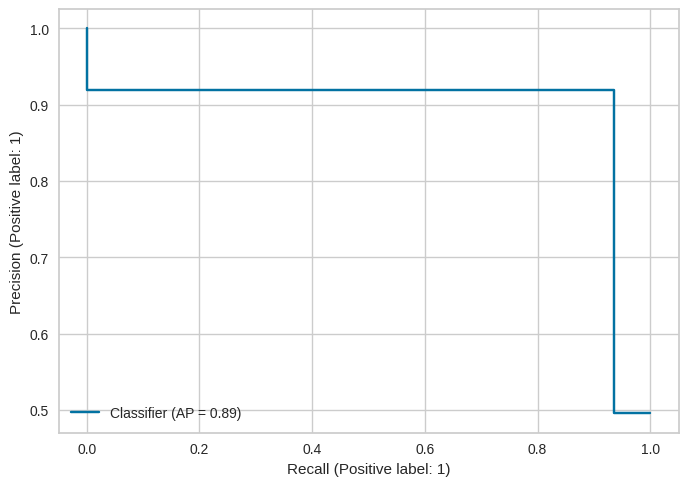

In [ ]:
train_and_evaluate_model(AdaBoostClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1999
           1       0.93      0.95      0.94      1961

    accuracy                           0.94      3960
   macro avg       0.94      0.94      0.94      3960
weighted avg       0.94      0.94      0.94      3960

--------------------------------------------------


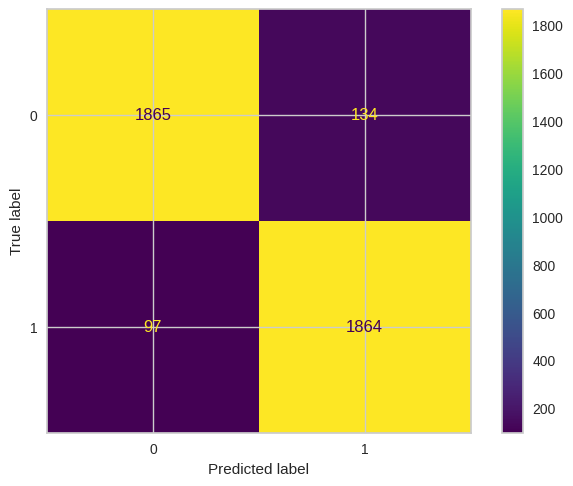

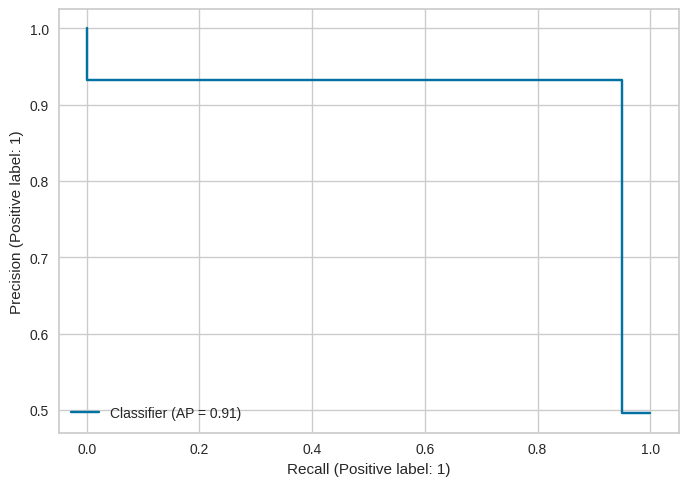

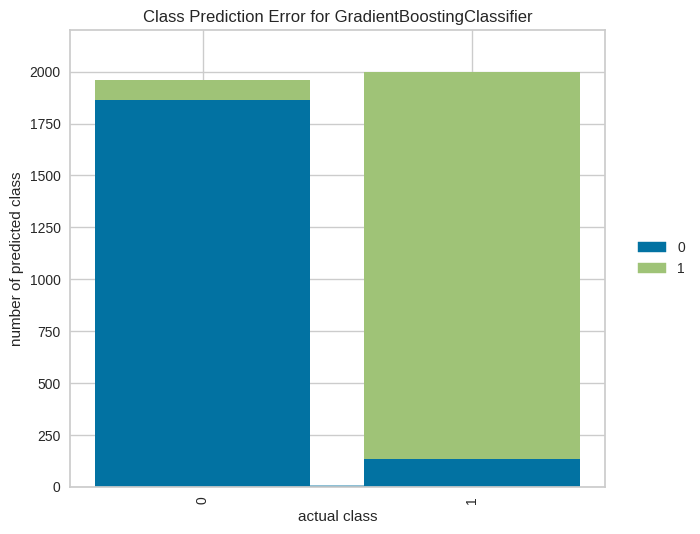

In [ ]:
train_and_evaluate_model(GradientBoostingClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1999
           1       0.96      0.97      0.96      1961

    accuracy                           0.96      3960
   macro avg       0.96      0.96      0.96      3960
weighted avg       0.96      0.96      0.96      3960

--------------------------------------------------


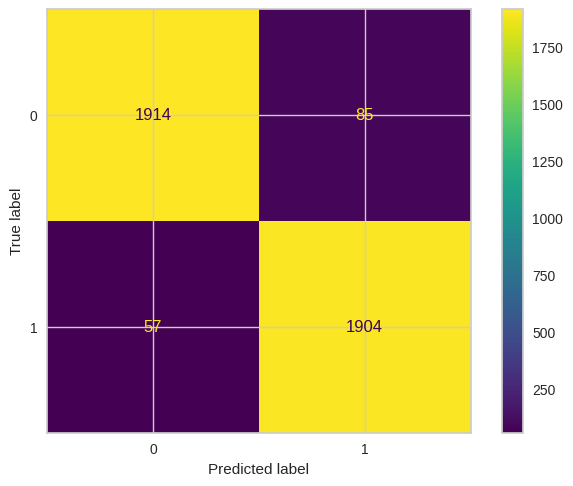

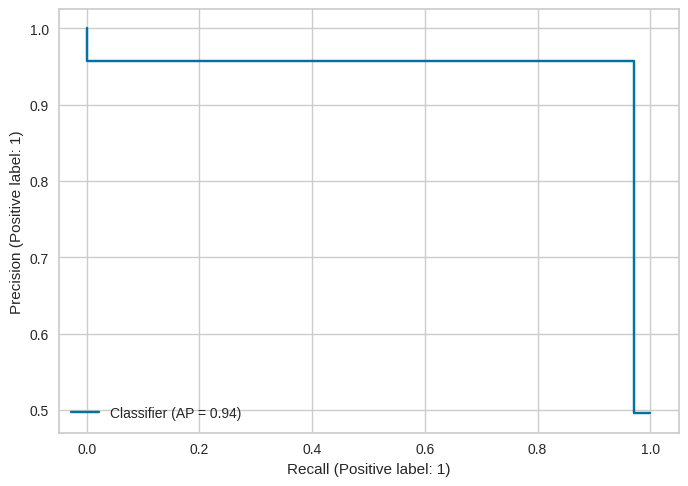

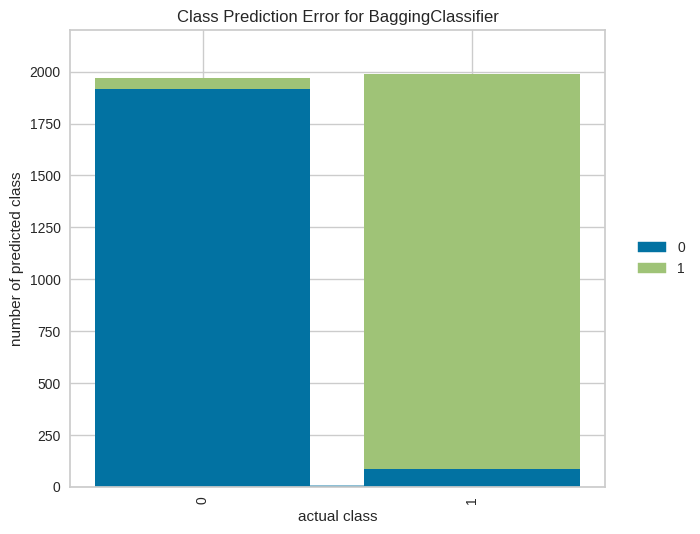

In [ ]:
train_and_evaluate_model(BaggingClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1999
           1       0.96      0.98      0.97      1961

    accuracy                           0.97      3960
   macro avg       0.97      0.97      0.97      3960
weighted avg       0.97      0.97      0.97      3960

--------------------------------------------------


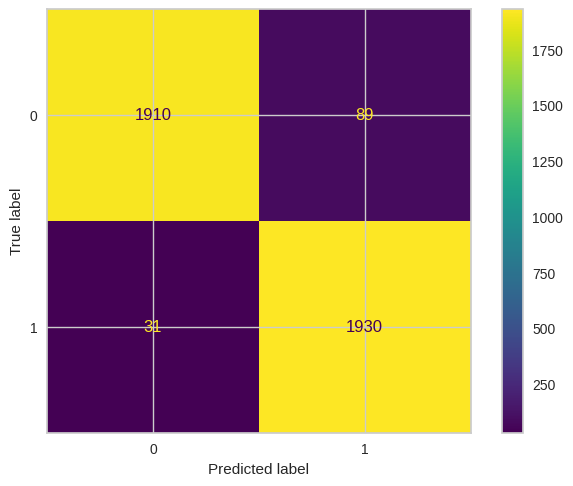

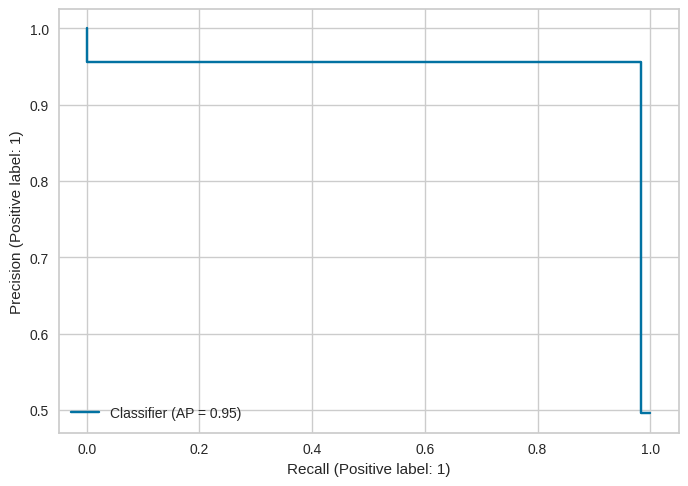

In [ ]:
train_and_evaluate_model(HistGradientBoostingClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1999
           1       0.95      0.99      0.97      1961

    accuracy                           0.97      3960
   macro avg       0.97      0.97      0.97      3960
weighted avg       0.97      0.97      0.97      3960

--------------------------------------------------


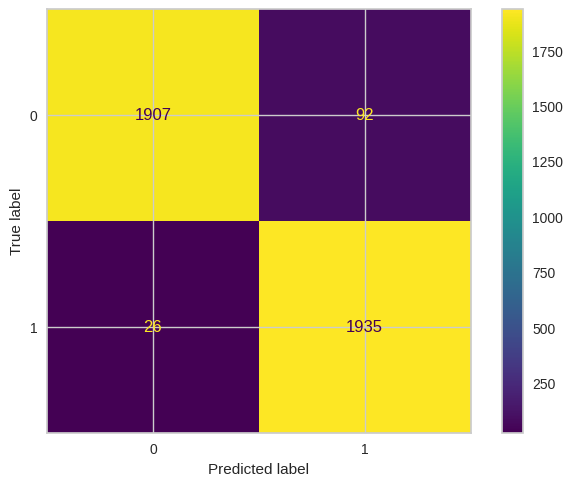

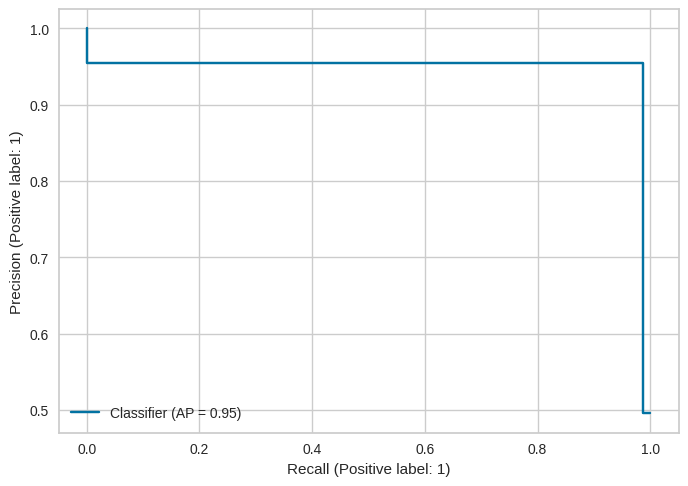

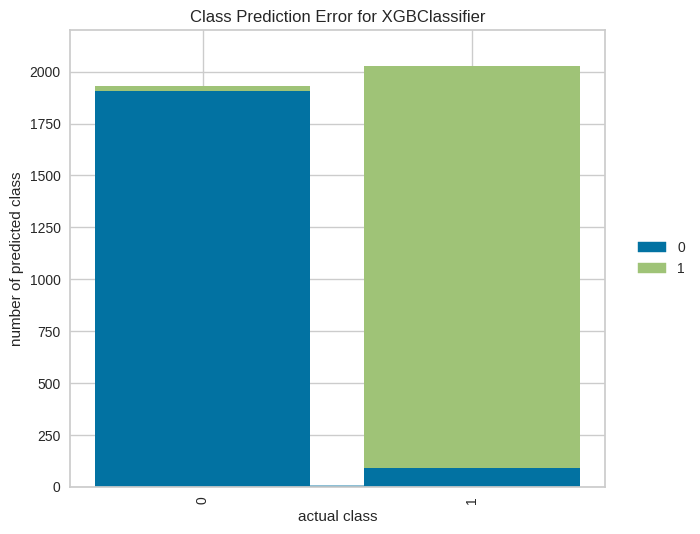

In [ ]:
train_and_evaluate_model(XGBClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      1999
           1       0.93      0.96      0.95      1961

    accuracy                           0.94      3960
   macro avg       0.94      0.94      0.94      3960
weighted avg       0.95      0.94      0.94      3960

--------------------------------------------------


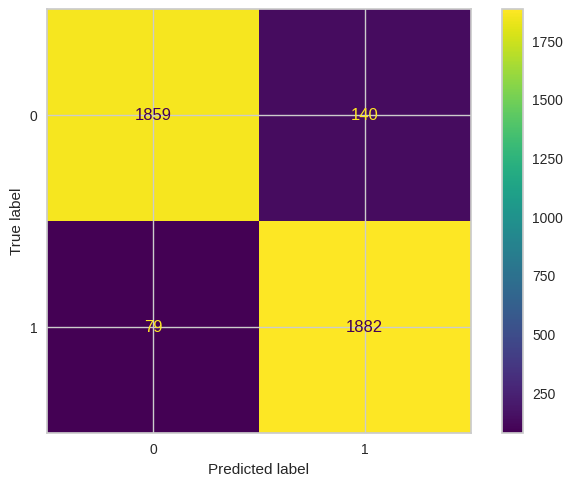

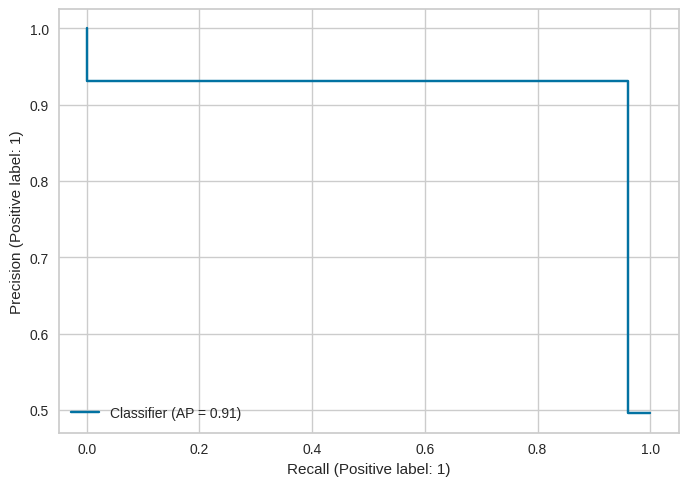

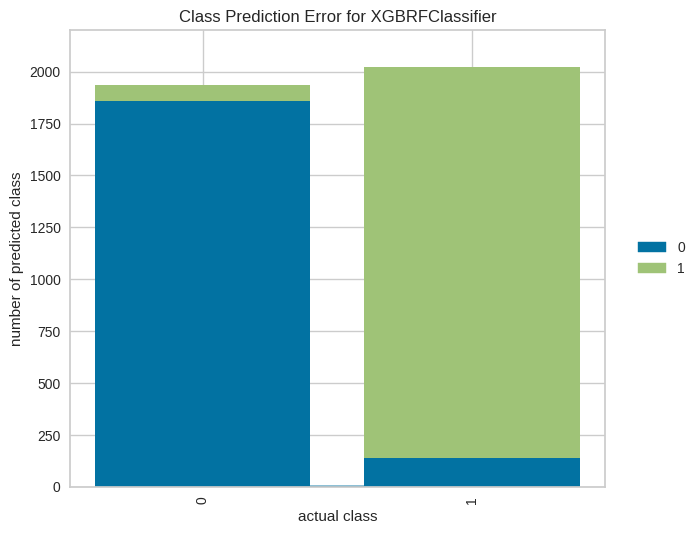

In [ ]:
train_and_evaluate_model(XGBRFClassifier())

[LightGBM] [Info] Number of positive: 4638, number of negative: 4600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 9238, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502057 -> initscore=0.008227
[LightGBM] [Info] Start training from score 0.008227
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1999
           1       0.95      0.98      0.97      1961

    accuracy                           0.97      3960
   macro avg       0.97      0.97      0.97      3960
weighted avg       0.97      0.97      0.97      3960

--------------------------------------------------


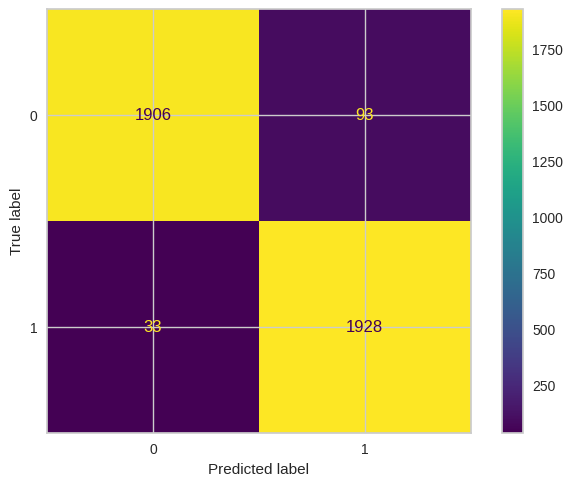

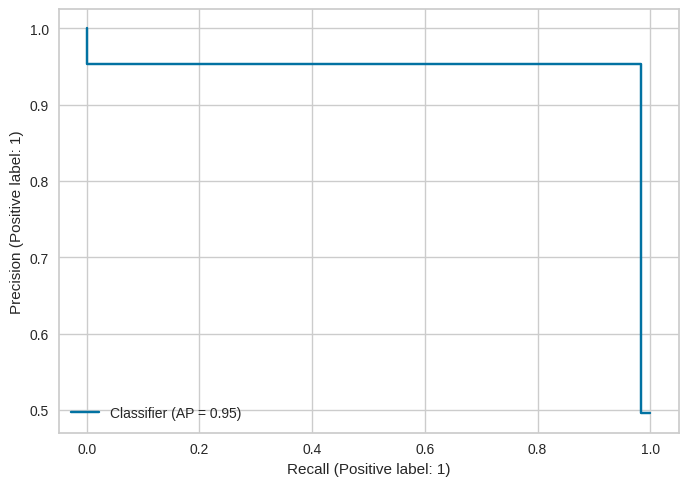

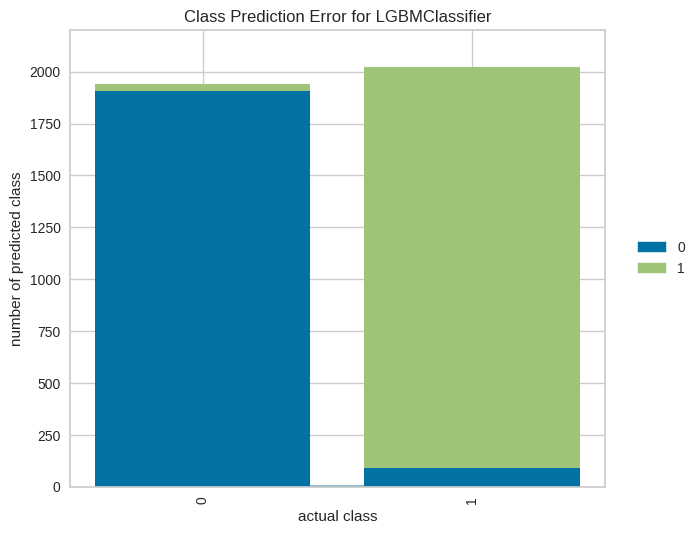

In [ ]:
train_and_evaluate_model(LGBMClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1999
           1       0.96      0.99      0.97      1961

    accuracy                           0.97      3960
   macro avg       0.97      0.97      0.97      3960
weighted avg       0.97      0.97      0.97      3960

--------------------------------------------------


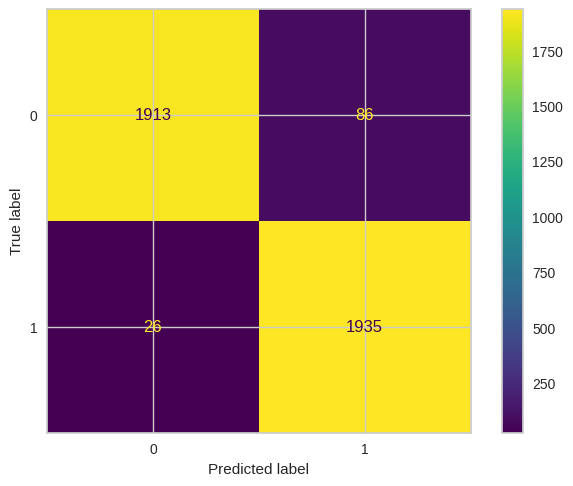

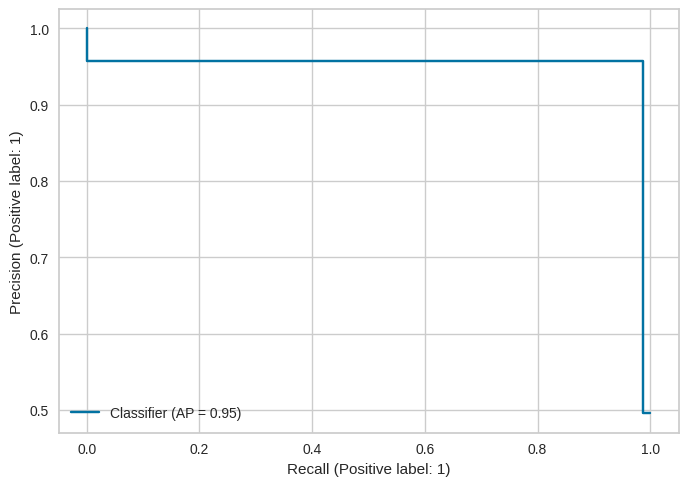

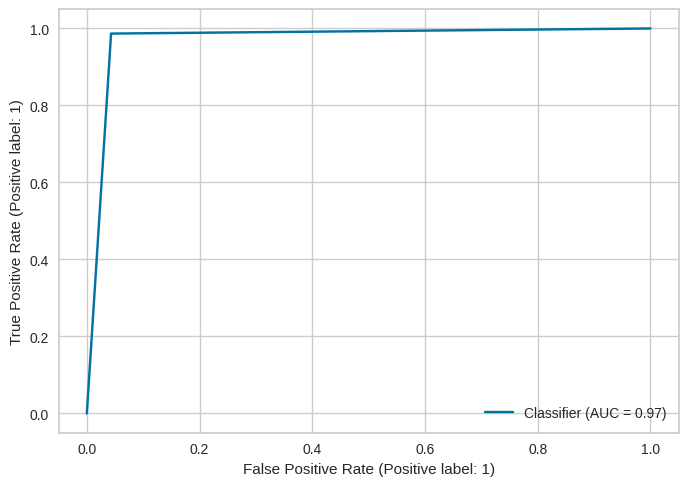

In [ ]:
train_and_evaluate_model(CatBoostClassifier(silent=True))

[Voting] ....................... (1 of 3) Processing ET, total=   0.6s
[Voting] ...................... (2 of 3) Processing XGB, total=   0.3s
[Voting] ...................... (3 of 3) Processing CAT, total=   5.3s
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1999
           1       0.96      0.99      0.97      1961

    accuracy                           0.97      3960
   macro avg       0.98      0.97      0.97      3960
weighted avg       0.98      0.97      0.97      3960

--------------------------------------------------


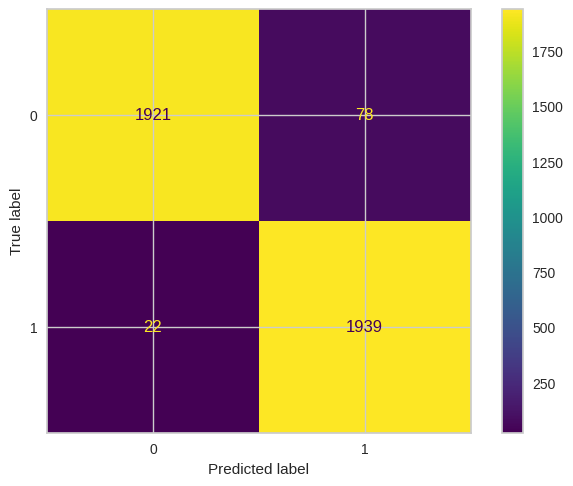

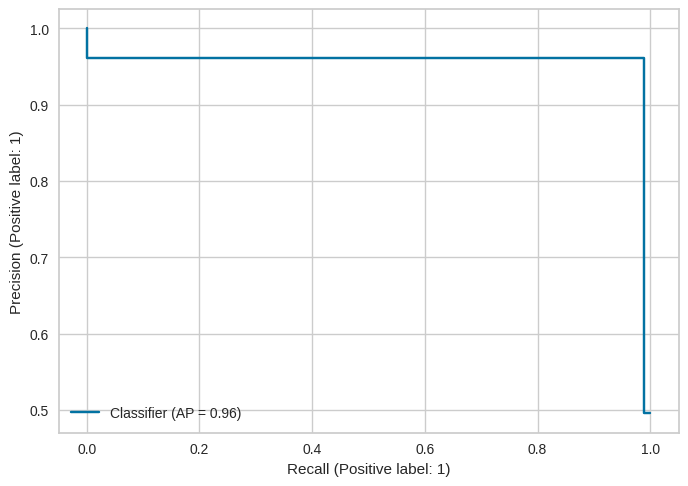

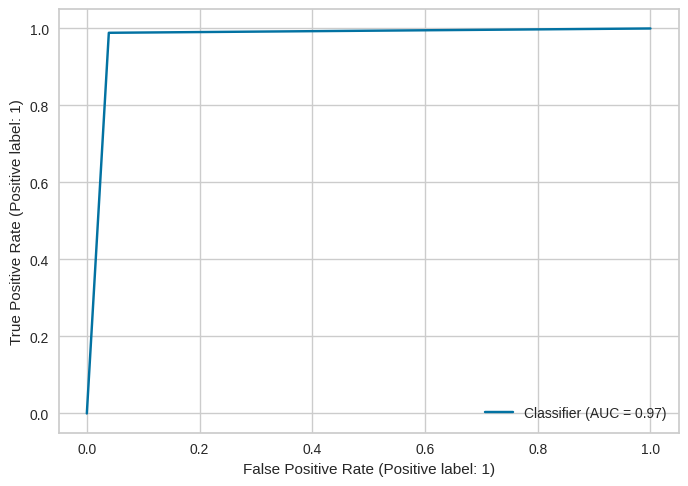

In [ ]:
train_and_evaluate_model(VotingClassifier(estimators=[
    ('ET',ExtraTreesClassifier()),
    ('XGB',XGBClassifier()),
    ('CAT',CatBoostClassifier(silent=True))
],verbose=2))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1999
           1       0.97      0.98      0.98      1961

    accuracy                           0.98      3960
   macro avg       0.98      0.98      0.98      3960
weighted avg       0.98      0.98      0.98      3960

--------------------------------------------------


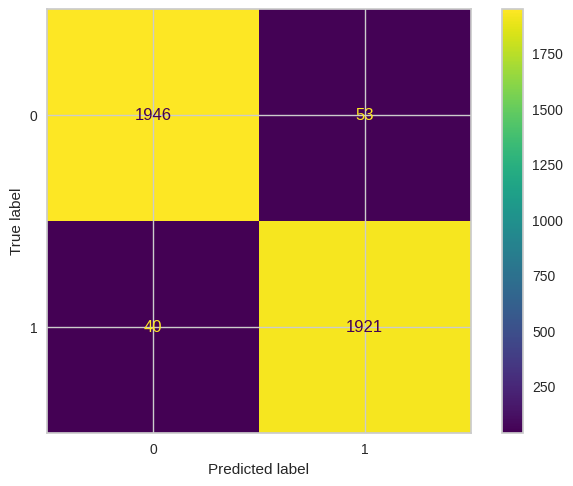

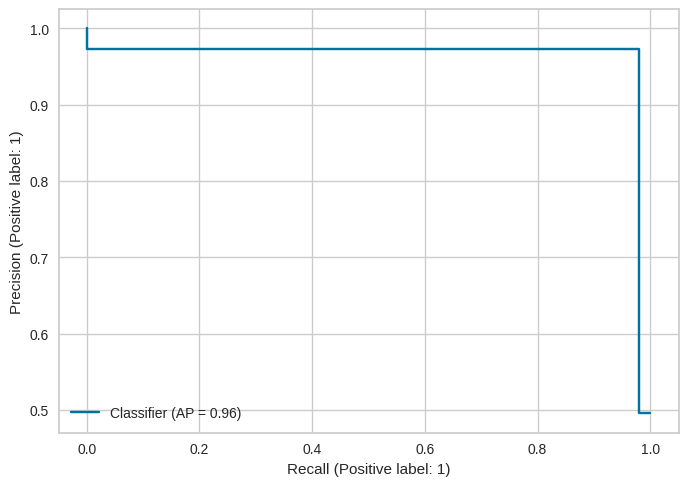

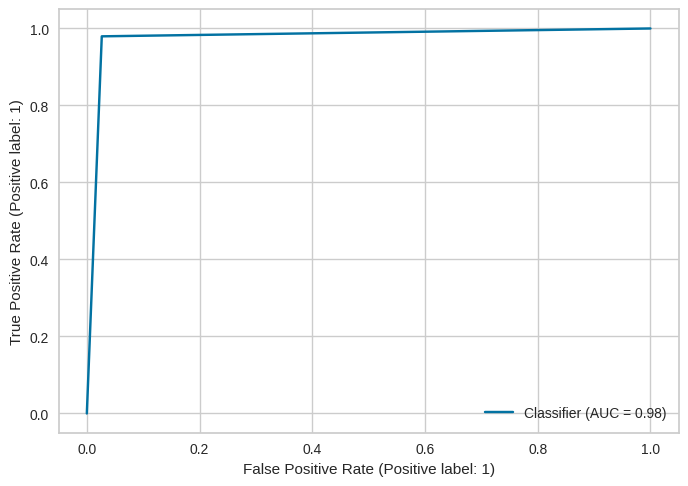

In [ ]:
train_and_evaluate_model(StackingClassifier(estimators=[
    ('ET',ExtraTreesClassifier()),
    ('XGB',XGBClassifier()),
    ('CAT',CatBoostClassifier(silent=True))
],final_estimator=RandomForestClassifier(),verbose=2))

## Baseline Models Performance Comparison

In [ ]:
model_perfs = pd.DataFrame({'Model': models,
                            'Accuracy': accuracy_scores,
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_perfs

Model  Accuracy  Precision  \
0   (ExtraTreeClassifier(random_state=179675827), ...  0.977778   0.977991   
1   StackingClassifier(estimators=[('ET', ExtraTre...  0.976515   0.976505   
2   VotingClassifier(estimators=[('ET', ExtraTrees...  0.974747   0.975003   
3   (DecisionTreeClassifier(max_features='sqrt', r...  0.972727   0.972847   
4   <catboost.core.CatBoostClassifier object at 0x...  0.971717   0.972019   
5   XGBClassifier(base_score=None, booster=None, c...  0.970202   0.970581   
6                    HistGradientBoostingClassifier()  0.969697   0.969974   
7                                    LGBMClassifier()  0.968182   0.968482   
8                                     MLPClassifier()  0.964899   0.965289   
9   (DecisionTreeClassifier(random_state=198662306...  0.964141   0.964173   
10                             KNeighborsClassifier()  0.957828   0.960061   
11                           DecisionTreeClassifier()  0.947222   0.947331   
12  XGBRFClassifier(base_score=None, booster=None,...  0.944697   0.944999   
13                                              SVC()  0.942172   0.942824   
14  ([DecisionTreeRegressor(criterion='friedman_ms...  0.941667   0.941747   
15  (DecisionTreeClassifier(max_depth=1, random_st...  0.927020   0.927075   
16                               LogisticRegression()  0.906313   0.906446   
17                                        LinearSVC()  0.906061   0.906253   
18                                  RidgeClassifier()  0.899242   0.900246   
19                                    SGDClassifier()  0.899242   0.899248   
20                                            NuSVC()  0.895202   0.895188   
21                                       GaussianNB()  0.891162   0.891308   
22                                      BernoulliNB()  0.885354   0.885640   
23                      PassiveAggressiveClassifier()  0.876263   0.882819   

      Recall        F1   ROC-AUC  
0   0.977902  0.977778  0.977902  
1   0.976544  0.976514  0.976544  
2   0.974881  0.974747  0.974881  
3   0.972827  0.972727  0.972827  
4   0.971860  0.971716  0.971860  
5   0.970359  0.970201  0.970359  
6   0.969835  0.969696  0.969835  
7   0.968324  0.968181  0.968324  
8   0.965058  0.964897  0.965058  
9   0.964206  0.964141  0.964206  
10  0.958181  0.957796  0.958181  
11  0.947317  0.947222  0.947317  
12  0.944840  0.944695  0.944840  
13  0.942372  0.942164  0.942372  
14  0.941751  0.941667  0.941751  
15  0.927093  0.927020  0.927093  
16  0.906414  0.906313  0.906414  
17  0.906178  0.906059  0.906178  
18  0.899492  0.899212  0.899492  
19  0.899284  0.899241  0.899284  
20  0.895214  0.895196  0.895214  
21  0.891265  0.891161  0.891265  
22  0.885493  0.885349  0.885493  
23  0.876896  0.875851  0.876896

Among all the baseline models, the Stacking Classifier is the best performing model which outperforms all other models by achieving a remarkable accuracy of almost 98% on the test set.

## Optimized Models Performance Comparison

In [ ]:
model_perfs = pd.DataFrame({'Model': models,
                            'Accuracy': accuracy_scores,
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores,
                            'ROC-AUC': roc_auc_scores}).sort_values('Accuracy',ascending=False).reset_index(drop=True)
model_perfs

Model  Accuracy  Precision  \
0   (ExtraTreeClassifier(random_state=179675827), ...  0.977778   0.977991   
1   StackingClassifier(estimators=[('ET', ExtraTre...  0.976515   0.976505   
2   VotingClassifier(estimators=[('ET', ExtraTrees...  0.974747   0.975003   
3   (DecisionTreeClassifier(max_features='sqrt', r...  0.972727   0.972847   
4   <catboost.core.CatBoostClassifier object at 0x...  0.971717   0.972019   
5   XGBClassifier(base_score=None, booster=None, c...  0.970202   0.970581   
6                    HistGradientBoostingClassifier()  0.969697   0.969974   
7                                    LGBMClassifier()  0.968182   0.968482   
8                                     MLPClassifier()  0.964899   0.965289   
9   (DecisionTreeClassifier(random_state=198662306...  0.964141   0.964173   
10                             KNeighborsClassifier()  0.957828   0.960061   
11                           DecisionTreeClassifier()  0.947222   0.947331   
12  XGBRFClassifier(base_score=None, booster=None,...  0.944697   0.944999   
13                                              SVC()  0.942172   0.942824   
14  ([DecisionTreeRegressor(criterion='friedman_ms...  0.941667   0.941747   
15  (DecisionTreeClassifier(max_depth=1, random_st...  0.927020   0.927075   
16                               LogisticRegression()  0.906313   0.906446   
17                                        LinearSVC()  0.906061   0.906253   
18                                  RidgeClassifier()  0.899242   0.900246   
19                                    SGDClassifier()  0.899242   0.899248   
20                                            NuSVC()  0.895202   0.895188   
21                                       GaussianNB()  0.891162   0.891308   
22                                      BernoulliNB()  0.885354   0.885640   
23                      PassiveAggressiveClassifier()  0.876263   0.882819   

      Recall        F1   ROC-AUC  
0   0.977902  0.977778  0.977902  
1   0.976544  0.976514  0.976544  
2   0.974881  0.974747  0.974881  
3   0.972827  0.972727  0.972827  
4   0.971860  0.971716  0.971860  
5   0.970359  0.970201  0.970359  
6   0.969835  0.969696  0.969835  
7   0.968324  0.968181  0.968324  
8   0.965058  0.964897  0.965058  
9   0.964206  0.964141  0.964206  
10  0.958181  0.957796  0.958181  
11  0.947317  0.947222  0.947317  
12  0.944840  0.944695  0.944840  
13  0.942372  0.942164  0.942372  
14  0.941751  0.941667  0.941751  
15  0.927093  0.927020  0.927093  
16  0.906414  0.906313  0.906414  
17  0.906178  0.906059  0.906178  
18  0.899492  0.899212  0.899492  
19  0.899284  0.899241  0.899284  
20  0.895214  0.895196  0.895214  
21  0.891265  0.891161  0.891265  
22  0.885493  0.885349  0.885493  
23  0.876896  0.875851  0.876896

Even after completing hyperparameter tuning for all the models, none of them is able to produce an accuracy score as promising as the Stacking Classifier which therefore retains its status as the best performing model.

In [ ]:
best_model = model_perfs.iloc[0]['Model']
best_model

ExtraTreesClassifier()

In [ ]:
avg_cv_scores = cross_val_score(best_model,final_X_test,y_test,scoring='accuracy',cv=5,verbose=2)
mean_score = round(np.mean(avg_cv_scores),4)
print(f"Mean Cross Validation Performance of Stacking Classifier: {mean_score*100}%")

[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.3s
Mean Cross Validation Performance of Stacking Classifier: 96.26%


The Stacking Classifier model is thus able to maintain its performance level on the cross validation set which clearly suggests that there is no overfitting.

## Saving the best performing model for deployment into production

It is always preferable to leverage the lightweight models with fast inferential capabilities while deploying. It would be more appropriate to use the third-best performing model, the Extra Trees Classifier, which offers significantly lower latency and comparable efficiency in predictive performance, as the top two models, the Stacking Classifier and the hyperparameter-optimized Random Forest Classifier, are relatively heavyweight and possess more latency despite being highly accurate.

In [ ]:
pipeline = Pipeline(steps=[
    ('scaler',scaler),
    ('model',model_perfs.iloc[3]['Model'])
])
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [ ]:
joblib.dump(pipeline,'pipeline.pkl')

['pipeline.pkl']

In [ ]:
joblib.load('pipeline.pkl')

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [ ]:
gc.collect()

12089

In [ ]:
df.rename(renamed_cols,axis=1,inplace=True)

In [ ]:
for col in final_X_train.columns:
    print(f"Minimum value of {col}:",df[col].min())
    print(f"Maximum value of {col}:",df[col].max())

Minimum value of WorkingCapital/Equity: 0.0
Maximum value of WorkingCapital/Equity: 1.0
Minimum value of PersistentEPSintheLastFourSeasons: 0.0
Maximum value of PersistentEPSintheLastFourSeasons: 1.0
Minimum value of BorrowingDependency: 0.0
Maximum value of BorrowingDependency: 1.0
Minimum value of NetValueGrowthRate: 0.0
Maximum value of NetValueGrowthRate: 9330000000.0
Minimum value of InterestBearingDebtInterestRate: 0.0
Maximum value of InterestBearingDebtInterestRate: 990000000.0
Minimum value of ROA(C)BeforeInterestAndDepreciationBeforeInterest: 0.0
Maximum value of ROA(C)BeforeInterestAndDepreciationBeforeInterest: 1.0
Minimum value of Cash/TotalAssets: 0.0
Maximum value of Cash/TotalAssets: 1.0
Minimum value of NonIndustryIncomeAndExpenditure/Revenue: 0.0
Maximum value of NonIndustryIncomeAndExpenditure/Revenue: 1.0
Minimum value of NetValuePerShare(B): 0.0
Maximum value of NetValuePerShare(B): 1.0
Minimum value of TotalDebt/TotalNetWorth: 0.0
Maximum value of TotalDebt/TotalN

In [ ]:
list(final_X_train.columns)

['WorkingCapital/Equity',
 'PersistentEPSintheLastFourSeasons',
 'BorrowingDependency',
 'NetValueGrowthRate',
 'InterestBearingDebtInterestRate',
 'ROA(C)BeforeInterestAndDepreciationBeforeInterest',
 'Cash/TotalAssets',
 'NonIndustryIncomeAndExpenditure/Revenue',
 'NetValuePerShare(B)',
 'TotalDebt/TotalNetWorth']

In [ ]:
final_column = ['WorkingCapital/Equity',
 'PersistentEPSintheLastFourSeasons',
 'BorrowingDependency',
 'NetValueGrowthRate',
 'InterestBearingDebtInterestRate',
 'ROA(C)BeforeInterestAndDepreciationBeforeInterest',
 'Cash/TotalAssets',
 'NonIndustryIncomeAndExpenditure/Revenue',
 'NetValuePerShare(B)',
 'TotalDebt/TotalNetWorth']

In [ ]:
final_column

['WorkingCapital/Equity',
 'PersistentEPSintheLastFourSeasons',
 'BorrowingDependency',
 'NetValueGrowthRate',
 'InterestBearingDebtInterestRate',
 'ROA(C)BeforeInterestAndDepreciationBeforeInterest',
 'Cash/TotalAssets',
 'NonIndustryIncomeAndExpenditure/Revenue',
 'NetValuePerShare(B)',
 'TotalDebt/TotalNetWorth']

In [ ]:
del pipeline
gc.collect()